In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 10
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_firstorder_TotalEnergy_firstorder_Minimum_firstorder_10Percentile_firstorder_Median_firstorder_InterquartileRange_firstorder_Range_firstorder_RobustMeanAbsoluteDeviation_firstorder_RootMeanSquared_firstorder_Skewness_firstorder_Kurtosis_firstorder_Variance_firstorder_Uniformity_glcm_JointAverage_glcm_ClusterProminence_glcm_ClusterShade_glcm_ClusterTendency_glcm_Contrast_glcm_Correlation_glcm_DifferenceAverage_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 738)
(772408, 8)
validation
(101248, 738)
(101248, 8)
test
(98888, 738)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 738)]             0         


 dense (Dense)               (None, 1024)              756736    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1446792 (5.52 MB)


Trainable params: 1446792 (5.52 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:39 - loss: 1.7114 - STD: 0.0727 - MAE: 0.2008

 4/78 [>.............................] - ETA: 1s - loss: 1.4523 - STD: 0.1628 - MAE: 0.1590  

 6/78 [=>............................] - ETA: 2s - loss: 1.4246 - STD: 0.1912 - MAE: 0.1471

 7/78 [=>............................] - ETA: 2s - loss: 1.4157 - STD: 0.1975 - MAE: 0.1445

 8/78 [==>...........................] - ETA: 2s - loss: 1.4056 - STD: 0.2003 - MAE: 0.1432

 9/78 [==>...........................] - ETA: 2s - loss: 1.3961 - STD: 0.2005 - MAE: 0.1429

10/78 [==>...........................] - ETA: 2s - loss: 1.3909 - STD: 0.1991 - MAE: 0.1434

11/78 [===>..........................] - ETA: 2s - loss: 1.3858 - STD: 0.1970 - MAE: 0.1441

12/78 [===>..........................] - ETA: 2s - loss: 1.3819 - STD: 0.1948 - MAE: 0.1449

13/78 [====>.........................] - ETA: 2s - loss: 1.3785 - STD: 0.1929 - MAE: 0.1457

14/78 [====>.........................] - ETA: 2s - loss: 1.3753 - STD: 0.1914 - MAE: 0.1462

15/78 [====>.........................] - ETA: 5s - loss: 1.3744 - STD: 0.1906 - MAE: 0.1465

19/78 [======>.......................] - ETA: 4s - loss: 1.3632 - STD: 0.1913 - MAE: 0.1461

20/78 [======>.......................] - ETA: 3s - loss: 1.3607 - STD: 0.1919 - MAE: 0.1458

21/78 [=======>......................] - ETA: 3s - loss: 1.3592 - STD: 0.1925 - MAE: 0.1456

22/78 [=======>......................] - ETA: 3s - loss: 1.3582 - STD: 0.1929 - MAE: 0.1454

23/78 [=======>......................] - ETA: 3s - loss: 1.3560 - STD: 0.1933 - MAE: 0.1452

24/78 [========>.....................] - ETA: 3s - loss: 1.3544 - STD: 0.1934 - MAE: 0.1451

25/78 [========>.....................] - ETA: 3s - loss: 1.3529 - STD: 0.1935 - MAE: 0.1451

26/78 [=========>....................] - ETA: 3s - loss: 1.3521 - STD: 0.1934 - MAE: 0.1452

27/78 [=========>....................] - ETA: 3s - loss: 1.3508 - STD: 0.1931 - MAE: 0.1452

28/78 [=========>....................] - ETA: 3s - loss: 1.3493 - STD: 0.1929 - MAE: 0.1453

29/78 [==========>...................] - ETA: 3s - loss: 1.3484 - STD: 0.1925 - MAE: 0.1454

30/78 [==========>...................] - ETA: 3s - loss: 1.3475 - STD: 0.1922 - MAE: 0.1455

31/78 [==========>...................] - ETA: 2s - loss: 1.3467 - STD: 0.1920 - MAE: 0.1456

32/78 [===========>..................] - ETA: 2s - loss: 1.3460 - STD: 0.1918 - MAE: 0.1457

33/78 [===========>..................] - ETA: 2s - loss: 1.3446 - STD: 0.1916 - MAE: 0.1457

34/78 [============>.................] - ETA: 2s - loss: 1.3440 - STD: 0.1915 - MAE: 0.1458

35/78 [============>.................] - ETA: 2s - loss: 1.3433 - STD: 0.1915 - MAE: 0.1458

36/78 [============>.................] - ETA: 2s - loss: 1.3424 - STD: 0.1916 - MAE: 0.1457

37/78 [=============>................] - ETA: 2s - loss: 1.3416 - STD: 0.1916 - MAE: 0.1457

38/78 [=============>................] - ETA: 2s - loss: 1.3410 - STD: 0.1917 - MAE: 0.1457

39/78 [==============>...............] - ETA: 2s - loss: 1.3403 - STD: 0.1918 - MAE: 0.1456

40/78 [==============>...............] - ETA: 2s - loss: 1.3396 - STD: 0.1919 - MAE: 0.1456

41/78 [==============>...............] - ETA: 2s - loss: 1.3387 - STD: 0.1920 - MAE: 0.1455

42/78 [===============>..............] - ETA: 2s - loss: 1.3382 - STD: 0.1921 - MAE: 0.1455

43/78 [===============>..............] - ETA: 2s - loss: 1.3377 - STD: 0.1921 - MAE: 0.1455

44/78 [===============>..............] - ETA: 2s - loss: 1.3373 - STD: 0.1921 - MAE: 0.1455

45/78 [================>.............] - ETA: 1s - loss: 1.3366 - STD: 0.1921 - MAE: 0.1455

46/78 [================>.............] - ETA: 1s - loss: 1.3357 - STD: 0.1920 - MAE: 0.1454

47/78 [=================>............] - ETA: 1s - loss: 1.3353 - STD: 0.1920 - MAE: 0.1455

48/78 [=================>............] - ETA: 1s - loss: 1.3349 - STD: 0.1919 - MAE: 0.1455

49/78 [=================>............] - ETA: 1s - loss: 1.3342 - STD: 0.1919 - MAE: 0.1455

50/78 [==================>...........] - ETA: 1s - loss: 1.3336 - STD: 0.1919 - MAE: 0.1455

51/78 [==================>...........] - ETA: 1s - loss: 1.3324 - STD: 0.1918 - MAE: 0.1454

52/78 [===================>..........] - ETA: 1s - loss: 1.3320 - STD: 0.1919 - MAE: 0.1454

53/78 [===================>..........] - ETA: 1s - loss: 1.3318 - STD: 0.1919 - MAE: 0.1454

54/78 [===================>..........] - ETA: 1s - loss: 1.3314 - STD: 0.1920 - MAE: 0.1453

55/78 [====================>.........] - ETA: 1s - loss: 1.3312 - STD: 0.1920 - MAE: 0.1453

57/78 [====================>.........] - ETA: 1s - loss: 1.3307 - STD: 0.1921 - MAE: 0.1453

58/78 [=====================>........] - ETA: 1s - loss: 1.3302 - STD: 0.1920 - MAE: 0.1453

59/78 [=====================>........] - ETA: 1s - loss: 1.3298 - STD: 0.1920 - MAE: 0.1453

60/78 [======================>.......] - ETA: 1s - loss: 1.3295 - STD: 0.1919 - MAE: 0.1453

61/78 [======================>.......] - ETA: 0s - loss: 1.3289 - STD: 0.1919 - MAE: 0.1453

62/78 [======================>.......] - ETA: 0s - loss: 1.3289 - STD: 0.1918 - MAE: 0.1454

63/78 [=======================>......] - ETA: 0s - loss: 1.3286 - STD: 0.1918 - MAE: 0.1454

64/78 [=======================>......] - ETA: 0s - loss: 1.3282 - STD: 0.1918 - MAE: 0.1454

65/78 [========================>.....] - ETA: 0s - loss: 1.3277 - STD: 0.1918 - MAE: 0.1454

66/78 [========================>.....] - ETA: 0s - loss: 1.3274 - STD: 0.1918 - MAE: 0.1453

67/78 [========================>.....] - ETA: 0s - loss: 1.3269 - STD: 0.1918 - MAE: 0.1453

68/78 [=========================>....] - ETA: 0s - loss: 1.3268 - STD: 0.1918 - MAE: 0.1453

69/78 [=========================>....] - ETA: 0s - loss: 1.3261 - STD: 0.1917 - MAE: 0.1453

70/78 [=========================>....] - ETA: 0s - loss: 1.3260 - STD: 0.1917 - MAE: 0.1453

71/78 [==========================>...] - ETA: 0s - loss: 1.3254 - STD: 0.1917 - MAE: 0.1453

73/78 [===========================>..] - ETA: 0s - loss: 1.3247 - STD: 0.1916 - MAE: 0.1453

75/78 [===========================>..] - ETA: 0s - loss: 1.3233 - STD: 0.1916 - MAE: 0.1453

76/78 [============================>.] - ETA: 0s - loss: 1.3225 - STD: 0.1916 - MAE: 0.1452

77/78 [============================>.] - ETA: 0s - loss: 1.3221 - STD: 0.1917 - MAE: 0.1452

78/78 [==============================] - ETA: 0s - loss: 1.3214 - STD: 0.1917 - MAE: 0.1451

78/78 [==============================] - 6s 65ms/step - loss: 1.3214 - STD: 0.1917 - MAE: 0.1451 - val_loss: 1.2158 - val_STD: 0.1902 - val_MAE: 0.1420


Epoch 2/10000


 1/78 [..............................] - ETA: 6s - loss: 1.2662 - STD: 0.1948 - MAE: 0.1417

 2/78 [..............................] - ETA: 4s - loss: 1.2559 - STD: 0.1939 - MAE: 0.1415

 3/78 [>.............................] - ETA: 4s - loss: 1.2656 - STD: 0.1939 - MAE: 0.1419

 4/78 [>.............................] - ETA: 3s - loss: 1.2674 - STD: 0.1939 - MAE: 0.1421

 5/78 [>.............................] - ETA: 3s - loss: 1.2619 - STD: 0.1942 - MAE: 0.1417

 6/78 [=>............................] - ETA: 3s - loss: 1.2609 - STD: 0.1946 - MAE: 0.1416

 7/78 [=>............................] - ETA: 3s - loss: 1.2588 - STD: 0.1950 - MAE: 0.1413

 8/78 [==>...........................] - ETA: 3s - loss: 1.2565 - STD: 0.1953 - MAE: 0.1411

 9/78 [==>...........................] - ETA: 3s - loss: 1.2575 - STD: 0.1953 - MAE: 0.1412

10/78 [==>...........................] - ETA: 3s - loss: 1.2559 - STD: 0.1954 - MAE: 0.1411

11/78 [===>..........................] - ETA: 3s - loss: 1.2545 - STD: 0.1956 - MAE: 0.1410

12/78 [===>..........................] - ETA: 3s - loss: 1.2521 - STD: 0.1959 - MAE: 0.1407

13/78 [====>.........................] - ETA: 3s - loss: 1.2520 - STD: 0.1964 - MAE: 0.1406

14/78 [====>.........................] - ETA: 3s - loss: 1.2506 - STD: 0.1966 - MAE: 0.1405

15/78 [====>.........................] - ETA: 3s - loss: 1.2497 - STD: 0.1964 - MAE: 0.1405

16/78 [=====>........................] - ETA: 3s - loss: 1.2486 - STD: 0.1963 - MAE: 0.1405

17/78 [=====>........................] - ETA: 3s - loss: 1.2477 - STD: 0.1964 - MAE: 0.1405

18/78 [=====>........................] - ETA: 3s - loss: 1.2467 - STD: 0.1967 - MAE: 0.1404

19/78 [======>.......................] - ETA: 3s - loss: 1.2451 - STD: 0.1969 - MAE: 0.1402

21/78 [=======>......................] - ETA: 2s - loss: 1.2430 - STD: 0.1971 - MAE: 0.1401

22/78 [=======>......................] - ETA: 2s - loss: 1.2412 - STD: 0.1971 - MAE: 0.1400

23/78 [=======>......................] - ETA: 2s - loss: 1.2398 - STD: 0.1972 - MAE: 0.1399

24/78 [========>.....................] - ETA: 2s - loss: 1.2383 - STD: 0.1974 - MAE: 0.1398

25/78 [========>.....................] - ETA: 2s - loss: 1.2374 - STD: 0.1976 - MAE: 0.1397

27/78 [=========>....................] - ETA: 2s - loss: 1.2342 - STD: 0.1978 - MAE: 0.1395

28/78 [=========>....................] - ETA: 2s - loss: 1.2331 - STD: 0.1979 - MAE: 0.1394

29/78 [==========>...................] - ETA: 2s - loss: 1.2320 - STD: 0.1980 - MAE: 0.1394

30/78 [==========>...................] - ETA: 2s - loss: 1.2307 - STD: 0.1980 - MAE: 0.1394

31/78 [==========>...................] - ETA: 2s - loss: 1.2298 - STD: 0.1979 - MAE: 0.1394

32/78 [===========>..................] - ETA: 2s - loss: 1.2286 - STD: 0.1979 - MAE: 0.1393

33/78 [===========>..................] - ETA: 2s - loss: 1.2278 - STD: 0.1979 - MAE: 0.1393

34/78 [============>.................] - ETA: 2s - loss: 1.2268 - STD: 0.1979 - MAE: 0.1393

35/78 [============>.................] - ETA: 2s - loss: 1.2254 - STD: 0.1980 - MAE: 0.1392

36/78 [============>.................] - ETA: 2s - loss: 1.2242 - STD: 0.1982 - MAE: 0.1391

37/78 [=============>................] - ETA: 2s - loss: 1.2228 - STD: 0.1982 - MAE: 0.1390

38/78 [=============>................] - ETA: 2s - loss: 1.2215 - STD: 0.1983 - MAE: 0.1390

39/78 [==============>...............] - ETA: 2s - loss: 1.2199 - STD: 0.1983 - MAE: 0.1389

40/78 [==============>...............] - ETA: 2s - loss: 1.2189 - STD: 0.1983 - MAE: 0.1389

41/78 [==============>...............] - ETA: 1s - loss: 1.2175 - STD: 0.1984 - MAE: 0.1388

42/78 [===============>..............] - ETA: 1s - loss: 1.2159 - STD: 0.1985 - MAE: 0.1387

43/78 [===============>..............] - ETA: 1s - loss: 1.2147 - STD: 0.1985 - MAE: 0.1387

44/78 [===============>..............] - ETA: 1s - loss: 1.2131 - STD: 0.1986 - MAE: 0.1386

45/78 [================>.............] - ETA: 1s - loss: 1.2116 - STD: 0.1987 - MAE: 0.1385

46/78 [================>.............] - ETA: 1s - loss: 1.2100 - STD: 0.1987 - MAE: 0.1384

47/78 [=================>............] - ETA: 1s - loss: 1.2085 - STD: 0.1989 - MAE: 0.1383

48/78 [=================>............] - ETA: 1s - loss: 1.2072 - STD: 0.1989 - MAE: 0.1382

49/78 [=================>............] - ETA: 1s - loss: 1.2051 - STD: 0.1990 - MAE: 0.1381

50/78 [==================>...........] - ETA: 1s - loss: 1.2035 - STD: 0.1993 - MAE: 0.1379

51/78 [==================>...........] - ETA: 1s - loss: 1.2019 - STD: 0.1994 - MAE: 0.1378

52/78 [===================>..........] - ETA: 1s - loss: 1.2003 - STD: 0.1994 - MAE: 0.1378

53/78 [===================>..........] - ETA: 1s - loss: 1.1987 - STD: 0.1995 - MAE: 0.1377

54/78 [===================>..........] - ETA: 1s - loss: 1.1969 - STD: 0.1997 - MAE: 0.1375

56/78 [====================>.........] - ETA: 1s - loss: 1.1951 - STD: 0.1999 - MAE: 0.1373

57/78 [====================>.........] - ETA: 1s - loss: 1.1935 - STD: 0.1999 - MAE: 0.1372

58/78 [=====================>........] - ETA: 1s - loss: 1.1923 - STD: 0.2003 - MAE: 0.1371

59/78 [=====================>........] - ETA: 0s - loss: 1.1910 - STD: 0.2004 - MAE: 0.1370

60/78 [======================>.......] - ETA: 0s - loss: 1.1896 - STD: 0.2003 - MAE: 0.1369

61/78 [======================>.......] - ETA: 0s - loss: 1.1881 - STD: 0.2003 - MAE: 0.1369

62/78 [======================>.......] - ETA: 0s - loss: 1.1862 - STD: 0.2007 - MAE: 0.1367

63/78 [=======================>......] - ETA: 0s - loss: 1.1848 - STD: 0.2010 - MAE: 0.1365

64/78 [=======================>......] - ETA: 0s - loss: 1.1833 - STD: 0.2010 - MAE: 0.1365

65/78 [========================>.....] - ETA: 0s - loss: 1.1820 - STD: 0.2009 - MAE: 0.1364

66/78 [========================>.....] - ETA: 0s - loss: 1.1804 - STD: 0.2011 - MAE: 0.1363

67/78 [========================>.....] - ETA: 0s - loss: 1.1787 - STD: 0.2014 - MAE: 0.1361

68/78 [=========================>....] - ETA: 0s - loss: 1.1776 - STD: 0.2015 - MAE: 0.1360

69/78 [=========================>....] - ETA: 0s - loss: 1.1761 - STD: 0.2015 - MAE: 0.1360

70/78 [=========================>....] - ETA: 0s - loss: 1.1749 - STD: 0.2016 - MAE: 0.1359

71/78 [==========================>...] - ETA: 0s - loss: 1.1736 - STD: 0.2019 - MAE: 0.1358

72/78 [==========================>...] - ETA: 0s - loss: 1.1721 - STD: 0.2020 - MAE: 0.1357

73/78 [===========================>..] - ETA: 0s - loss: 1.1709 - STD: 0.2020 - MAE: 0.1356

74/78 [===========================>..] - ETA: 0s - loss: 1.1694 - STD: 0.2020 - MAE: 0.1356

75/78 [===========================>..] - ETA: 0s - loss: 1.1681 - STD: 0.2023 - MAE: 0.1354

76/78 [============================>.] - ETA: 0s - loss: 1.1669 - STD: 0.2024 - MAE: 0.1353

77/78 [============================>.] - ETA: 0s - loss: 1.1654 - STD: 0.2024 - MAE: 0.1353

78/78 [==============================] - ETA: 0s - loss: 1.1643 - STD: 0.2025 - MAE: 0.1352

78/78 [==============================] - 4s 56ms/step - loss: 1.1643 - STD: 0.2025 - MAE: 0.1352 - val_loss: 1.0006 - val_STD: 0.2048 - val_MAE: 0.1277


Epoch 3/10000


 1/78 [..............................] - ETA: 6s - loss: 1.0490 - STD: 0.2197 - MAE: 0.1235

 2/78 [..............................] - ETA: 3s - loss: 1.0527 - STD: 0.2165 - MAE: 0.1253

 3/78 [>.............................] - ETA: 3s - loss: 1.0584 - STD: 0.2122 - MAE: 0.1273

 4/78 [>.............................] - ETA: 3s - loss: 1.0582 - STD: 0.2124 - MAE: 0.1272

 5/78 [>.............................] - ETA: 3s - loss: 1.0580 - STD: 0.2141 - MAE: 0.1265

 6/78 [=>............................] - ETA: 3s - loss: 1.0573 - STD: 0.2139 - MAE: 0.1266

 7/78 [=>............................] - ETA: 3s - loss: 1.0578 - STD: 0.2127 - MAE: 0.1272

 8/78 [==>...........................] - ETA: 3s - loss: 1.0552 - STD: 0.2120 - MAE: 0.1273

 9/78 [==>...........................] - ETA: 3s - loss: 1.0558 - STD: 0.2131 - MAE: 0.1270

11/78 [===>..........................] - ETA: 3s - loss: 1.0566 - STD: 0.2119 - MAE: 0.1275

12/78 [===>..........................] - ETA: 3s - loss: 1.0554 - STD: 0.2119 - MAE: 0.1275

13/78 [====>.........................] - ETA: 3s - loss: 1.0554 - STD: 0.2130 - MAE: 0.1271

14/78 [====>.........................] - ETA: 3s - loss: 1.0539 - STD: 0.2132 - MAE: 0.1269

15/78 [====>.........................] - ETA: 3s - loss: 1.0524 - STD: 0.2122 - MAE: 0.1273

16/78 [=====>........................] - ETA: 3s - loss: 1.0505 - STD: 0.2120 - MAE: 0.1273

17/78 [=====>........................] - ETA: 3s - loss: 1.0499 - STD: 0.2128 - MAE: 0.1270

18/78 [=====>........................] - ETA: 3s - loss: 1.0495 - STD: 0.2132 - MAE: 0.1268

19/78 [======>.......................] - ETA: 2s - loss: 1.0488 - STD: 0.2127 - MAE: 0.1270

20/78 [======>.......................] - ETA: 2s - loss: 1.0479 - STD: 0.2124 - MAE: 0.1271

21/78 [=======>......................] - ETA: 2s - loss: 1.0479 - STD: 0.2130 - MAE: 0.1269

22/78 [=======>......................] - ETA: 2s - loss: 1.0471 - STD: 0.2132 - MAE: 0.1267

23/78 [=======>......................] - ETA: 2s - loss: 1.0461 - STD: 0.2128 - MAE: 0.1269

24/78 [========>.....................] - ETA: 2s - loss: 1.0455 - STD: 0.2125 - MAE: 0.1270

25/78 [========>.....................] - ETA: 2s - loss: 1.0444 - STD: 0.2128 - MAE: 0.1269

26/78 [=========>....................] - ETA: 2s - loss: 1.0432 - STD: 0.2132 - MAE: 0.1266

27/78 [=========>....................] - ETA: 2s - loss: 1.0419 - STD: 0.2133 - MAE: 0.1266

28/78 [=========>....................] - ETA: 2s - loss: 1.0410 - STD: 0.2130 - MAE: 0.1267

29/78 [==========>...................] - ETA: 2s - loss: 1.0399 - STD: 0.2130 - MAE: 0.1266

30/78 [==========>...................] - ETA: 2s - loss: 1.0401 - STD: 0.2131 - MAE: 0.1266

31/78 [==========>...................] - ETA: 2s - loss: 1.0392 - STD: 0.2132 - MAE: 0.1265

32/78 [===========>..................] - ETA: 2s - loss: 1.0386 - STD: 0.2131 - MAE: 0.1266

33/78 [===========>..................] - ETA: 2s - loss: 1.0382 - STD: 0.2131 - MAE: 0.1266

34/78 [============>.................] - ETA: 2s - loss: 1.0372 - STD: 0.2132 - MAE: 0.1265

35/78 [============>.................] - ETA: 2s - loss: 1.0357 - STD: 0.2133 - MAE: 0.1264

36/78 [============>.................] - ETA: 2s - loss: 1.0349 - STD: 0.2134 - MAE: 0.1263

37/78 [=============>................] - ETA: 2s - loss: 1.0341 - STD: 0.2134 - MAE: 0.1263

38/78 [=============>................] - ETA: 2s - loss: 1.0331 - STD: 0.2134 - MAE: 0.1262

39/78 [==============>...............] - ETA: 2s - loss: 1.0318 - STD: 0.2136 - MAE: 0.1261

40/78 [==============>...............] - ETA: 1s - loss: 1.0308 - STD: 0.2137 - MAE: 0.1260

41/78 [==============>...............] - ETA: 1s - loss: 1.0303 - STD: 0.2138 - MAE: 0.1260

42/78 [===============>..............] - ETA: 1s - loss: 1.0293 - STD: 0.2138 - MAE: 0.1259

43/78 [===============>..............] - ETA: 1s - loss: 1.0287 - STD: 0.2139 - MAE: 0.1259

44/78 [===============>..............] - ETA: 1s - loss: 1.0275 - STD: 0.2139 - MAE: 0.1258

45/78 [================>.............] - ETA: 1s - loss: 1.0269 - STD: 0.2139 - MAE: 0.1258

46/78 [================>.............] - ETA: 1s - loss: 1.0261 - STD: 0.2139 - MAE: 0.1258

47/78 [=================>............] - ETA: 1s - loss: 1.0251 - STD: 0.2141 - MAE: 0.1257

48/78 [=================>............] - ETA: 1s - loss: 1.0240 - STD: 0.2141 - MAE: 0.1256

49/78 [=================>............] - ETA: 1s - loss: 1.0231 - STD: 0.2141 - MAE: 0.1256

50/78 [==================>...........] - ETA: 1s - loss: 1.0228 - STD: 0.2141 - MAE: 0.1256

51/78 [==================>...........] - ETA: 1s - loss: 1.0217 - STD: 0.2141 - MAE: 0.1255

52/78 [===================>..........] - ETA: 1s - loss: 1.0210 - STD: 0.2142 - MAE: 0.1255

53/78 [===================>..........] - ETA: 1s - loss: 1.0201 - STD: 0.2142 - MAE: 0.1255

54/78 [===================>..........] - ETA: 1s - loss: 1.0196 - STD: 0.2143 - MAE: 0.1254

55/78 [====================>.........] - ETA: 1s - loss: 1.0187 - STD: 0.2143 - MAE: 0.1254

56/78 [====================>.........] - ETA: 1s - loss: 1.0180 - STD: 0.2144 - MAE: 0.1253

58/78 [=====================>........] - ETA: 1s - loss: 1.0163 - STD: 0.2144 - MAE: 0.1252

59/78 [=====================>........] - ETA: 0s - loss: 1.0154 - STD: 0.2146 - MAE: 0.1251

60/78 [======================>.......] - ETA: 0s - loss: 1.0145 - STD: 0.2146 - MAE: 0.1251

61/78 [======================>.......] - ETA: 0s - loss: 1.0137 - STD: 0.2147 - MAE: 0.1250

62/78 [======================>.......] - ETA: 0s - loss: 1.0129 - STD: 0.2148 - MAE: 0.1249

63/78 [=======================>......] - ETA: 0s - loss: 1.0120 - STD: 0.2148 - MAE: 0.1249

64/78 [=======================>......] - ETA: 0s - loss: 1.0111 - STD: 0.2150 - MAE: 0.1248

65/78 [========================>.....] - ETA: 0s - loss: 1.0103 - STD: 0.2151 - MAE: 0.1247

66/78 [========================>.....] - ETA: 0s - loss: 1.0093 - STD: 0.2151 - MAE: 0.1246

67/78 [========================>.....] - ETA: 0s - loss: 1.0086 - STD: 0.2152 - MAE: 0.1246

68/78 [=========================>....] - ETA: 0s - loss: 1.0076 - STD: 0.2153 - MAE: 0.1245

69/78 [=========================>....] - ETA: 0s - loss: 1.0067 - STD: 0.2154 - MAE: 0.1244

70/78 [=========================>....] - ETA: 0s - loss: 1.0061 - STD: 0.2155 - MAE: 0.1243

71/78 [==========================>...] - ETA: 0s - loss: 1.0057 - STD: 0.2156 - MAE: 0.1243

72/78 [==========================>...] - ETA: 0s - loss: 1.0048 - STD: 0.2156 - MAE: 0.1243

73/78 [===========================>..] - ETA: 0s - loss: 1.0038 - STD: 0.2157 - MAE: 0.1242

74/78 [===========================>..] - ETA: 0s - loss: 1.0031 - STD: 0.2159 - MAE: 0.1241

75/78 [===========================>..] - ETA: 0s - loss: 1.0022 - STD: 0.2159 - MAE: 0.1240

76/78 [============================>.] - ETA: 0s - loss: 1.0013 - STD: 0.2159 - MAE: 0.1240

77/78 [============================>.] - ETA: 0s - loss: 1.0004 - STD: 0.2161 - MAE: 0.1239

78/78 [==============================] - ETA: 0s - loss: 0.9998 - STD: 0.2161 - MAE: 0.1238

78/78 [==============================] - 4s 56ms/step - loss: 0.9998 - STD: 0.2161 - MAE: 0.1238 - val_loss: 0.9312 - val_STD: 0.2032 - val_MAE: 0.1262


Epoch 4/10000


 1/78 [..............................] - ETA: 6s - loss: 0.9326 - STD: 0.2183 - MAE: 0.1199

 2/78 [..............................] - ETA: 4s - loss: 0.9276 - STD: 0.2207 - MAE: 0.1184

 3/78 [>.............................] - ETA: 4s - loss: 0.9373 - STD: 0.2235 - MAE: 0.1178

 4/78 [>.............................] - ETA: 3s - loss: 0.9410 - STD: 0.2226 - MAE: 0.1184

 6/78 [=>............................] - ETA: 3s - loss: 0.9407 - STD: 0.2218 - MAE: 0.1187

 7/78 [=>............................] - ETA: 3s - loss: 0.9417 - STD: 0.2224 - MAE: 0.1185

 9/78 [==>...........................] - ETA: 3s - loss: 0.9422 - STD: 0.2224 - MAE: 0.1186

10/78 [==>...........................] - ETA: 3s - loss: 0.9429 - STD: 0.2224 - MAE: 0.1186

11/78 [===>..........................] - ETA: 3s - loss: 0.9422 - STD: 0.2222 - MAE: 0.1187

13/78 [====>.........................] - ETA: 3s - loss: 0.9405 - STD: 0.2225 - MAE: 0.1185

15/78 [====>.........................] - ETA: 3s - loss: 0.9408 - STD: 0.2223 - MAE: 0.1186

17/78 [=====>........................] - ETA: 3s - loss: 0.9399 - STD: 0.2229 - MAE: 0.1183

18/78 [=====>........................] - ETA: 3s - loss: 0.9413 - STD: 0.2224 - MAE: 0.1186

19/78 [======>.......................] - ETA: 2s - loss: 0.9406 - STD: 0.2226 - MAE: 0.1185

20/78 [======>.......................] - ETA: 2s - loss: 0.9393 - STD: 0.2228 - MAE: 0.1183

21/78 [=======>......................] - ETA: 2s - loss: 0.9405 - STD: 0.2227 - MAE: 0.1184

22/78 [=======>......................] - ETA: 2s - loss: 0.9409 - STD: 0.2227 - MAE: 0.1185

23/78 [=======>......................] - ETA: 2s - loss: 0.9406 - STD: 0.2225 - MAE: 0.1185

24/78 [========>.....................] - ETA: 2s - loss: 0.9415 - STD: 0.2224 - MAE: 0.1186

25/78 [========>.....................] - ETA: 2s - loss: 0.9409 - STD: 0.2228 - MAE: 0.1184

27/78 [=========>....................] - ETA: 2s - loss: 0.9416 - STD: 0.2225 - MAE: 0.1186

28/78 [=========>....................] - ETA: 2s - loss: 0.9413 - STD: 0.2225 - MAE: 0.1186

29/78 [==========>...................] - ETA: 2s - loss: 0.9416 - STD: 0.2229 - MAE: 0.1185

30/78 [==========>...................] - ETA: 2s - loss: 0.9414 - STD: 0.2230 - MAE: 0.1184

31/78 [==========>...................] - ETA: 2s - loss: 0.9416 - STD: 0.2226 - MAE: 0.1186

32/78 [===========>..................] - ETA: 2s - loss: 0.9412 - STD: 0.2225 - MAE: 0.1186

33/78 [===========>..................] - ETA: 2s - loss: 0.9411 - STD: 0.2228 - MAE: 0.1185

35/78 [============>.................] - ETA: 2s - loss: 0.9413 - STD: 0.2228 - MAE: 0.1185

36/78 [============>.................] - ETA: 2s - loss: 0.9407 - STD: 0.2227 - MAE: 0.1185

37/78 [=============>................] - ETA: 2s - loss: 0.9407 - STD: 0.2228 - MAE: 0.1185

38/78 [=============>................] - ETA: 2s - loss: 0.9402 - STD: 0.2229 - MAE: 0.1184

39/78 [==============>...............] - ETA: 1s - loss: 0.9396 - STD: 0.2230 - MAE: 0.1183

40/78 [==============>...............] - ETA: 1s - loss: 0.9400 - STD: 0.2231 - MAE: 0.1183

41/78 [==============>...............] - ETA: 1s - loss: 0.9397 - STD: 0.2229 - MAE: 0.1184

42/78 [===============>..............] - ETA: 1s - loss: 0.9393 - STD: 0.2228 - MAE: 0.1184

43/78 [===============>..............] - ETA: 1s - loss: 0.9389 - STD: 0.2229 - MAE: 0.1183

44/78 [===============>..............] - ETA: 1s - loss: 0.9385 - STD: 0.2231 - MAE: 0.1182

45/78 [================>.............] - ETA: 1s - loss: 0.9382 - STD: 0.2231 - MAE: 0.1182

46/78 [================>.............] - ETA: 1s - loss: 0.9382 - STD: 0.2229 - MAE: 0.1183

47/78 [=================>............] - ETA: 1s - loss: 0.9381 - STD: 0.2230 - MAE: 0.1183

48/78 [=================>............] - ETA: 1s - loss: 0.9377 - STD: 0.2232 - MAE: 0.1181

49/78 [=================>............] - ETA: 1s - loss: 0.9375 - STD: 0.2232 - MAE: 0.1181

50/78 [==================>...........] - ETA: 1s - loss: 0.9371 - STD: 0.2231 - MAE: 0.1181

52/78 [===================>..........] - ETA: 1s - loss: 0.9369 - STD: 0.2233 - MAE: 0.1181

53/78 [===================>..........] - ETA: 1s - loss: 0.9364 - STD: 0.2233 - MAE: 0.1180

54/78 [===================>..........] - ETA: 1s - loss: 0.9366 - STD: 0.2232 - MAE: 0.1181

56/78 [====================>.........] - ETA: 1s - loss: 0.9363 - STD: 0.2233 - MAE: 0.1181

57/78 [====================>.........] - ETA: 1s - loss: 0.9359 - STD: 0.2232 - MAE: 0.1181

58/78 [=====================>........] - ETA: 1s - loss: 0.9357 - STD: 0.2233 - MAE: 0.1180

59/78 [=====================>........] - ETA: 0s - loss: 0.9354 - STD: 0.2234 - MAE: 0.1180

60/78 [======================>.......] - ETA: 0s - loss: 0.9349 - STD: 0.2234 - MAE: 0.1180

61/78 [======================>.......] - ETA: 0s - loss: 0.9346 - STD: 0.2234 - MAE: 0.1180

62/78 [======================>.......] - ETA: 0s - loss: 0.9345 - STD: 0.2234 - MAE: 0.1179

63/78 [=======================>......] - ETA: 0s - loss: 0.9342 - STD: 0.2235 - MAE: 0.1179

64/78 [=======================>......] - ETA: 0s - loss: 0.9339 - STD: 0.2235 - MAE: 0.1179

65/78 [========================>.....] - ETA: 0s - loss: 0.9339 - STD: 0.2234 - MAE: 0.1179

66/78 [========================>.....] - ETA: 0s - loss: 0.9335 - STD: 0.2234 - MAE: 0.1179

68/78 [=========================>....] - ETA: 0s - loss: 0.9329 - STD: 0.2236 - MAE: 0.1178

69/78 [=========================>....] - ETA: 0s - loss: 0.9325 - STD: 0.2235 - MAE: 0.1178

70/78 [=========================>....] - ETA: 0s - loss: 0.9322 - STD: 0.2236 - MAE: 0.1178

71/78 [==========================>...] - ETA: 0s - loss: 0.9319 - STD: 0.2237 - MAE: 0.1177

72/78 [==========================>...] - ETA: 0s - loss: 0.9316 - STD: 0.2237 - MAE: 0.1177

73/78 [===========================>..] - ETA: 0s - loss: 0.9315 - STD: 0.2237 - MAE: 0.1177

74/78 [===========================>..] - ETA: 0s - loss: 0.9312 - STD: 0.2237 - MAE: 0.1176

75/78 [===========================>..] - ETA: 0s - loss: 0.9310 - STD: 0.2238 - MAE: 0.1176

76/78 [============================>.] - ETA: 0s - loss: 0.9306 - STD: 0.2238 - MAE: 0.1176

77/78 [============================>.] - ETA: 0s - loss: 0.9303 - STD: 0.2238 - MAE: 0.1176

78/78 [==============================] - ETA: 0s - loss: 0.9301 - STD: 0.2238 - MAE: 0.1176

78/78 [==============================] - 4s 54ms/step - loss: 0.9301 - STD: 0.2238 - MAE: 0.1176 - val_loss: 0.9121 - val_STD: 0.2140 - val_MAE: 0.1207


Epoch 5/10000


 1/78 [..............................] - ETA: 6s - loss: 0.9247 - STD: 0.2284 - MAE: 0.1155

 2/78 [..............................] - ETA: 3s - loss: 0.9193 - STD: 0.2246 - MAE: 0.1170

 3/78 [>.............................] - ETA: 3s - loss: 0.9154 - STD: 0.2243 - MAE: 0.1170

 4/78 [>.............................] - ETA: 3s - loss: 0.9119 - STD: 0.2251 - MAE: 0.1164

 5/78 [>.............................] - ETA: 3s - loss: 0.9098 - STD: 0.2259 - MAE: 0.1160

 6/78 [=>............................] - ETA: 3s - loss: 0.9097 - STD: 0.2253 - MAE: 0.1162

 7/78 [=>............................] - ETA: 3s - loss: 0.9110 - STD: 0.2249 - MAE: 0.1164

 8/78 [==>...........................] - ETA: 3s - loss: 0.9112 - STD: 0.2250 - MAE: 0.1164

 9/78 [==>...........................] - ETA: 3s - loss: 0.9125 - STD: 0.2254 - MAE: 0.1163

10/78 [==>...........................] - ETA: 3s - loss: 0.9113 - STD: 0.2254 - MAE: 0.1162

11/78 [===>..........................] - ETA: 3s - loss: 0.9095 - STD: 0.2253 - MAE: 0.1162

12/78 [===>..........................] - ETA: 3s - loss: 0.9096 - STD: 0.2257 - MAE: 0.1159

13/78 [====>.........................] - ETA: 3s - loss: 0.9096 - STD: 0.2260 - MAE: 0.1158

15/78 [====>.........................] - ETA: 3s - loss: 0.9096 - STD: 0.2257 - MAE: 0.1159

16/78 [=====>........................] - ETA: 3s - loss: 0.9099 - STD: 0.2259 - MAE: 0.1158

17/78 [=====>........................] - ETA: 3s - loss: 0.9097 - STD: 0.2259 - MAE: 0.1158

18/78 [=====>........................] - ETA: 3s - loss: 0.9095 - STD: 0.2257 - MAE: 0.1159

19/78 [======>.......................] - ETA: 3s - loss: 0.9094 - STD: 0.2257 - MAE: 0.1159

20/78 [======>.......................] - ETA: 3s - loss: 0.9094 - STD: 0.2259 - MAE: 0.1158

21/78 [=======>......................] - ETA: 2s - loss: 0.9093 - STD: 0.2259 - MAE: 0.1158

22/78 [=======>......................] - ETA: 2s - loss: 0.9085 - STD: 0.2256 - MAE: 0.1159

23/78 [=======>......................] - ETA: 2s - loss: 0.9091 - STD: 0.2257 - MAE: 0.1158

24/78 [========>.....................] - ETA: 2s - loss: 0.9083 - STD: 0.2259 - MAE: 0.1157

26/78 [=========>....................] - ETA: 2s - loss: 0.9075 - STD: 0.2259 - MAE: 0.1157

27/78 [=========>....................] - ETA: 2s - loss: 0.9072 - STD: 0.2261 - MAE: 0.1156

28/78 [=========>....................] - ETA: 2s - loss: 0.9068 - STD: 0.2261 - MAE: 0.1155

29/78 [==========>...................] - ETA: 2s - loss: 0.9073 - STD: 0.2260 - MAE: 0.1156

30/78 [==========>...................] - ETA: 2s - loss: 0.9071 - STD: 0.2260 - MAE: 0.1156

31/78 [==========>...................] - ETA: 2s - loss: 0.9073 - STD: 0.2261 - MAE: 0.1156

32/78 [===========>..................] - ETA: 2s - loss: 0.9069 - STD: 0.2260 - MAE: 0.1156

33/78 [===========>..................] - ETA: 2s - loss: 0.9066 - STD: 0.2260 - MAE: 0.1156

35/78 [============>.................] - ETA: 2s - loss: 0.9062 - STD: 0.2262 - MAE: 0.1155

36/78 [============>.................] - ETA: 2s - loss: 0.9055 - STD: 0.2262 - MAE: 0.1155

37/78 [=============>................] - ETA: 2s - loss: 0.9054 - STD: 0.2263 - MAE: 0.1154

38/78 [=============>................] - ETA: 2s - loss: 0.9062 - STD: 0.2264 - MAE: 0.1155

39/78 [==============>...............] - ETA: 2s - loss: 0.9065 - STD: 0.2262 - MAE: 0.1155

41/78 [==============>...............] - ETA: 1s - loss: 0.9060 - STD: 0.2263 - MAE: 0.1154

42/78 [===============>..............] - ETA: 1s - loss: 0.9059 - STD: 0.2265 - MAE: 0.1154

43/78 [===============>..............] - ETA: 1s - loss: 0.9059 - STD: 0.2264 - MAE: 0.1154

44/78 [===============>..............] - ETA: 1s - loss: 0.9058 - STD: 0.2263 - MAE: 0.1155

45/78 [================>.............] - ETA: 1s - loss: 0.9055 - STD: 0.2264 - MAE: 0.1154

47/78 [=================>............] - ETA: 1s - loss: 0.9055 - STD: 0.2265 - MAE: 0.1153

48/78 [=================>............] - ETA: 1s - loss: 0.9054 - STD: 0.2265 - MAE: 0.1154

49/78 [=================>............] - ETA: 1s - loss: 0.9053 - STD: 0.2264 - MAE: 0.1154

50/78 [==================>...........] - ETA: 1s - loss: 0.9051 - STD: 0.2264 - MAE: 0.1154

51/78 [==================>...........] - ETA: 1s - loss: 0.9051 - STD: 0.2264 - MAE: 0.1154

52/78 [===================>..........] - ETA: 1s - loss: 0.9049 - STD: 0.2265 - MAE: 0.1153

53/78 [===================>..........] - ETA: 1s - loss: 0.9046 - STD: 0.2264 - MAE: 0.1154

54/78 [===================>..........] - ETA: 1s - loss: 0.9045 - STD: 0.2264 - MAE: 0.1154

55/78 [====================>.........] - ETA: 1s - loss: 0.9046 - STD: 0.2266 - MAE: 0.1153

56/78 [====================>.........] - ETA: 1s - loss: 0.9043 - STD: 0.2266 - MAE: 0.1153

57/78 [====================>.........] - ETA: 1s - loss: 0.9040 - STD: 0.2265 - MAE: 0.1153

58/78 [=====================>........] - ETA: 1s - loss: 0.9038 - STD: 0.2265 - MAE: 0.1153

60/78 [======================>.......] - ETA: 0s - loss: 0.9034 - STD: 0.2267 - MAE: 0.1152

61/78 [======================>.......] - ETA: 0s - loss: 0.9032 - STD: 0.2266 - MAE: 0.1152

62/78 [======================>.......] - ETA: 0s - loss: 0.9032 - STD: 0.2266 - MAE: 0.1152

63/78 [=======================>......] - ETA: 0s - loss: 0.9028 - STD: 0.2267 - MAE: 0.1151

64/78 [=======================>......] - ETA: 0s - loss: 0.9026 - STD: 0.2267 - MAE: 0.1151

65/78 [========================>.....] - ETA: 0s - loss: 0.9024 - STD: 0.2267 - MAE: 0.1151

66/78 [========================>.....] - ETA: 0s - loss: 0.9022 - STD: 0.2268 - MAE: 0.1151

67/78 [========================>.....] - ETA: 0s - loss: 0.9018 - STD: 0.2268 - MAE: 0.1150

68/78 [=========================>....] - ETA: 0s - loss: 0.9016 - STD: 0.2268 - MAE: 0.1150

69/78 [=========================>....] - ETA: 0s - loss: 0.9016 - STD: 0.2269 - MAE: 0.1150

70/78 [=========================>....] - ETA: 0s - loss: 0.9012 - STD: 0.2269 - MAE: 0.1150

71/78 [==========================>...] - ETA: 0s - loss: 0.9011 - STD: 0.2269 - MAE: 0.1150

72/78 [==========================>...] - ETA: 0s - loss: 0.9008 - STD: 0.2269 - MAE: 0.1150

73/78 [===========================>..] - ETA: 0s - loss: 0.9007 - STD: 0.2269 - MAE: 0.1149

74/78 [===========================>..] - ETA: 0s - loss: 0.9007 - STD: 0.2269 - MAE: 0.1149

75/78 [===========================>..] - ETA: 0s - loss: 0.9006 - STD: 0.2269 - MAE: 0.1150

76/78 [============================>.] - ETA: 0s - loss: 0.9006 - STD: 0.2269 - MAE: 0.1149

77/78 [============================>.] - ETA: 0s - loss: 0.9007 - STD: 0.2269 - MAE: 0.1149

78/78 [==============================] - ETA: 0s - loss: 0.9007 - STD: 0.2269 - MAE: 0.1150

78/78 [==============================] - 4s 54ms/step - loss: 0.9007 - STD: 0.2269 - MAE: 0.1150 - val_loss: 0.9120 - val_STD: 0.2151 - val_MAE: 0.1200


Epoch 6/10000


 1/78 [..............................] - ETA: 6s - loss: 0.9075 - STD: 0.2292 - MAE: 0.1142

 2/78 [..............................] - ETA: 4s - loss: 0.9018 - STD: 0.2295 - MAE: 0.1139

 3/78 [>.............................] - ETA: 4s - loss: 0.9024 - STD: 0.2281 - MAE: 0.1146

 4/78 [>.............................] - ETA: 4s - loss: 0.8987 - STD: 0.2290 - MAE: 0.1140

 5/78 [>.............................] - ETA: 3s - loss: 0.8951 - STD: 0.2290 - MAE: 0.1138

 6/78 [=>............................] - ETA: 3s - loss: 0.8948 - STD: 0.2284 - MAE: 0.1141

 7/78 [=>............................] - ETA: 3s - loss: 0.8929 - STD: 0.2280 - MAE: 0.1142

 8/78 [==>...........................] - ETA: 3s - loss: 0.8895 - STD: 0.2288 - MAE: 0.1136

 9/78 [==>...........................] - ETA: 3s - loss: 0.8905 - STD: 0.2290 - MAE: 0.1136

10/78 [==>...........................] - ETA: 3s - loss: 0.8910 - STD: 0.2279 - MAE: 0.1142

12/78 [===>..........................] - ETA: 3s - loss: 0.8887 - STD: 0.2285 - MAE: 0.1137

13/78 [====>.........................] - ETA: 3s - loss: 0.8890 - STD: 0.2283 - MAE: 0.1138

14/78 [====>.........................] - ETA: 3s - loss: 0.8875 - STD: 0.2285 - MAE: 0.1137

15/78 [====>.........................] - ETA: 3s - loss: 0.8860 - STD: 0.2287 - MAE: 0.1135

16/78 [=====>........................] - ETA: 3s - loss: 0.8858 - STD: 0.2286 - MAE: 0.1135

17/78 [=====>........................] - ETA: 3s - loss: 0.8851 - STD: 0.2287 - MAE: 0.1134

18/78 [=====>........................] - ETA: 3s - loss: 0.8858 - STD: 0.2289 - MAE: 0.1134

19/78 [======>.......................] - ETA: 3s - loss: 0.8859 - STD: 0.2287 - MAE: 0.1135

20/78 [======>.......................] - ETA: 3s - loss: 0.8862 - STD: 0.2284 - MAE: 0.1136

22/78 [=======>......................] - ETA: 2s - loss: 0.8865 - STD: 0.2288 - MAE: 0.1135

23/78 [=======>......................] - ETA: 2s - loss: 0.8866 - STD: 0.2284 - MAE: 0.1137

24/78 [========>.....................] - ETA: 2s - loss: 0.8864 - STD: 0.2284 - MAE: 0.1137

25/78 [========>.....................] - ETA: 2s - loss: 0.8862 - STD: 0.2285 - MAE: 0.1136

26/78 [=========>....................] - ETA: 2s - loss: 0.8861 - STD: 0.2286 - MAE: 0.1136

28/78 [=========>....................] - ETA: 2s - loss: 0.8863 - STD: 0.2284 - MAE: 0.1137

29/78 [==========>...................] - ETA: 2s - loss: 0.8862 - STD: 0.2284 - MAE: 0.1137

30/78 [==========>...................] - ETA: 2s - loss: 0.8867 - STD: 0.2286 - MAE: 0.1136

31/78 [==========>...................] - ETA: 2s - loss: 0.8870 - STD: 0.2286 - MAE: 0.1137

32/78 [===========>..................] - ETA: 2s - loss: 0.8878 - STD: 0.2284 - MAE: 0.1138

34/78 [============>.................] - ETA: 2s - loss: 0.8882 - STD: 0.2287 - MAE: 0.1137

35/78 [============>.................] - ETA: 2s - loss: 0.8878 - STD: 0.2287 - MAE: 0.1136

36/78 [============>.................] - ETA: 2s - loss: 0.8879 - STD: 0.2284 - MAE: 0.1138

37/78 [=============>................] - ETA: 2s - loss: 0.8881 - STD: 0.2285 - MAE: 0.1138

39/78 [==============>...............] - ETA: 1s - loss: 0.8880 - STD: 0.2285 - MAE: 0.1137

40/78 [==============>...............] - ETA: 1s - loss: 0.8874 - STD: 0.2285 - MAE: 0.1137

41/78 [==============>...............] - ETA: 1s - loss: 0.8871 - STD: 0.2287 - MAE: 0.1136

42/78 [===============>..............] - ETA: 1s - loss: 0.8875 - STD: 0.2286 - MAE: 0.1137

43/78 [===============>..............] - ETA: 1s - loss: 0.8873 - STD: 0.2286 - MAE: 0.1137

44/78 [===============>..............] - ETA: 1s - loss: 0.8868 - STD: 0.2287 - MAE: 0.1136

45/78 [================>.............] - ETA: 1s - loss: 0.8871 - STD: 0.2288 - MAE: 0.1135

46/78 [================>.............] - ETA: 1s - loss: 0.8871 - STD: 0.2286 - MAE: 0.1136

47/78 [=================>............] - ETA: 1s - loss: 0.8868 - STD: 0.2286 - MAE: 0.1136

48/78 [=================>............] - ETA: 1s - loss: 0.8866 - STD: 0.2287 - MAE: 0.1136

49/78 [=================>............] - ETA: 1s - loss: 0.8862 - STD: 0.2287 - MAE: 0.1136

50/78 [==================>...........] - ETA: 1s - loss: 0.8856 - STD: 0.2287 - MAE: 0.1136

51/78 [==================>...........] - ETA: 1s - loss: 0.8853 - STD: 0.2287 - MAE: 0.1135

52/78 [===================>..........] - ETA: 1s - loss: 0.8849 - STD: 0.2287 - MAE: 0.1135

53/78 [===================>..........] - ETA: 1s - loss: 0.8847 - STD: 0.2287 - MAE: 0.1135

54/78 [===================>..........] - ETA: 1s - loss: 0.8848 - STD: 0.2287 - MAE: 0.1135

55/78 [====================>.........] - ETA: 1s - loss: 0.8848 - STD: 0.2287 - MAE: 0.1135

56/78 [====================>.........] - ETA: 1s - loss: 0.8850 - STD: 0.2286 - MAE: 0.1136

57/78 [====================>.........] - ETA: 1s - loss: 0.8849 - STD: 0.2286 - MAE: 0.1136

58/78 [=====================>........] - ETA: 1s - loss: 0.8848 - STD: 0.2287 - MAE: 0.1136

59/78 [=====================>........] - ETA: 0s - loss: 0.8849 - STD: 0.2287 - MAE: 0.1136

60/78 [======================>.......] - ETA: 0s - loss: 0.8846 - STD: 0.2286 - MAE: 0.1136

61/78 [======================>.......] - ETA: 0s - loss: 0.8845 - STD: 0.2286 - MAE: 0.1136

62/78 [======================>.......] - ETA: 0s - loss: 0.8844 - STD: 0.2287 - MAE: 0.1135

63/78 [=======================>......] - ETA: 0s - loss: 0.8843 - STD: 0.2287 - MAE: 0.1135

65/78 [========================>.....] - ETA: 0s - loss: 0.8840 - STD: 0.2287 - MAE: 0.1135

66/78 [========================>.....] - ETA: 0s - loss: 0.8836 - STD: 0.2287 - MAE: 0.1135

67/78 [========================>.....] - ETA: 0s - loss: 0.8836 - STD: 0.2288 - MAE: 0.1135

68/78 [=========================>....] - ETA: 0s - loss: 0.8833 - STD: 0.2288 - MAE: 0.1135

70/78 [=========================>....] - ETA: 0s - loss: 0.8831 - STD: 0.2287 - MAE: 0.1135

72/78 [==========================>...] - ETA: 0s - loss: 0.8827 - STD: 0.2288 - MAE: 0.1134

73/78 [===========================>..] - ETA: 0s - loss: 0.8824 - STD: 0.2288 - MAE: 0.1134

74/78 [===========================>..] - ETA: 0s - loss: 0.8824 - STD: 0.2288 - MAE: 0.1134

75/78 [===========================>..] - ETA: 0s - loss: 0.8820 - STD: 0.2288 - MAE: 0.1134

76/78 [============================>.] - ETA: 0s - loss: 0.8818 - STD: 0.2288 - MAE: 0.1134

77/78 [============================>.] - ETA: 0s - loss: 0.8818 - STD: 0.2288 - MAE: 0.1134

78/78 [==============================] - ETA: 0s - loss: 0.8817 - STD: 0.2288 - MAE: 0.1134

78/78 [==============================] - 4s 54ms/step - loss: 0.8817 - STD: 0.2288 - MAE: 0.1134 - val_loss: 0.8790 - val_STD: 0.2170 - val_MAE: 0.1187


Epoch 7/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8696 - STD: 0.2288 - MAE: 0.1130

 2/78 [..............................] - ETA: 4s - loss: 0.8732 - STD: 0.2277 - MAE: 0.1137

 4/78 [>.............................] - ETA: 3s - loss: 0.8796 - STD: 0.2306 - MAE: 0.1126

 5/78 [>.............................] - ETA: 3s - loss: 0.8780 - STD: 0.2293 - MAE: 0.1132

 6/78 [=>............................] - ETA: 3s - loss: 0.8807 - STD: 0.2298 - MAE: 0.1132

 7/78 [=>............................] - ETA: 3s - loss: 0.8791 - STD: 0.2299 - MAE: 0.1130

 8/78 [==>...........................] - ETA: 3s - loss: 0.8823 - STD: 0.2294 - MAE: 0.1134

 9/78 [==>...........................] - ETA: 3s - loss: 0.8816 - STD: 0.2302 - MAE: 0.1130

10/78 [==>...........................] - ETA: 3s - loss: 0.8800 - STD: 0.2301 - MAE: 0.1128

11/78 [===>..........................] - ETA: 3s - loss: 0.8813 - STD: 0.2294 - MAE: 0.1133

12/78 [===>..........................] - ETA: 3s - loss: 0.8834 - STD: 0.2301 - MAE: 0.1131

13/78 [====>.........................] - ETA: 3s - loss: 0.8825 - STD: 0.2304 - MAE: 0.1129

14/78 [====>.........................] - ETA: 3s - loss: 0.8821 - STD: 0.2296 - MAE: 0.1133

15/78 [====>.........................] - ETA: 3s - loss: 0.8837 - STD: 0.2295 - MAE: 0.1134

16/78 [=====>........................] - ETA: 3s - loss: 0.8847 - STD: 0.2301 - MAE: 0.1132

17/78 [=====>........................] - ETA: 3s - loss: 0.8837 - STD: 0.2298 - MAE: 0.1132

18/78 [=====>........................] - ETA: 3s - loss: 0.8842 - STD: 0.2295 - MAE: 0.1134

19/78 [======>.......................] - ETA: 3s - loss: 0.8836 - STD: 0.2298 - MAE: 0.1132

21/78 [=======>......................] - ETA: 2s - loss: 0.8832 - STD: 0.2295 - MAE: 0.1133

22/78 [=======>......................] - ETA: 2s - loss: 0.8820 - STD: 0.2295 - MAE: 0.1133

23/78 [=======>......................] - ETA: 2s - loss: 0.8813 - STD: 0.2299 - MAE: 0.1131

24/78 [========>.....................] - ETA: 2s - loss: 0.8806 - STD: 0.2299 - MAE: 0.1130

25/78 [========>.....................] - ETA: 2s - loss: 0.8805 - STD: 0.2296 - MAE: 0.1131

26/78 [=========>....................] - ETA: 2s - loss: 0.8801 - STD: 0.2296 - MAE: 0.1131

27/78 [=========>....................] - ETA: 2s - loss: 0.8796 - STD: 0.2298 - MAE: 0.1130

29/78 [==========>...................] - ETA: 2s - loss: 0.8782 - STD: 0.2297 - MAE: 0.1130

30/78 [==========>...................] - ETA: 2s - loss: 0.8788 - STD: 0.2298 - MAE: 0.1130

31/78 [==========>...................] - ETA: 2s - loss: 0.8786 - STD: 0.2297 - MAE: 0.1130

32/78 [===========>..................] - ETA: 2s - loss: 0.8781 - STD: 0.2296 - MAE: 0.1130

33/78 [===========>..................] - ETA: 2s - loss: 0.8774 - STD: 0.2297 - MAE: 0.1129

34/78 [============>.................] - ETA: 2s - loss: 0.8773 - STD: 0.2299 - MAE: 0.1129

35/78 [============>.................] - ETA: 2s - loss: 0.8773 - STD: 0.2297 - MAE: 0.1129

36/78 [============>.................] - ETA: 2s - loss: 0.8774 - STD: 0.2296 - MAE: 0.1130

37/78 [=============>................] - ETA: 2s - loss: 0.8774 - STD: 0.2297 - MAE: 0.1129

38/78 [=============>................] - ETA: 2s - loss: 0.8770 - STD: 0.2298 - MAE: 0.1129

39/78 [==============>...............] - ETA: 2s - loss: 0.8767 - STD: 0.2297 - MAE: 0.1129

41/78 [==============>...............] - ETA: 1s - loss: 0.8768 - STD: 0.2297 - MAE: 0.1129

42/78 [===============>..............] - ETA: 1s - loss: 0.8766 - STD: 0.2297 - MAE: 0.1129

43/78 [===============>..............] - ETA: 1s - loss: 0.8762 - STD: 0.2297 - MAE: 0.1129

44/78 [===============>..............] - ETA: 1s - loss: 0.8763 - STD: 0.2297 - MAE: 0.1129

45/78 [================>.............] - ETA: 1s - loss: 0.8761 - STD: 0.2296 - MAE: 0.1129

46/78 [================>.............] - ETA: 1s - loss: 0.8764 - STD: 0.2296 - MAE: 0.1130

47/78 [=================>............] - ETA: 1s - loss: 0.8762 - STD: 0.2296 - MAE: 0.1129

48/78 [=================>............] - ETA: 1s - loss: 0.8759 - STD: 0.2297 - MAE: 0.1129

49/78 [=================>............] - ETA: 1s - loss: 0.8757 - STD: 0.2298 - MAE: 0.1129

50/78 [==================>...........] - ETA: 1s - loss: 0.8752 - STD: 0.2297 - MAE: 0.1129

51/78 [==================>...........] - ETA: 1s - loss: 0.8746 - STD: 0.2297 - MAE: 0.1128

52/78 [===================>..........] - ETA: 1s - loss: 0.8743 - STD: 0.2299 - MAE: 0.1127

53/78 [===================>..........] - ETA: 1s - loss: 0.8738 - STD: 0.2298 - MAE: 0.1127

54/78 [===================>..........] - ETA: 1s - loss: 0.8736 - STD: 0.2298 - MAE: 0.1127

55/78 [====================>.........] - ETA: 1s - loss: 0.8733 - STD: 0.2298 - MAE: 0.1127

56/78 [====================>.........] - ETA: 1s - loss: 0.8731 - STD: 0.2299 - MAE: 0.1127

57/78 [====================>.........] - ETA: 1s - loss: 0.8726 - STD: 0.2298 - MAE: 0.1127

58/78 [=====================>........] - ETA: 1s - loss: 0.8722 - STD: 0.2299 - MAE: 0.1126

60/78 [======================>.......] - ETA: 0s - loss: 0.8723 - STD: 0.2299 - MAE: 0.1126

61/78 [======================>.......] - ETA: 0s - loss: 0.8723 - STD: 0.2299 - MAE: 0.1126

62/78 [======================>.......] - ETA: 0s - loss: 0.8725 - STD: 0.2300 - MAE: 0.1126

63/78 [=======================>......] - ETA: 0s - loss: 0.8723 - STD: 0.2299 - MAE: 0.1126

64/78 [=======================>......] - ETA: 0s - loss: 0.8722 - STD: 0.2299 - MAE: 0.1126

65/78 [========================>.....] - ETA: 0s - loss: 0.8716 - STD: 0.2300 - MAE: 0.1125

66/78 [========================>.....] - ETA: 0s - loss: 0.8714 - STD: 0.2301 - MAE: 0.1125

67/78 [========================>.....] - ETA: 0s - loss: 0.8713 - STD: 0.2300 - MAE: 0.1125

68/78 [=========================>....] - ETA: 0s - loss: 0.8712 - STD: 0.2300 - MAE: 0.1125

70/78 [=========================>....] - ETA: 0s - loss: 0.8709 - STD: 0.2301 - MAE: 0.1124

72/78 [==========================>...] - ETA: 0s - loss: 0.8705 - STD: 0.2301 - MAE: 0.1124

73/78 [===========================>..] - ETA: 0s - loss: 0.8706 - STD: 0.2301 - MAE: 0.1124

74/78 [===========================>..] - ETA: 0s - loss: 0.8703 - STD: 0.2301 - MAE: 0.1124

75/78 [===========================>..] - ETA: 0s - loss: 0.8701 - STD: 0.2301 - MAE: 0.1124

76/78 [============================>.] - ETA: 0s - loss: 0.8697 - STD: 0.2302 - MAE: 0.1124

77/78 [============================>.] - ETA: 0s - loss: 0.8696 - STD: 0.2302 - MAE: 0.1124

78/78 [==============================] - 4s 54ms/step - loss: 0.8695 - STD: 0.2302 - MAE: 0.1123 - val_loss: 0.8784 - val_STD: 0.2164 - val_MAE: 0.1190


Epoch 8/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8540 - STD: 0.2271 - MAE: 0.1127

 2/78 [..............................] - ETA: 3s - loss: 0.8494 - STD: 0.2293 - MAE: 0.1116

 3/78 [>.............................] - ETA: 3s - loss: 0.8515 - STD: 0.2309 - MAE: 0.1110

 4/78 [>.............................] - ETA: 3s - loss: 0.8531 - STD: 0.2311 - MAE: 0.1111

 5/78 [>.............................] - ETA: 3s - loss: 0.8549 - STD: 0.2305 - MAE: 0.1115

 6/78 [=>............................] - ETA: 3s - loss: 0.8558 - STD: 0.2302 - MAE: 0.1117

 7/78 [=>............................] - ETA: 3s - loss: 0.8558 - STD: 0.2309 - MAE: 0.1114

 8/78 [==>...........................] - ETA: 3s - loss: 0.8567 - STD: 0.2316 - MAE: 0.1112

10/78 [==>...........................] - ETA: 3s - loss: 0.8567 - STD: 0.2302 - MAE: 0.1117

12/78 [===>..........................] - ETA: 3s - loss: 0.8589 - STD: 0.2311 - MAE: 0.1114

13/78 [====>.........................] - ETA: 3s - loss: 0.8598 - STD: 0.2309 - MAE: 0.1116

14/78 [====>.........................] - ETA: 3s - loss: 0.8596 - STD: 0.2306 - MAE: 0.1117

15/78 [====>.........................] - ETA: 3s - loss: 0.8588 - STD: 0.2309 - MAE: 0.1115

16/78 [=====>........................] - ETA: 3s - loss: 0.8577 - STD: 0.2313 - MAE: 0.1113

17/78 [=====>........................] - ETA: 3s - loss: 0.8585 - STD: 0.2312 - MAE: 0.1114

18/78 [=====>........................] - ETA: 3s - loss: 0.8590 - STD: 0.2308 - MAE: 0.1116

19/78 [======>.......................] - ETA: 3s - loss: 0.8595 - STD: 0.2308 - MAE: 0.1116

20/78 [======>.......................] - ETA: 2s - loss: 0.8594 - STD: 0.2309 - MAE: 0.1116

21/78 [=======>......................] - ETA: 2s - loss: 0.8590 - STD: 0.2311 - MAE: 0.1114

22/78 [=======>......................] - ETA: 2s - loss: 0.8585 - STD: 0.2311 - MAE: 0.1114

23/78 [=======>......................] - ETA: 2s - loss: 0.8582 - STD: 0.2310 - MAE: 0.1115

24/78 [========>.....................] - ETA: 2s - loss: 0.8576 - STD: 0.2312 - MAE: 0.1114

25/78 [========>.....................] - ETA: 2s - loss: 0.8578 - STD: 0.2314 - MAE: 0.1113

26/78 [=========>....................] - ETA: 2s - loss: 0.8570 - STD: 0.2312 - MAE: 0.1113

27/78 [=========>....................] - ETA: 2s - loss: 0.8568 - STD: 0.2312 - MAE: 0.1113

28/78 [=========>....................] - ETA: 2s - loss: 0.8568 - STD: 0.2314 - MAE: 0.1112

29/78 [==========>...................] - ETA: 2s - loss: 0.8563 - STD: 0.2313 - MAE: 0.1113

30/78 [==========>...................] - ETA: 2s - loss: 0.8566 - STD: 0.2313 - MAE: 0.1113

31/78 [==========>...................] - ETA: 2s - loss: 0.8564 - STD: 0.2314 - MAE: 0.1112

32/78 [===========>..................] - ETA: 2s - loss: 0.8565 - STD: 0.2313 - MAE: 0.1113

33/78 [===========>..................] - ETA: 2s - loss: 0.8562 - STD: 0.2311 - MAE: 0.1113

34/78 [============>.................] - ETA: 2s - loss: 0.8564 - STD: 0.2314 - MAE: 0.1112

35/78 [============>.................] - ETA: 2s - loss: 0.8562 - STD: 0.2313 - MAE: 0.1112

36/78 [============>.................] - ETA: 2s - loss: 0.8565 - STD: 0.2312 - MAE: 0.1113

37/78 [=============>................] - ETA: 2s - loss: 0.8565 - STD: 0.2312 - MAE: 0.1113

39/78 [==============>...............] - ETA: 2s - loss: 0.8563 - STD: 0.2312 - MAE: 0.1113

40/78 [==============>...............] - ETA: 1s - loss: 0.8565 - STD: 0.2312 - MAE: 0.1113

41/78 [==============>...............] - ETA: 1s - loss: 0.8567 - STD: 0.2313 - MAE: 0.1113

42/78 [===============>..............] - ETA: 1s - loss: 0.8562 - STD: 0.2313 - MAE: 0.1113

43/78 [===============>..............] - ETA: 1s - loss: 0.8563 - STD: 0.2312 - MAE: 0.1113

44/78 [===============>..............] - ETA: 1s - loss: 0.8562 - STD: 0.2313 - MAE: 0.1113

45/78 [================>.............] - ETA: 1s - loss: 0.8562 - STD: 0.2313 - MAE: 0.1113

46/78 [================>.............] - ETA: 1s - loss: 0.8563 - STD: 0.2312 - MAE: 0.1113

47/78 [=================>............] - ETA: 1s - loss: 0.8560 - STD: 0.2312 - MAE: 0.1113

48/78 [=================>............] - ETA: 1s - loss: 0.8558 - STD: 0.2313 - MAE: 0.1113

49/78 [=================>............] - ETA: 1s - loss: 0.8557 - STD: 0.2312 - MAE: 0.1113

50/78 [==================>...........] - ETA: 1s - loss: 0.8554 - STD: 0.2312 - MAE: 0.1113

51/78 [==================>...........] - ETA: 1s - loss: 0.8552 - STD: 0.2313 - MAE: 0.1112

52/78 [===================>..........] - ETA: 1s - loss: 0.8549 - STD: 0.2314 - MAE: 0.1112

53/78 [===================>..........] - ETA: 1s - loss: 0.8548 - STD: 0.2313 - MAE: 0.1112

54/78 [===================>..........] - ETA: 1s - loss: 0.8546 - STD: 0.2314 - MAE: 0.1112

55/78 [====================>.........] - ETA: 1s - loss: 0.8547 - STD: 0.2314 - MAE: 0.1111

56/78 [====================>.........] - ETA: 1s - loss: 0.8548 - STD: 0.2313 - MAE: 0.1112

58/78 [=====================>........] - ETA: 1s - loss: 0.8546 - STD: 0.2314 - MAE: 0.1112

59/78 [=====================>........] - ETA: 0s - loss: 0.8546 - STD: 0.2313 - MAE: 0.1112

60/78 [======================>.......] - ETA: 0s - loss: 0.8544 - STD: 0.2313 - MAE: 0.1112

61/78 [======================>.......] - ETA: 0s - loss: 0.8543 - STD: 0.2313 - MAE: 0.1112

62/78 [======================>.......] - ETA: 0s - loss: 0.8540 - STD: 0.2314 - MAE: 0.1111

63/78 [=======================>......] - ETA: 0s - loss: 0.8539 - STD: 0.2314 - MAE: 0.1111

64/78 [=======================>......] - ETA: 0s - loss: 0.8537 - STD: 0.2314 - MAE: 0.1111

66/78 [========================>.....] - ETA: 0s - loss: 0.8538 - STD: 0.2314 - MAE: 0.1111

67/78 [========================>.....] - ETA: 0s - loss: 0.8537 - STD: 0.2314 - MAE: 0.1111

68/78 [=========================>....] - ETA: 0s - loss: 0.8536 - STD: 0.2314 - MAE: 0.1111

69/78 [=========================>....] - ETA: 0s - loss: 0.8535 - STD: 0.2314 - MAE: 0.1111

70/78 [=========================>....] - ETA: 0s - loss: 0.8537 - STD: 0.2315 - MAE: 0.1110

71/78 [==========================>...] - ETA: 0s - loss: 0.8537 - STD: 0.2314 - MAE: 0.1111

72/78 [==========================>...] - ETA: 0s - loss: 0.8538 - STD: 0.2314 - MAE: 0.1111

73/78 [===========================>..] - ETA: 0s - loss: 0.8540 - STD: 0.2316 - MAE: 0.1110

74/78 [===========================>..] - ETA: 0s - loss: 0.8540 - STD: 0.2315 - MAE: 0.1110

75/78 [===========================>..] - ETA: 0s - loss: 0.8544 - STD: 0.2314 - MAE: 0.1111

76/78 [============================>.] - ETA: 0s - loss: 0.8544 - STD: 0.2315 - MAE: 0.1111

77/78 [============================>.] - ETA: 0s - loss: 0.8542 - STD: 0.2316 - MAE: 0.1110

78/78 [==============================] - ETA: 0s - loss: 0.8545 - STD: 0.2316 - MAE: 0.1111

78/78 [==============================] - 4s 55ms/step - loss: 0.8545 - STD: 0.2316 - MAE: 0.1111 - val_loss: 0.8547 - val_STD: 0.2167 - val_MAE: 0.1188


Epoch 9/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8608 - STD: 0.2271 - MAE: 0.1132

 2/78 [..............................] - ETA: 4s - loss: 0.8642 - STD: 0.2306 - MAE: 0.1115

 3/78 [>.............................] - ETA: 3s - loss: 0.8597 - STD: 0.2326 - MAE: 0.1106

 4/78 [>.............................] - ETA: 3s - loss: 0.8603 - STD: 0.2322 - MAE: 0.1108

 5/78 [>.............................] - ETA: 3s - loss: 0.8612 - STD: 0.2313 - MAE: 0.1112

 6/78 [=>............................] - ETA: 3s - loss: 0.8595 - STD: 0.2316 - MAE: 0.1111

 7/78 [=>............................] - ETA: 3s - loss: 0.8624 - STD: 0.2316 - MAE: 0.1113

 8/78 [==>...........................] - ETA: 3s - loss: 0.8634 - STD: 0.2315 - MAE: 0.1114

 9/78 [==>...........................] - ETA: 3s - loss: 0.8623 - STD: 0.2315 - MAE: 0.1113

10/78 [==>...........................] - ETA: 3s - loss: 0.8626 - STD: 0.2312 - MAE: 0.1115

11/78 [===>..........................] - ETA: 3s - loss: 0.8621 - STD: 0.2312 - MAE: 0.1115

12/78 [===>..........................] - ETA: 3s - loss: 0.8619 - STD: 0.2321 - MAE: 0.1110

13/78 [====>.........................] - ETA: 3s - loss: 0.8616 - STD: 0.2320 - MAE: 0.1111

14/78 [====>.........................] - ETA: 3s - loss: 0.8613 - STD: 0.2312 - MAE: 0.1115

15/78 [====>.........................] - ETA: 3s - loss: 0.8607 - STD: 0.2315 - MAE: 0.1114

16/78 [=====>........................] - ETA: 3s - loss: 0.8620 - STD: 0.2320 - MAE: 0.1112

17/78 [=====>........................] - ETA: 3s - loss: 0.8605 - STD: 0.2316 - MAE: 0.1113

18/78 [=====>........................] - ETA: 3s - loss: 0.8596 - STD: 0.2312 - MAE: 0.1115

19/78 [======>.......................] - ETA: 3s - loss: 0.8590 - STD: 0.2316 - MAE: 0.1113

20/78 [======>.......................] - ETA: 3s - loss: 0.8589 - STD: 0.2319 - MAE: 0.1112

21/78 [=======>......................] - ETA: 3s - loss: 0.8585 - STD: 0.2315 - MAE: 0.1114

22/78 [=======>......................] - ETA: 2s - loss: 0.8581 - STD: 0.2312 - MAE: 0.1114

23/78 [=======>......................] - ETA: 2s - loss: 0.8576 - STD: 0.2315 - MAE: 0.1113

24/78 [========>.....................] - ETA: 2s - loss: 0.8571 - STD: 0.2316 - MAE: 0.1113

25/78 [========>.....................] - ETA: 2s - loss: 0.8563 - STD: 0.2315 - MAE: 0.1112

26/78 [=========>....................] - ETA: 2s - loss: 0.8551 - STD: 0.2314 - MAE: 0.1112

27/78 [=========>....................] - ETA: 2s - loss: 0.8549 - STD: 0.2315 - MAE: 0.1112

28/78 [=========>....................] - ETA: 2s - loss: 0.8551 - STD: 0.2317 - MAE: 0.1111

29/78 [==========>...................] - ETA: 2s - loss: 0.8545 - STD: 0.2317 - MAE: 0.1111

30/78 [==========>...................] - ETA: 2s - loss: 0.8543 - STD: 0.2316 - MAE: 0.1111

31/78 [==========>...................] - ETA: 2s - loss: 0.8536 - STD: 0.2315 - MAE: 0.1111

32/78 [===========>..................] - ETA: 2s - loss: 0.8533 - STD: 0.2316 - MAE: 0.1110

34/78 [============>.................] - ETA: 2s - loss: 0.8529 - STD: 0.2316 - MAE: 0.1110

36/78 [============>.................] - ETA: 2s - loss: 0.8518 - STD: 0.2317 - MAE: 0.1109

37/78 [=============>................] - ETA: 2s - loss: 0.8515 - STD: 0.2319 - MAE: 0.1108

38/78 [=============>................] - ETA: 2s - loss: 0.8519 - STD: 0.2317 - MAE: 0.1109

40/78 [==============>...............] - ETA: 1s - loss: 0.8514 - STD: 0.2318 - MAE: 0.1108

41/78 [==============>...............] - ETA: 1s - loss: 0.8514 - STD: 0.2319 - MAE: 0.1108

42/78 [===============>..............] - ETA: 1s - loss: 0.8511 - STD: 0.2318 - MAE: 0.1108

43/78 [===============>..............] - ETA: 1s - loss: 0.8510 - STD: 0.2317 - MAE: 0.1108

44/78 [===============>..............] - ETA: 1s - loss: 0.8508 - STD: 0.2318 - MAE: 0.1108

45/78 [================>.............] - ETA: 1s - loss: 0.8509 - STD: 0.2318 - MAE: 0.1108

46/78 [================>.............] - ETA: 1s - loss: 0.8503 - STD: 0.2318 - MAE: 0.1108

47/78 [=================>............] - ETA: 1s - loss: 0.8502 - STD: 0.2318 - MAE: 0.1108

48/78 [=================>............] - ETA: 1s - loss: 0.8502 - STD: 0.2318 - MAE: 0.1108

49/78 [=================>............] - ETA: 1s - loss: 0.8501 - STD: 0.2318 - MAE: 0.1108

50/78 [==================>...........] - ETA: 1s - loss: 0.8501 - STD: 0.2318 - MAE: 0.1108

51/78 [==================>...........] - ETA: 1s - loss: 0.8495 - STD: 0.2318 - MAE: 0.1107

53/78 [===================>..........] - ETA: 1s - loss: 0.8495 - STD: 0.2320 - MAE: 0.1107

55/78 [====================>.........] - ETA: 1s - loss: 0.8489 - STD: 0.2319 - MAE: 0.1107

57/78 [====================>.........] - ETA: 1s - loss: 0.8485 - STD: 0.2321 - MAE: 0.1105

59/78 [=====================>........] - ETA: 0s - loss: 0.8483 - STD: 0.2320 - MAE: 0.1106

61/78 [======================>.......] - ETA: 0s - loss: 0.8479 - STD: 0.2322 - MAE: 0.1105

63/78 [=======================>......] - ETA: 0s - loss: 0.8480 - STD: 0.2321 - MAE: 0.1106

65/78 [========================>.....] - ETA: 0s - loss: 0.8477 - STD: 0.2322 - MAE: 0.1105

66/78 [========================>.....] - ETA: 0s - loss: 0.8475 - STD: 0.2322 - MAE: 0.1105

68/78 [=========================>....] - ETA: 0s - loss: 0.8473 - STD: 0.2321 - MAE: 0.1105

70/78 [=========================>....] - ETA: 0s - loss: 0.8471 - STD: 0.2322 - MAE: 0.1105

72/78 [==========================>...] - ETA: 0s - loss: 0.8470 - STD: 0.2322 - MAE: 0.1105

74/78 [===========================>..] - ETA: 0s - loss: 0.8469 - STD: 0.2322 - MAE: 0.1104

76/78 [============================>.] - ETA: 0s - loss: 0.8468 - STD: 0.2322 - MAE: 0.1104

78/78 [==============================] - ETA: 0s - loss: 0.8466 - STD: 0.2323 - MAE: 0.1104

78/78 [==============================] - 4s 53ms/step - loss: 0.8466 - STD: 0.2323 - MAE: 0.1104 - val_loss: 0.8457 - val_STD: 0.2183 - val_MAE: 0.1175


Epoch 10/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8543 - STD: 0.2274 - MAE: 0.1131

 2/78 [..............................] - ETA: 4s - loss: 0.8445 - STD: 0.2310 - MAE: 0.1111

 3/78 [>.............................] - ETA: 4s - loss: 0.8453 - STD: 0.2322 - MAE: 0.1106

 4/78 [>.............................] - ETA: 4s - loss: 0.8393 - STD: 0.2317 - MAE: 0.1104

 5/78 [>.............................] - ETA: 4s - loss: 0.8415 - STD: 0.2322 - MAE: 0.1103

 6/78 [=>............................] - ETA: 4s - loss: 0.8439 - STD: 0.2324 - MAE: 0.1103

 7/78 [=>............................] - ETA: 3s - loss: 0.8408 - STD: 0.2319 - MAE: 0.1104

 8/78 [==>...........................] - ETA: 3s - loss: 0.8411 - STD: 0.2320 - MAE: 0.1105

 9/78 [==>...........................] - ETA: 3s - loss: 0.8406 - STD: 0.2322 - MAE: 0.1103

10/78 [==>...........................] - ETA: 3s - loss: 0.8399 - STD: 0.2320 - MAE: 0.1104

11/78 [===>..........................] - ETA: 3s - loss: 0.8400 - STD: 0.2317 - MAE: 0.1105

12/78 [===>..........................] - ETA: 3s - loss: 0.8381 - STD: 0.2324 - MAE: 0.1101

13/78 [====>.........................] - ETA: 3s - loss: 0.8360 - STD: 0.2327 - MAE: 0.1098

14/78 [====>.........................] - ETA: 3s - loss: 0.8363 - STD: 0.2325 - MAE: 0.1099

15/78 [====>.........................] - ETA: 3s - loss: 0.8352 - STD: 0.2325 - MAE: 0.1098

16/78 [=====>........................] - ETA: 3s - loss: 0.8356 - STD: 0.2329 - MAE: 0.1096

17/78 [=====>........................] - ETA: 3s - loss: 0.8360 - STD: 0.2327 - MAE: 0.1098

19/78 [======>.......................] - ETA: 3s - loss: 0.8358 - STD: 0.2327 - MAE: 0.1098

20/78 [======>.......................] - ETA: 3s - loss: 0.8358 - STD: 0.2329 - MAE: 0.1097

22/78 [=======>......................] - ETA: 3s - loss: 0.8364 - STD: 0.2328 - MAE: 0.1098

23/78 [=======>......................] - ETA: 2s - loss: 0.8366 - STD: 0.2329 - MAE: 0.1097

24/78 [========>.....................] - ETA: 2s - loss: 0.8368 - STD: 0.2328 - MAE: 0.1098

25/78 [========>.....................] - ETA: 2s - loss: 0.8366 - STD: 0.2327 - MAE: 0.1098

26/78 [=========>....................] - ETA: 2s - loss: 0.8366 - STD: 0.2329 - MAE: 0.1097

27/78 [=========>....................] - ETA: 2s - loss: 0.8367 - STD: 0.2329 - MAE: 0.1097

28/78 [=========>....................] - ETA: 2s - loss: 0.8362 - STD: 0.2328 - MAE: 0.1097

29/78 [==========>...................] - ETA: 2s - loss: 0.8367 - STD: 0.2329 - MAE: 0.1097

30/78 [==========>...................] - ETA: 2s - loss: 0.8367 - STD: 0.2330 - MAE: 0.1097

31/78 [==========>...................] - ETA: 2s - loss: 0.8366 - STD: 0.2329 - MAE: 0.1097

32/78 [===========>..................] - ETA: 2s - loss: 0.8364 - STD: 0.2329 - MAE: 0.1097

33/78 [===========>..................] - ETA: 2s - loss: 0.8363 - STD: 0.2329 - MAE: 0.1097

34/78 [============>.................] - ETA: 2s - loss: 0.8363 - STD: 0.2329 - MAE: 0.1097

35/78 [============>.................] - ETA: 2s - loss: 0.8362 - STD: 0.2330 - MAE: 0.1096

36/78 [============>.................] - ETA: 2s - loss: 0.8358 - STD: 0.2329 - MAE: 0.1096

37/78 [=============>................] - ETA: 2s - loss: 0.8359 - STD: 0.2328 - MAE: 0.1097

38/78 [=============>................] - ETA: 2s - loss: 0.8362 - STD: 0.2330 - MAE: 0.1096

39/78 [==============>...............] - ETA: 2s - loss: 0.8362 - STD: 0.2330 - MAE: 0.1096

40/78 [==============>...............] - ETA: 2s - loss: 0.8362 - STD: 0.2329 - MAE: 0.1096

41/78 [==============>...............] - ETA: 1s - loss: 0.8364 - STD: 0.2329 - MAE: 0.1096

43/78 [===============>..............] - ETA: 1s - loss: 0.8360 - STD: 0.2330 - MAE: 0.1096

44/78 [===============>..............] - ETA: 1s - loss: 0.8357 - STD: 0.2330 - MAE: 0.1096

45/78 [================>.............] - ETA: 1s - loss: 0.8356 - STD: 0.2331 - MAE: 0.1095

46/78 [================>.............] - ETA: 1s - loss: 0.8355 - STD: 0.2332 - MAE: 0.1095

47/78 [=================>............] - ETA: 1s - loss: 0.8355 - STD: 0.2331 - MAE: 0.1095

48/78 [=================>............] - ETA: 1s - loss: 0.8355 - STD: 0.2331 - MAE: 0.1095

49/78 [=================>............] - ETA: 1s - loss: 0.8355 - STD: 0.2331 - MAE: 0.1095

50/78 [==================>...........] - ETA: 1s - loss: 0.8357 - STD: 0.2332 - MAE: 0.1095

51/78 [==================>...........] - ETA: 1s - loss: 0.8358 - STD: 0.2331 - MAE: 0.1095

52/78 [===================>..........] - ETA: 1s - loss: 0.8359 - STD: 0.2330 - MAE: 0.1096

53/78 [===================>..........] - ETA: 1s - loss: 0.8358 - STD: 0.2332 - MAE: 0.1095

54/78 [===================>..........] - ETA: 1s - loss: 0.8358 - STD: 0.2332 - MAE: 0.1095

55/78 [====================>.........] - ETA: 1s - loss: 0.8357 - STD: 0.2332 - MAE: 0.1095

56/78 [====================>.........] - ETA: 1s - loss: 0.8356 - STD: 0.2332 - MAE: 0.1095

57/78 [====================>.........] - ETA: 1s - loss: 0.8353 - STD: 0.2332 - MAE: 0.1095

58/78 [=====================>........] - ETA: 1s - loss: 0.8354 - STD: 0.2332 - MAE: 0.1095

59/78 [=====================>........] - ETA: 1s - loss: 0.8352 - STD: 0.2333 - MAE: 0.1094

60/78 [======================>.......] - ETA: 0s - loss: 0.8351 - STD: 0.2332 - MAE: 0.1094

61/78 [======================>.......] - ETA: 0s - loss: 0.8350 - STD: 0.2332 - MAE: 0.1094

62/78 [======================>.......] - ETA: 0s - loss: 0.8354 - STD: 0.2333 - MAE: 0.1094

63/78 [=======================>......] - ETA: 0s - loss: 0.8358 - STD: 0.2332 - MAE: 0.1095

64/78 [=======================>......] - ETA: 0s - loss: 0.8360 - STD: 0.2332 - MAE: 0.1095

65/78 [========================>.....] - ETA: 0s - loss: 0.8359 - STD: 0.2333 - MAE: 0.1094

66/78 [========================>.....] - ETA: 0s - loss: 0.8359 - STD: 0.2333 - MAE: 0.1094

67/78 [========================>.....] - ETA: 0s - loss: 0.8357 - STD: 0.2333 - MAE: 0.1094

68/78 [=========================>....] - ETA: 0s - loss: 0.8356 - STD: 0.2333 - MAE: 0.1094

69/78 [=========================>....] - ETA: 0s - loss: 0.8357 - STD: 0.2334 - MAE: 0.1094

70/78 [=========================>....] - ETA: 0s - loss: 0.8356 - STD: 0.2334 - MAE: 0.1094

71/78 [==========================>...] - ETA: 0s - loss: 0.8354 - STD: 0.2333 - MAE: 0.1094

72/78 [==========================>...] - ETA: 0s - loss: 0.8354 - STD: 0.2334 - MAE: 0.1094

73/78 [===========================>..] - ETA: 0s - loss: 0.8349 - STD: 0.2335 - MAE: 0.1093

75/78 [===========================>..] - ETA: 0s - loss: 0.8347 - STD: 0.2335 - MAE: 0.1093

76/78 [============================>.] - ETA: 0s - loss: 0.8348 - STD: 0.2334 - MAE: 0.1093

77/78 [============================>.] - ETA: 0s - loss: 0.8347 - STD: 0.2335 - MAE: 0.1093

78/78 [==============================] - ETA: 0s - loss: 0.8346 - STD: 0.2335 - MAE: 0.1093

78/78 [==============================] - 4s 56ms/step - loss: 0.8346 - STD: 0.2335 - MAE: 0.1093 - val_loss: 0.8810 - val_STD: 0.2189 - val_MAE: 0.1184


Epoch 11/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8374 - STD: 0.2284 - MAE: 0.1117

 2/78 [..............................] - ETA: 3s - loss: 0.8254 - STD: 0.2311 - MAE: 0.1100

 4/78 [>.............................] - ETA: 3s - loss: 0.8356 - STD: 0.2333 - MAE: 0.1095

 5/78 [>.............................] - ETA: 3s - loss: 0.8359 - STD: 0.2326 - MAE: 0.1098

 6/78 [=>............................] - ETA: 3s - loss: 0.8359 - STD: 0.2328 - MAE: 0.1097

 7/78 [=>............................] - ETA: 3s - loss: 0.8359 - STD: 0.2332 - MAE: 0.1095

 8/78 [==>...........................] - ETA: 3s - loss: 0.8365 - STD: 0.2334 - MAE: 0.1095

 9/78 [==>...........................] - ETA: 3s - loss: 0.8350 - STD: 0.2331 - MAE: 0.1096

10/78 [==>...........................] - ETA: 3s - loss: 0.8344 - STD: 0.2331 - MAE: 0.1095

12/78 [===>..........................] - ETA: 3s - loss: 0.8317 - STD: 0.2336 - MAE: 0.1091

13/78 [====>.........................] - ETA: 3s - loss: 0.8320 - STD: 0.2335 - MAE: 0.1092

14/78 [====>.........................] - ETA: 3s - loss: 0.8319 - STD: 0.2336 - MAE: 0.1092

15/78 [====>.........................] - ETA: 3s - loss: 0.8320 - STD: 0.2334 - MAE: 0.1093

16/78 [=====>........................] - ETA: 3s - loss: 0.8316 - STD: 0.2336 - MAE: 0.1092

17/78 [=====>........................] - ETA: 3s - loss: 0.8320 - STD: 0.2338 - MAE: 0.1091

18/78 [=====>........................] - ETA: 3s - loss: 0.8327 - STD: 0.2335 - MAE: 0.1093

19/78 [======>.......................] - ETA: 3s - loss: 0.8322 - STD: 0.2334 - MAE: 0.1093

20/78 [======>.......................] - ETA: 3s - loss: 0.8321 - STD: 0.2337 - MAE: 0.1091

21/78 [=======>......................] - ETA: 2s - loss: 0.8312 - STD: 0.2338 - MAE: 0.1091

23/78 [=======>......................] - ETA: 2s - loss: 0.8311 - STD: 0.2338 - MAE: 0.1090

24/78 [========>.....................] - ETA: 2s - loss: 0.8307 - STD: 0.2339 - MAE: 0.1090

25/78 [========>.....................] - ETA: 2s - loss: 0.8301 - STD: 0.2336 - MAE: 0.1091

26/78 [=========>....................] - ETA: 2s - loss: 0.8300 - STD: 0.2337 - MAE: 0.1091

27/78 [=========>....................] - ETA: 2s - loss: 0.8304 - STD: 0.2338 - MAE: 0.1090

28/78 [=========>....................] - ETA: 2s - loss: 0.8304 - STD: 0.2337 - MAE: 0.1090

29/78 [==========>...................] - ETA: 2s - loss: 0.8301 - STD: 0.2336 - MAE: 0.1091

30/78 [==========>...................] - ETA: 2s - loss: 0.8301 - STD: 0.2337 - MAE: 0.1090

32/78 [===========>..................] - ETA: 2s - loss: 0.8304 - STD: 0.2338 - MAE: 0.1090

34/78 [============>.................] - ETA: 2s - loss: 0.8305 - STD: 0.2338 - MAE: 0.1090

35/78 [============>.................] - ETA: 2s - loss: 0.8308 - STD: 0.2337 - MAE: 0.1091

37/78 [=============>................] - ETA: 2s - loss: 0.8306 - STD: 0.2336 - MAE: 0.1091

38/78 [=============>................] - ETA: 2s - loss: 0.8304 - STD: 0.2337 - MAE: 0.1091

39/78 [==============>...............] - ETA: 1s - loss: 0.8308 - STD: 0.2338 - MAE: 0.1090

40/78 [==============>...............] - ETA: 1s - loss: 0.8304 - STD: 0.2337 - MAE: 0.1090

41/78 [==============>...............] - ETA: 1s - loss: 0.8298 - STD: 0.2337 - MAE: 0.1090

43/78 [===============>..............] - ETA: 1s - loss: 0.8299 - STD: 0.2338 - MAE: 0.1089

44/78 [===============>..............] - ETA: 1s - loss: 0.8298 - STD: 0.2338 - MAE: 0.1089

46/78 [================>.............] - ETA: 1s - loss: 0.8300 - STD: 0.2338 - MAE: 0.1089

48/78 [=================>............] - ETA: 1s - loss: 0.8298 - STD: 0.2339 - MAE: 0.1089

49/78 [=================>............] - ETA: 1s - loss: 0.8302 - STD: 0.2338 - MAE: 0.1089

50/78 [==================>...........] - ETA: 1s - loss: 0.8306 - STD: 0.2339 - MAE: 0.1089

51/78 [==================>...........] - ETA: 1s - loss: 0.8303 - STD: 0.2339 - MAE: 0.1089

52/78 [===================>..........] - ETA: 1s - loss: 0.8302 - STD: 0.2338 - MAE: 0.1089

54/78 [===================>..........] - ETA: 1s - loss: 0.8308 - STD: 0.2340 - MAE: 0.1089

55/78 [====================>.........] - ETA: 1s - loss: 0.8309 - STD: 0.2338 - MAE: 0.1090

56/78 [====================>.........] - ETA: 1s - loss: 0.8309 - STD: 0.2339 - MAE: 0.1089

57/78 [====================>.........] - ETA: 1s - loss: 0.8310 - STD: 0.2340 - MAE: 0.1089

58/78 [=====================>........] - ETA: 1s - loss: 0.8313 - STD: 0.2339 - MAE: 0.1090

59/78 [=====================>........] - ETA: 0s - loss: 0.8312 - STD: 0.2339 - MAE: 0.1090

60/78 [======================>.......] - ETA: 0s - loss: 0.8311 - STD: 0.2339 - MAE: 0.1090

61/78 [======================>.......] - ETA: 0s - loss: 0.8310 - STD: 0.2339 - MAE: 0.1089

62/78 [======================>.......] - ETA: 0s - loss: 0.8309 - STD: 0.2340 - MAE: 0.1089

63/78 [=======================>......] - ETA: 0s - loss: 0.8305 - STD: 0.2340 - MAE: 0.1089

64/78 [=======================>......] - ETA: 0s - loss: 0.8303 - STD: 0.2339 - MAE: 0.1089

65/78 [========================>.....] - ETA: 0s - loss: 0.8306 - STD: 0.2341 - MAE: 0.1088

67/78 [========================>.....] - ETA: 0s - loss: 0.8304 - STD: 0.2340 - MAE: 0.1089

69/78 [=========================>....] - ETA: 0s - loss: 0.8302 - STD: 0.2341 - MAE: 0.1088

71/78 [==========================>...] - ETA: 0s - loss: 0.8299 - STD: 0.2340 - MAE: 0.1088

72/78 [==========================>...] - ETA: 0s - loss: 0.8301 - STD: 0.2340 - MAE: 0.1088

73/78 [===========================>..] - ETA: 0s - loss: 0.8298 - STD: 0.2340 - MAE: 0.1088

75/78 [===========================>..] - ETA: 0s - loss: 0.8295 - STD: 0.2341 - MAE: 0.1088

76/78 [============================>.] - ETA: 0s - loss: 0.8293 - STD: 0.2341 - MAE: 0.1088

77/78 [============================>.] - ETA: 0s - loss: 0.8291 - STD: 0.2342 - MAE: 0.1087

78/78 [==============================] - 4s 54ms/step - loss: 0.8291 - STD: 0.2342 - MAE: 0.1087 - val_loss: 0.8301 - val_STD: 0.2149 - val_MAE: 0.1190


Epoch 12/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8281 - STD: 0.2244 - MAE: 0.1136

 2/78 [..............................] - ETA: 4s - loss: 0.8201 - STD: 0.2295 - MAE: 0.1105

 3/78 [>.............................] - ETA: 3s - loss: 0.8279 - STD: 0.2344 - MAE: 0.1088

 4/78 [>.............................] - ETA: 3s - loss: 0.8271 - STD: 0.2330 - MAE: 0.1094

 5/78 [>.............................] - ETA: 3s - loss: 0.8216 - STD: 0.2320 - MAE: 0.1095

 6/78 [=>............................] - ETA: 3s - loss: 0.8253 - STD: 0.2336 - MAE: 0.1090

 7/78 [=>............................] - ETA: 3s - loss: 0.8274 - STD: 0.2337 - MAE: 0.1090

 8/78 [==>...........................] - ETA: 3s - loss: 0.8247 - STD: 0.2334 - MAE: 0.1090

 9/78 [==>...........................] - ETA: 3s - loss: 0.8243 - STD: 0.2333 - MAE: 0.1090

10/78 [==>...........................] - ETA: 3s - loss: 0.8236 - STD: 0.2338 - MAE: 0.1087

11/78 [===>..........................] - ETA: 3s - loss: 0.8238 - STD: 0.2339 - MAE: 0.1086

12/78 [===>..........................] - ETA: 3s - loss: 0.8241 - STD: 0.2338 - MAE: 0.1087

13/78 [====>.........................] - ETA: 3s - loss: 0.8239 - STD: 0.2337 - MAE: 0.1087

14/78 [====>.........................] - ETA: 3s - loss: 0.8228 - STD: 0.2339 - MAE: 0.1086

16/78 [=====>........................] - ETA: 3s - loss: 0.8235 - STD: 0.2342 - MAE: 0.1085

17/78 [=====>........................] - ETA: 3s - loss: 0.8237 - STD: 0.2337 - MAE: 0.1088

18/78 [=====>........................] - ETA: 2s - loss: 0.8233 - STD: 0.2341 - MAE: 0.1086

19/78 [======>.......................] - ETA: 2s - loss: 0.8226 - STD: 0.2345 - MAE: 0.1083

20/78 [======>.......................] - ETA: 2s - loss: 0.8218 - STD: 0.2344 - MAE: 0.1083

21/78 [=======>......................] - ETA: 2s - loss: 0.8219 - STD: 0.2343 - MAE: 0.1084

22/78 [=======>......................] - ETA: 2s - loss: 0.8215 - STD: 0.2344 - MAE: 0.1083

23/78 [=======>......................] - ETA: 2s - loss: 0.8210 - STD: 0.2344 - MAE: 0.1083

24/78 [========>.....................] - ETA: 2s - loss: 0.8216 - STD: 0.2344 - MAE: 0.1083

25/78 [========>.....................] - ETA: 2s - loss: 0.8209 - STD: 0.2343 - MAE: 0.1083

27/78 [=========>....................] - ETA: 2s - loss: 0.8206 - STD: 0.2347 - MAE: 0.1081

29/78 [==========>...................] - ETA: 2s - loss: 0.8202 - STD: 0.2344 - MAE: 0.1082

30/78 [==========>...................] - ETA: 2s - loss: 0.8200 - STD: 0.2347 - MAE: 0.1081

31/78 [==========>...................] - ETA: 2s - loss: 0.8201 - STD: 0.2347 - MAE: 0.1081

32/78 [===========>..................] - ETA: 2s - loss: 0.8203 - STD: 0.2345 - MAE: 0.1082

33/78 [===========>..................] - ETA: 2s - loss: 0.8205 - STD: 0.2344 - MAE: 0.1082

34/78 [============>.................] - ETA: 2s - loss: 0.8205 - STD: 0.2346 - MAE: 0.1081

35/78 [============>.................] - ETA: 2s - loss: 0.8204 - STD: 0.2347 - MAE: 0.1081

36/78 [============>.................] - ETA: 2s - loss: 0.8207 - STD: 0.2346 - MAE: 0.1082

37/78 [=============>................] - ETA: 2s - loss: 0.8207 - STD: 0.2345 - MAE: 0.1082

38/78 [=============>................] - ETA: 2s - loss: 0.8205 - STD: 0.2347 - MAE: 0.1081

39/78 [==============>...............] - ETA: 2s - loss: 0.8208 - STD: 0.2347 - MAE: 0.1081

41/78 [==============>...............] - ETA: 1s - loss: 0.8209 - STD: 0.2345 - MAE: 0.1082

42/78 [===============>..............] - ETA: 1s - loss: 0.8208 - STD: 0.2347 - MAE: 0.1081

43/78 [===============>..............] - ETA: 1s - loss: 0.8204 - STD: 0.2347 - MAE: 0.1081

44/78 [===============>..............] - ETA: 1s - loss: 0.8204 - STD: 0.2346 - MAE: 0.1081

45/78 [================>.............] - ETA: 1s - loss: 0.8203 - STD: 0.2346 - MAE: 0.1081

46/78 [================>.............] - ETA: 1s - loss: 0.8200 - STD: 0.2347 - MAE: 0.1081

47/78 [=================>............] - ETA: 1s - loss: 0.8198 - STD: 0.2347 - MAE: 0.1081

48/78 [=================>............] - ETA: 1s - loss: 0.8198 - STD: 0.2347 - MAE: 0.1081

49/78 [=================>............] - ETA: 1s - loss: 0.8198 - STD: 0.2347 - MAE: 0.1081

50/78 [==================>...........] - ETA: 1s - loss: 0.8199 - STD: 0.2347 - MAE: 0.1081

51/78 [==================>...........] - ETA: 1s - loss: 0.8197 - STD: 0.2346 - MAE: 0.1081

52/78 [===================>..........] - ETA: 1s - loss: 0.8200 - STD: 0.2347 - MAE: 0.1081

53/78 [===================>..........] - ETA: 1s - loss: 0.8200 - STD: 0.2346 - MAE: 0.1081

55/78 [====================>.........] - ETA: 1s - loss: 0.8196 - STD: 0.2348 - MAE: 0.1080

56/78 [====================>.........] - ETA: 1s - loss: 0.8196 - STD: 0.2347 - MAE: 0.1080

57/78 [====================>.........] - ETA: 1s - loss: 0.8192 - STD: 0.2348 - MAE: 0.1080

58/78 [=====================>........] - ETA: 1s - loss: 0.8192 - STD: 0.2348 - MAE: 0.1079

59/78 [=====================>........] - ETA: 0s - loss: 0.8191 - STD: 0.2348 - MAE: 0.1079

60/78 [======================>.......] - ETA: 0s - loss: 0.8191 - STD: 0.2349 - MAE: 0.1079

61/78 [======================>.......] - ETA: 0s - loss: 0.8190 - STD: 0.2349 - MAE: 0.1079

62/78 [======================>.......] - ETA: 0s - loss: 0.8188 - STD: 0.2348 - MAE: 0.1079

63/78 [=======================>......] - ETA: 0s - loss: 0.8188 - STD: 0.2349 - MAE: 0.1079

64/78 [=======================>......] - ETA: 0s - loss: 0.8186 - STD: 0.2349 - MAE: 0.1079

65/78 [========================>.....] - ETA: 0s - loss: 0.8185 - STD: 0.2349 - MAE: 0.1079

66/78 [========================>.....] - ETA: 0s - loss: 0.8183 - STD: 0.2349 - MAE: 0.1078

67/78 [========================>.....] - ETA: 0s - loss: 0.8182 - STD: 0.2350 - MAE: 0.1078

68/78 [=========================>....] - ETA: 0s - loss: 0.8182 - STD: 0.2349 - MAE: 0.1079

69/78 [=========================>....] - ETA: 0s - loss: 0.8180 - STD: 0.2349 - MAE: 0.1078

70/78 [=========================>....] - ETA: 0s - loss: 0.8180 - STD: 0.2350 - MAE: 0.1078

71/78 [==========================>...] - ETA: 0s - loss: 0.8179 - STD: 0.2349 - MAE: 0.1078

72/78 [==========================>...] - ETA: 0s - loss: 0.8178 - STD: 0.2349 - MAE: 0.1078

73/78 [===========================>..] - ETA: 0s - loss: 0.8179 - STD: 0.2350 - MAE: 0.1078

74/78 [===========================>..] - ETA: 0s - loss: 0.8177 - STD: 0.2349 - MAE: 0.1078

75/78 [===========================>..] - ETA: 0s - loss: 0.8177 - STD: 0.2349 - MAE: 0.1078

76/78 [============================>.] - ETA: 0s - loss: 0.8176 - STD: 0.2350 - MAE: 0.1078

77/78 [============================>.] - ETA: 0s - loss: 0.8174 - STD: 0.2350 - MAE: 0.1078

78/78 [==============================] - ETA: 0s - loss: 0.8175 - STD: 0.2350 - MAE: 0.1078

78/78 [==============================] - 4s 54ms/step - loss: 0.8175 - STD: 0.2350 - MAE: 0.1078 - val_loss: 0.8256 - val_STD: 0.2254 - val_MAE: 0.1138


Epoch 13/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8298 - STD: 0.2335 - MAE: 0.1091

 3/78 [>.............................] - ETA: 3s - loss: 0.8202 - STD: 0.2367 - MAE: 0.1071

 4/78 [>.............................] - ETA: 3s - loss: 0.8257 - STD: 0.2353 - MAE: 0.1080

 5/78 [>.............................] - ETA: 3s - loss: 0.8257 - STD: 0.2346 - MAE: 0.1084

 6/78 [=>............................] - ETA: 3s - loss: 0.8214 - STD: 0.2355 - MAE: 0.1078

 7/78 [=>............................] - ETA: 3s - loss: 0.8198 - STD: 0.2362 - MAE: 0.1073

 9/78 [==>...........................] - ETA: 3s - loss: 0.8175 - STD: 0.2352 - MAE: 0.1077

11/78 [===>..........................] - ETA: 3s - loss: 0.8173 - STD: 0.2358 - MAE: 0.1074

12/78 [===>..........................] - ETA: 3s - loss: 0.8163 - STD: 0.2353 - MAE: 0.1075

13/78 [====>.........................] - ETA: 3s - loss: 0.8171 - STD: 0.2358 - MAE: 0.1074

15/78 [====>.........................] - ETA: 3s - loss: 0.8180 - STD: 0.2354 - MAE: 0.1076

16/78 [=====>........................] - ETA: 3s - loss: 0.8176 - STD: 0.2358 - MAE: 0.1074

17/78 [=====>........................] - ETA: 3s - loss: 0.8175 - STD: 0.2357 - MAE: 0.1075

18/78 [=====>........................] - ETA: 3s - loss: 0.8189 - STD: 0.2354 - MAE: 0.1076

19/78 [======>.......................] - ETA: 3s - loss: 0.8185 - STD: 0.2355 - MAE: 0.1076

20/78 [======>.......................] - ETA: 2s - loss: 0.8196 - STD: 0.2356 - MAE: 0.1076

21/78 [=======>......................] - ETA: 2s - loss: 0.8210 - STD: 0.2357 - MAE: 0.1076

22/78 [=======>......................] - ETA: 2s - loss: 0.8220 - STD: 0.2353 - MAE: 0.1078

23/78 [=======>......................] - ETA: 2s - loss: 0.8231 - STD: 0.2355 - MAE: 0.1078

24/78 [========>.....................] - ETA: 2s - loss: 0.8231 - STD: 0.2355 - MAE: 0.1078

25/78 [========>.....................] - ETA: 2s - loss: 0.8235 - STD: 0.2352 - MAE: 0.1079

26/78 [=========>....................] - ETA: 2s - loss: 0.8234 - STD: 0.2355 - MAE: 0.1078

27/78 [=========>....................] - ETA: 2s - loss: 0.8245 - STD: 0.2354 - MAE: 0.1079

28/78 [=========>....................] - ETA: 2s - loss: 0.8242 - STD: 0.2354 - MAE: 0.1079

29/78 [==========>...................] - ETA: 2s - loss: 0.8241 - STD: 0.2355 - MAE: 0.1078

30/78 [==========>...................] - ETA: 2s - loss: 0.8254 - STD: 0.2354 - MAE: 0.1079

31/78 [==========>...................] - ETA: 2s - loss: 0.8251 - STD: 0.2353 - MAE: 0.1079

32/78 [===========>..................] - ETA: 2s - loss: 0.8251 - STD: 0.2353 - MAE: 0.1079

34/78 [============>.................] - ETA: 2s - loss: 0.8255 - STD: 0.2354 - MAE: 0.1079

35/78 [============>.................] - ETA: 2s - loss: 0.8251 - STD: 0.2353 - MAE: 0.1079

36/78 [============>.................] - ETA: 2s - loss: 0.8251 - STD: 0.2354 - MAE: 0.1079

37/78 [=============>................] - ETA: 2s - loss: 0.8252 - STD: 0.2355 - MAE: 0.1078

39/78 [==============>...............] - ETA: 1s - loss: 0.8247 - STD: 0.2353 - MAE: 0.1079

40/78 [==============>...............] - ETA: 1s - loss: 0.8245 - STD: 0.2354 - MAE: 0.1079

41/78 [==============>...............] - ETA: 1s - loss: 0.8243 - STD: 0.2355 - MAE: 0.1078

42/78 [===============>..............] - ETA: 1s - loss: 0.8239 - STD: 0.2354 - MAE: 0.1078

43/78 [===============>..............] - ETA: 1s - loss: 0.8236 - STD: 0.2353 - MAE: 0.1079

44/78 [===============>..............] - ETA: 1s - loss: 0.8232 - STD: 0.2354 - MAE: 0.1078

46/78 [================>.............] - ETA: 1s - loss: 0.8225 - STD: 0.2353 - MAE: 0.1078

47/78 [=================>............] - ETA: 1s - loss: 0.8223 - STD: 0.2352 - MAE: 0.1078

49/78 [=================>............] - ETA: 1s - loss: 0.8222 - STD: 0.2354 - MAE: 0.1078

51/78 [==================>...........] - ETA: 1s - loss: 0.8216 - STD: 0.2352 - MAE: 0.1078

53/78 [===================>..........] - ETA: 1s - loss: 0.8209 - STD: 0.2354 - MAE: 0.1077

54/78 [===================>..........] - ETA: 1s - loss: 0.8209 - STD: 0.2353 - MAE: 0.1078

56/78 [====================>.........] - ETA: 1s - loss: 0.8208 - STD: 0.2355 - MAE: 0.1077

58/78 [=====================>........] - ETA: 1s - loss: 0.8205 - STD: 0.2352 - MAE: 0.1078

59/78 [=====================>........] - ETA: 0s - loss: 0.8203 - STD: 0.2353 - MAE: 0.1077

60/78 [======================>.......] - ETA: 0s - loss: 0.8200 - STD: 0.2354 - MAE: 0.1077

61/78 [======================>.......] - ETA: 0s - loss: 0.8197 - STD: 0.2354 - MAE: 0.1076

63/78 [=======================>......] - ETA: 0s - loss: 0.8198 - STD: 0.2353 - MAE: 0.1077

65/78 [========================>.....] - ETA: 0s - loss: 0.8205 - STD: 0.2354 - MAE: 0.1077

67/78 [========================>.....] - ETA: 0s - loss: 0.8198 - STD: 0.2354 - MAE: 0.1077

69/78 [=========================>....] - ETA: 0s - loss: 0.8197 - STD: 0.2355 - MAE: 0.1076

70/78 [=========================>....] - ETA: 0s - loss: 0.8198 - STD: 0.2355 - MAE: 0.1076

71/78 [==========================>...] - ETA: 0s - loss: 0.8200 - STD: 0.2354 - MAE: 0.1077

73/78 [===========================>..] - ETA: 0s - loss: 0.8202 - STD: 0.2355 - MAE: 0.1076

75/78 [===========================>..] - ETA: 0s - loss: 0.8199 - STD: 0.2354 - MAE: 0.1077

77/78 [============================>.] - ETA: 0s - loss: 0.8201 - STD: 0.2355 - MAE: 0.1076

78/78 [==============================] - 4s 53ms/step - loss: 0.8203 - STD: 0.2354 - MAE: 0.1077 - val_loss: 0.8048 - val_STD: 0.2230 - val_MAE: 0.1141


Epoch 14/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8137 - STD: 0.2315 - MAE: 0.1096

 2/78 [..............................] - ETA: 4s - loss: 0.8151 - STD: 0.2356 - MAE: 0.1075

 3/78 [>.............................] - ETA: 3s - loss: 0.8129 - STD: 0.2391 - MAE: 0.1058

 4/78 [>.............................] - ETA: 3s - loss: 0.8088 - STD: 0.2375 - MAE: 0.1062

 5/78 [>.............................] - ETA: 3s - loss: 0.8088 - STD: 0.2356 - MAE: 0.1071

 6/78 [=>............................] - ETA: 3s - loss: 0.8055 - STD: 0.2364 - MAE: 0.1066

 7/78 [=>............................] - ETA: 3s - loss: 0.8093 - STD: 0.2380 - MAE: 0.1060

 9/78 [==>...........................] - ETA: 3s - loss: 0.8090 - STD: 0.2357 - MAE: 0.1070

10/78 [==>...........................] - ETA: 3s - loss: 0.8109 - STD: 0.2365 - MAE: 0.1067

11/78 [===>..........................] - ETA: 3s - loss: 0.8121 - STD: 0.2365 - MAE: 0.1067

12/78 [===>..........................] - ETA: 3s - loss: 0.8126 - STD: 0.2358 - MAE: 0.1071

14/78 [====>.........................] - ETA: 3s - loss: 0.8122 - STD: 0.2365 - MAE: 0.1066

15/78 [====>.........................] - ETA: 3s - loss: 0.8140 - STD: 0.2364 - MAE: 0.1068

16/78 [=====>........................] - ETA: 3s - loss: 0.8145 - STD: 0.2362 - MAE: 0.1069

17/78 [=====>........................] - ETA: 3s - loss: 0.8149 - STD: 0.2361 - MAE: 0.1069

18/78 [=====>........................] - ETA: 3s - loss: 0.8153 - STD: 0.2362 - MAE: 0.1069

19/78 [======>.......................] - ETA: 2s - loss: 0.8148 - STD: 0.2365 - MAE: 0.1068

20/78 [======>.......................] - ETA: 2s - loss: 0.8149 - STD: 0.2364 - MAE: 0.1068

21/78 [=======>......................] - ETA: 2s - loss: 0.8149 - STD: 0.2360 - MAE: 0.1070

22/78 [=======>......................] - ETA: 2s - loss: 0.8138 - STD: 0.2359 - MAE: 0.1070

23/78 [=======>......................] - ETA: 2s - loss: 0.8136 - STD: 0.2363 - MAE: 0.1068

24/78 [========>.....................] - ETA: 2s - loss: 0.8124 - STD: 0.2363 - MAE: 0.1068

25/78 [========>.....................] - ETA: 2s - loss: 0.8119 - STD: 0.2359 - MAE: 0.1069

26/78 [=========>....................] - ETA: 2s - loss: 0.8115 - STD: 0.2360 - MAE: 0.1068

27/78 [=========>....................] - ETA: 2s - loss: 0.8115 - STD: 0.2363 - MAE: 0.1067

28/78 [=========>....................] - ETA: 2s - loss: 0.8112 - STD: 0.2362 - MAE: 0.1067

29/78 [==========>...................] - ETA: 2s - loss: 0.8111 - STD: 0.2360 - MAE: 0.1068

30/78 [==========>...................] - ETA: 2s - loss: 0.8107 - STD: 0.2360 - MAE: 0.1068

31/78 [==========>...................] - ETA: 2s - loss: 0.8107 - STD: 0.2361 - MAE: 0.1068

32/78 [===========>..................] - ETA: 2s - loss: 0.8103 - STD: 0.2361 - MAE: 0.1068

33/78 [===========>..................] - ETA: 2s - loss: 0.8098 - STD: 0.2360 - MAE: 0.1068

34/78 [============>.................] - ETA: 2s - loss: 0.8094 - STD: 0.2360 - MAE: 0.1068

35/78 [============>.................] - ETA: 2s - loss: 0.8096 - STD: 0.2362 - MAE: 0.1067

36/78 [============>.................] - ETA: 2s - loss: 0.8092 - STD: 0.2361 - MAE: 0.1067

37/78 [=============>................] - ETA: 2s - loss: 0.8091 - STD: 0.2360 - MAE: 0.1068

38/78 [=============>................] - ETA: 2s - loss: 0.8087 - STD: 0.2361 - MAE: 0.1067

39/78 [==============>...............] - ETA: 2s - loss: 0.8084 - STD: 0.2362 - MAE: 0.1067

40/78 [==============>...............] - ETA: 1s - loss: 0.8081 - STD: 0.2363 - MAE: 0.1066

41/78 [==============>...............] - ETA: 1s - loss: 0.8079 - STD: 0.2361 - MAE: 0.1067

42/78 [===============>..............] - ETA: 1s - loss: 0.8075 - STD: 0.2361 - MAE: 0.1066

43/78 [===============>..............] - ETA: 1s - loss: 0.8071 - STD: 0.2363 - MAE: 0.1066

44/78 [===============>..............] - ETA: 1s - loss: 0.8072 - STD: 0.2363 - MAE: 0.1066

45/78 [================>.............] - ETA: 1s - loss: 0.8071 - STD: 0.2362 - MAE: 0.1066

46/78 [================>.............] - ETA: 1s - loss: 0.8068 - STD: 0.2362 - MAE: 0.1066

47/78 [=================>............] - ETA: 1s - loss: 0.8066 - STD: 0.2363 - MAE: 0.1065

48/78 [=================>............] - ETA: 1s - loss: 0.8064 - STD: 0.2363 - MAE: 0.1065

49/78 [=================>............] - ETA: 1s - loss: 0.8062 - STD: 0.2363 - MAE: 0.1065

50/78 [==================>...........] - ETA: 1s - loss: 0.8063 - STD: 0.2363 - MAE: 0.1065

51/78 [==================>...........] - ETA: 1s - loss: 0.8061 - STD: 0.2363 - MAE: 0.1065

52/78 [===================>..........] - ETA: 1s - loss: 0.8060 - STD: 0.2363 - MAE: 0.1065

53/78 [===================>..........] - ETA: 1s - loss: 0.8063 - STD: 0.2364 - MAE: 0.1065

54/78 [===================>..........] - ETA: 1s - loss: 0.8063 - STD: 0.2363 - MAE: 0.1065

56/78 [====================>.........] - ETA: 1s - loss: 0.8067 - STD: 0.2364 - MAE: 0.1065

57/78 [====================>.........] - ETA: 1s - loss: 0.8066 - STD: 0.2363 - MAE: 0.1065

58/78 [=====================>........] - ETA: 1s - loss: 0.8066 - STD: 0.2363 - MAE: 0.1065

59/78 [=====================>........] - ETA: 0s - loss: 0.8065 - STD: 0.2364 - MAE: 0.1065

60/78 [======================>.......] - ETA: 0s - loss: 0.8064 - STD: 0.2364 - MAE: 0.1065

61/78 [======================>.......] - ETA: 0s - loss: 0.8064 - STD: 0.2364 - MAE: 0.1065

62/78 [======================>.......] - ETA: 0s - loss: 0.8066 - STD: 0.2363 - MAE: 0.1065

63/78 [=======================>......] - ETA: 0s - loss: 0.8065 - STD: 0.2363 - MAE: 0.1066

64/78 [=======================>......] - ETA: 0s - loss: 0.8067 - STD: 0.2363 - MAE: 0.1066

65/78 [========================>.....] - ETA: 0s - loss: 0.8067 - STD: 0.2363 - MAE: 0.1066

66/78 [========================>.....] - ETA: 0s - loss: 0.8064 - STD: 0.2363 - MAE: 0.1065

67/78 [========================>.....] - ETA: 0s - loss: 0.8064 - STD: 0.2363 - MAE: 0.1065

68/78 [=========================>....] - ETA: 0s - loss: 0.8064 - STD: 0.2363 - MAE: 0.1065

69/78 [=========================>....] - ETA: 0s - loss: 0.8063 - STD: 0.2364 - MAE: 0.1065

70/78 [=========================>....] - ETA: 0s - loss: 0.8064 - STD: 0.2364 - MAE: 0.1065

71/78 [==========================>...] - ETA: 0s - loss: 0.8067 - STD: 0.2363 - MAE: 0.1066

72/78 [==========================>...] - ETA: 0s - loss: 0.8065 - STD: 0.2363 - MAE: 0.1066

73/78 [===========================>..] - ETA: 0s - loss: 0.8066 - STD: 0.2364 - MAE: 0.1065

74/78 [===========================>..] - ETA: 0s - loss: 0.8068 - STD: 0.2363 - MAE: 0.1066

75/78 [===========================>..] - ETA: 0s - loss: 0.8069 - STD: 0.2364 - MAE: 0.1066

76/78 [============================>.] - ETA: 0s - loss: 0.8070 - STD: 0.2363 - MAE: 0.1066

77/78 [============================>.] - ETA: 0s - loss: 0.8068 - STD: 0.2363 - MAE: 0.1066

78/78 [==============================] - ETA: 0s - loss: 0.8068 - STD: 0.2363 - MAE: 0.1066

78/78 [==============================] - 4s 55ms/step - loss: 0.8068 - STD: 0.2363 - MAE: 0.1066 - val_loss: 0.8306 - val_STD: 0.2229 - val_MAE: 0.1147


Epoch 15/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7948 - STD: 0.2313 - MAE: 0.1082

 3/78 [>.............................] - ETA: 2s - loss: 0.8021 - STD: 0.2361 - MAE: 0.1067

 4/78 [>.............................] - ETA: 2s - loss: 0.8035 - STD: 0.2347 - MAE: 0.1074

 5/78 [>.............................] - ETA: 3s - loss: 0.8028 - STD: 0.2354 - MAE: 0.1069

 6/78 [=>............................] - ETA: 3s - loss: 0.7997 - STD: 0.2363 - MAE: 0.1064

 8/78 [==>...........................] - ETA: 3s - loss: 0.8004 - STD: 0.2364 - MAE: 0.1063

 9/78 [==>...........................] - ETA: 3s - loss: 0.8021 - STD: 0.2361 - MAE: 0.1065

10/78 [==>...........................] - ETA: 3s - loss: 0.8037 - STD: 0.2364 - MAE: 0.1065

11/78 [===>..........................] - ETA: 3s - loss: 0.8025 - STD: 0.2365 - MAE: 0.1063

12/78 [===>..........................] - ETA: 3s - loss: 0.8036 - STD: 0.2364 - MAE: 0.1065

13/78 [====>.........................] - ETA: 3s - loss: 0.8040 - STD: 0.2361 - MAE: 0.1066

14/78 [====>.........................] - ETA: 3s - loss: 0.8039 - STD: 0.2366 - MAE: 0.1064

15/78 [====>.........................] - ETA: 3s - loss: 0.8028 - STD: 0.2367 - MAE: 0.1063

16/78 [=====>........................] - ETA: 3s - loss: 0.8032 - STD: 0.2361 - MAE: 0.1066

17/78 [=====>........................] - ETA: 3s - loss: 0.8027 - STD: 0.2365 - MAE: 0.1064

18/78 [=====>........................] - ETA: 3s - loss: 0.8038 - STD: 0.2367 - MAE: 0.1063

19/78 [======>.......................] - ETA: 2s - loss: 0.8048 - STD: 0.2363 - MAE: 0.1066

20/78 [======>.......................] - ETA: 2s - loss: 0.8056 - STD: 0.2361 - MAE: 0.1067

21/78 [=======>......................] - ETA: 2s - loss: 0.8048 - STD: 0.2364 - MAE: 0.1065

22/78 [=======>......................] - ETA: 2s - loss: 0.8041 - STD: 0.2366 - MAE: 0.1064

23/78 [=======>......................] - ETA: 2s - loss: 0.8044 - STD: 0.2366 - MAE: 0.1064

24/78 [========>.....................] - ETA: 2s - loss: 0.8045 - STD: 0.2363 - MAE: 0.1065

25/78 [========>.....................] - ETA: 2s - loss: 0.8042 - STD: 0.2364 - MAE: 0.1064

26/78 [=========>....................] - ETA: 2s - loss: 0.8042 - STD: 0.2369 - MAE: 0.1062

27/78 [=========>....................] - ETA: 2s - loss: 0.8035 - STD: 0.2367 - MAE: 0.1063

28/78 [=========>....................] - ETA: 2s - loss: 0.8043 - STD: 0.2365 - MAE: 0.1064

29/78 [==========>...................] - ETA: 2s - loss: 0.8043 - STD: 0.2367 - MAE: 0.1063

30/78 [==========>...................] - ETA: 2s - loss: 0.8046 - STD: 0.2367 - MAE: 0.1063

31/78 [==========>...................] - ETA: 2s - loss: 0.8042 - STD: 0.2367 - MAE: 0.1063

32/78 [===========>..................] - ETA: 2s - loss: 0.8045 - STD: 0.2367 - MAE: 0.1063

33/78 [===========>..................] - ETA: 2s - loss: 0.8047 - STD: 0.2365 - MAE: 0.1064

34/78 [============>.................] - ETA: 2s - loss: 0.8047 - STD: 0.2367 - MAE: 0.1064

35/78 [============>.................] - ETA: 2s - loss: 0.8046 - STD: 0.2367 - MAE: 0.1063

36/78 [============>.................] - ETA: 2s - loss: 0.8045 - STD: 0.2366 - MAE: 0.1064

37/78 [=============>................] - ETA: 2s - loss: 0.8037 - STD: 0.2367 - MAE: 0.1063

38/78 [=============>................] - ETA: 2s - loss: 0.8032 - STD: 0.2368 - MAE: 0.1062

39/78 [==============>...............] - ETA: 2s - loss: 0.8028 - STD: 0.2366 - MAE: 0.1063

40/78 [==============>...............] - ETA: 1s - loss: 0.8028 - STD: 0.2367 - MAE: 0.1063

41/78 [==============>...............] - ETA: 1s - loss: 0.8026 - STD: 0.2368 - MAE: 0.1062

42/78 [===============>..............] - ETA: 1s - loss: 0.8026 - STD: 0.2366 - MAE: 0.1063

43/78 [===============>..............] - ETA: 1s - loss: 0.8027 - STD: 0.2368 - MAE: 0.1062

44/78 [===============>..............] - ETA: 1s - loss: 0.8025 - STD: 0.2368 - MAE: 0.1062

46/78 [================>.............] - ETA: 1s - loss: 0.8027 - STD: 0.2368 - MAE: 0.1062

47/78 [=================>............] - ETA: 1s - loss: 0.8027 - STD: 0.2369 - MAE: 0.1062

49/78 [=================>............] - ETA: 1s - loss: 0.8040 - STD: 0.2368 - MAE: 0.1063

50/78 [==================>...........] - ETA: 1s - loss: 0.8040 - STD: 0.2368 - MAE: 0.1063

51/78 [==================>...........] - ETA: 1s - loss: 0.8042 - STD: 0.2367 - MAE: 0.1063

52/78 [===================>..........] - ETA: 1s - loss: 0.8042 - STD: 0.2368 - MAE: 0.1063

53/78 [===================>..........] - ETA: 1s - loss: 0.8049 - STD: 0.2369 - MAE: 0.1063

54/78 [===================>..........] - ETA: 1s - loss: 0.8049 - STD: 0.2368 - MAE: 0.1063

55/78 [====================>.........] - ETA: 1s - loss: 0.8049 - STD: 0.2369 - MAE: 0.1063

56/78 [====================>.........] - ETA: 1s - loss: 0.8053 - STD: 0.2369 - MAE: 0.1063

57/78 [====================>.........] - ETA: 1s - loss: 0.8049 - STD: 0.2369 - MAE: 0.1062

58/78 [=====================>........] - ETA: 1s - loss: 0.8050 - STD: 0.2369 - MAE: 0.1063

59/78 [=====================>........] - ETA: 0s - loss: 0.8049 - STD: 0.2369 - MAE: 0.1062

60/78 [======================>.......] - ETA: 0s - loss: 0.8050 - STD: 0.2369 - MAE: 0.1062

61/78 [======================>.......] - ETA: 0s - loss: 0.8048 - STD: 0.2369 - MAE: 0.1063

62/78 [======================>.......] - ETA: 0s - loss: 0.8049 - STD: 0.2368 - MAE: 0.1063

63/78 [=======================>......] - ETA: 0s - loss: 0.8046 - STD: 0.2369 - MAE: 0.1062

64/78 [=======================>......] - ETA: 0s - loss: 0.8045 - STD: 0.2370 - MAE: 0.1062

65/78 [========================>.....] - ETA: 0s - loss: 0.8045 - STD: 0.2368 - MAE: 0.1063

66/78 [========================>.....] - ETA: 0s - loss: 0.8044 - STD: 0.2368 - MAE: 0.1063

67/78 [========================>.....] - ETA: 0s - loss: 0.8043 - STD: 0.2368 - MAE: 0.1062

68/78 [=========================>....] - ETA: 0s - loss: 0.8042 - STD: 0.2368 - MAE: 0.1062

69/78 [=========================>....] - ETA: 0s - loss: 0.8040 - STD: 0.2368 - MAE: 0.1063

70/78 [=========================>....] - ETA: 0s - loss: 0.8039 - STD: 0.2368 - MAE: 0.1062

71/78 [==========================>...] - ETA: 0s - loss: 0.8037 - STD: 0.2368 - MAE: 0.1062

72/78 [==========================>...] - ETA: 0s - loss: 0.8034 - STD: 0.2368 - MAE: 0.1062

74/78 [===========================>..] - ETA: 0s - loss: 0.8031 - STD: 0.2368 - MAE: 0.1062

75/78 [===========================>..] - ETA: 0s - loss: 0.8028 - STD: 0.2369 - MAE: 0.1061

76/78 [============================>.] - ETA: 0s - loss: 0.8029 - STD: 0.2368 - MAE: 0.1062

77/78 [============================>.] - ETA: 0s - loss: 0.8028 - STD: 0.2368 - MAE: 0.1062

78/78 [==============================] - ETA: 0s - loss: 0.8027 - STD: 0.2369 - MAE: 0.1061

78/78 [==============================] - 4s 55ms/step - loss: 0.8027 - STD: 0.2369 - MAE: 0.1061 - val_loss: 0.7936 - val_STD: 0.2290 - val_MAE: 0.1105


Epoch 16/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8113 - STD: 0.2364 - MAE: 0.1070

 2/78 [..............................] - ETA: 3s - loss: 0.7964 - STD: 0.2336 - MAE: 0.1073

 4/78 [>.............................] - ETA: 3s - loss: 0.8026 - STD: 0.2362 - MAE: 0.1065

 6/78 [=>............................] - ETA: 3s - loss: 0.8033 - STD: 0.2357 - MAE: 0.1067

 7/78 [=>............................] - ETA: 3s - loss: 0.8032 - STD: 0.2365 - MAE: 0.1064

 8/78 [==>...........................] - ETA: 3s - loss: 0.8014 - STD: 0.2361 - MAE: 0.1065

 9/78 [==>...........................] - ETA: 3s - loss: 0.7997 - STD: 0.2360 - MAE: 0.1065

10/78 [==>...........................] - ETA: 3s - loss: 0.8002 - STD: 0.2367 - MAE: 0.1061

11/78 [===>..........................] - ETA: 3s - loss: 0.7990 - STD: 0.2368 - MAE: 0.1060

12/78 [===>..........................] - ETA: 3s - loss: 0.7990 - STD: 0.2372 - MAE: 0.1058

14/78 [====>.........................] - ETA: 3s - loss: 0.7975 - STD: 0.2371 - MAE: 0.1058

16/78 [=====>........................] - ETA: 3s - loss: 0.7977 - STD: 0.2373 - MAE: 0.1056

17/78 [=====>........................] - ETA: 3s - loss: 0.7969 - STD: 0.2372 - MAE: 0.1056

18/78 [=====>........................] - ETA: 3s - loss: 0.7967 - STD: 0.2371 - MAE: 0.1057

19/78 [======>.......................] - ETA: 3s - loss: 0.7972 - STD: 0.2373 - MAE: 0.1056

20/78 [======>.......................] - ETA: 3s - loss: 0.7972 - STD: 0.2374 - MAE: 0.1056

21/78 [=======>......................] - ETA: 2s - loss: 0.7969 - STD: 0.2371 - MAE: 0.1057

22/78 [=======>......................] - ETA: 2s - loss: 0.7963 - STD: 0.2373 - MAE: 0.1056

24/78 [========>.....................] - ETA: 2s - loss: 0.7971 - STD: 0.2370 - MAE: 0.1057

25/78 [========>.....................] - ETA: 2s - loss: 0.7977 - STD: 0.2374 - MAE: 0.1056

26/78 [=========>....................] - ETA: 2s - loss: 0.7973 - STD: 0.2374 - MAE: 0.1055

27/78 [=========>....................] - ETA: 2s - loss: 0.7981 - STD: 0.2372 - MAE: 0.1057

28/78 [=========>....................] - ETA: 2s - loss: 0.7984 - STD: 0.2375 - MAE: 0.1056

29/78 [==========>...................] - ETA: 2s - loss: 0.7978 - STD: 0.2376 - MAE: 0.1055

30/78 [==========>...................] - ETA: 2s - loss: 0.7979 - STD: 0.2374 - MAE: 0.1056

32/78 [===========>..................] - ETA: 2s - loss: 0.7992 - STD: 0.2376 - MAE: 0.1056

33/78 [===========>..................] - ETA: 2s - loss: 0.8000 - STD: 0.2375 - MAE: 0.1056

34/78 [============>.................] - ETA: 2s - loss: 0.7992 - STD: 0.2376 - MAE: 0.1056

35/78 [============>.................] - ETA: 2s - loss: 0.7999 - STD: 0.2377 - MAE: 0.1056

36/78 [============>.................] - ETA: 2s - loss: 0.8001 - STD: 0.2377 - MAE: 0.1056

37/78 [=============>................] - ETA: 2s - loss: 0.8003 - STD: 0.2375 - MAE: 0.1057

38/78 [=============>................] - ETA: 2s - loss: 0.8002 - STD: 0.2375 - MAE: 0.1056

39/78 [==============>...............] - ETA: 2s - loss: 0.8007 - STD: 0.2377 - MAE: 0.1056

40/78 [==============>...............] - ETA: 1s - loss: 0.8010 - STD: 0.2375 - MAE: 0.1057

41/78 [==============>...............] - ETA: 1s - loss: 0.8007 - STD: 0.2375 - MAE: 0.1057

42/78 [===============>..............] - ETA: 1s - loss: 0.8008 - STD: 0.2377 - MAE: 0.1056

43/78 [===============>..............] - ETA: 1s - loss: 0.8003 - STD: 0.2376 - MAE: 0.1056

45/78 [================>.............] - ETA: 1s - loss: 0.8007 - STD: 0.2375 - MAE: 0.1057

47/78 [=================>............] - ETA: 1s - loss: 0.8006 - STD: 0.2374 - MAE: 0.1058

48/78 [=================>............] - ETA: 1s - loss: 0.8004 - STD: 0.2373 - MAE: 0.1058

49/78 [=================>............] - ETA: 1s - loss: 0.8004 - STD: 0.2374 - MAE: 0.1057

50/78 [==================>...........] - ETA: 1s - loss: 0.8005 - STD: 0.2375 - MAE: 0.1057

51/78 [==================>...........] - ETA: 1s - loss: 0.8006 - STD: 0.2373 - MAE: 0.1058

52/78 [===================>..........] - ETA: 1s - loss: 0.8000 - STD: 0.2374 - MAE: 0.1057

53/78 [===================>..........] - ETA: 1s - loss: 0.8001 - STD: 0.2375 - MAE: 0.1057

55/78 [====================>.........] - ETA: 1s - loss: 0.8000 - STD: 0.2374 - MAE: 0.1057

56/78 [====================>.........] - ETA: 1s - loss: 0.7996 - STD: 0.2374 - MAE: 0.1057

57/78 [====================>.........] - ETA: 1s - loss: 0.7994 - STD: 0.2374 - MAE: 0.1057

58/78 [=====================>........] - ETA: 1s - loss: 0.7991 - STD: 0.2374 - MAE: 0.1057

59/78 [=====================>........] - ETA: 0s - loss: 0.7988 - STD: 0.2373 - MAE: 0.1057

61/78 [======================>.......] - ETA: 0s - loss: 0.7982 - STD: 0.2374 - MAE: 0.1056

62/78 [======================>.......] - ETA: 0s - loss: 0.7981 - STD: 0.2374 - MAE: 0.1056

63/78 [=======================>......] - ETA: 0s - loss: 0.7979 - STD: 0.2374 - MAE: 0.1056

64/78 [=======================>......] - ETA: 0s - loss: 0.7979 - STD: 0.2375 - MAE: 0.1056

65/78 [========================>.....] - ETA: 0s - loss: 0.7978 - STD: 0.2374 - MAE: 0.1056

66/78 [========================>.....] - ETA: 0s - loss: 0.7975 - STD: 0.2374 - MAE: 0.1056

67/78 [========================>.....] - ETA: 0s - loss: 0.7974 - STD: 0.2375 - MAE: 0.1055

68/78 [=========================>....] - ETA: 0s - loss: 0.7974 - STD: 0.2375 - MAE: 0.1055

70/78 [=========================>....] - ETA: 0s - loss: 0.7973 - STD: 0.2375 - MAE: 0.1056

72/78 [==========================>...] - ETA: 0s - loss: 0.7967 - STD: 0.2375 - MAE: 0.1055

73/78 [===========================>..] - ETA: 0s - loss: 0.7966 - STD: 0.2375 - MAE: 0.1055

74/78 [===========================>..] - ETA: 0s - loss: 0.7966 - STD: 0.2375 - MAE: 0.1055

75/78 [===========================>..] - ETA: 0s - loss: 0.7968 - STD: 0.2376 - MAE: 0.1055

76/78 [============================>.] - ETA: 0s - loss: 0.7970 - STD: 0.2375 - MAE: 0.1055

77/78 [============================>.] - ETA: 0s - loss: 0.7969 - STD: 0.2375 - MAE: 0.1055

78/78 [==============================] - ETA: 0s - loss: 0.7968 - STD: 0.2376 - MAE: 0.1055

78/78 [==============================] - 4s 54ms/step - loss: 0.7968 - STD: 0.2376 - MAE: 0.1055 - val_loss: 0.8221 - val_STD: 0.2251 - val_MAE: 0.1134


Epoch 17/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7984 - STD: 0.2334 - MAE: 0.1074

 2/78 [..............................] - ETA: 3s - loss: 0.7884 - STD: 0.2354 - MAE: 0.1060

 3/78 [>.............................] - ETA: 3s - loss: 0.7926 - STD: 0.2371 - MAE: 0.1055

 4/78 [>.............................] - ETA: 3s - loss: 0.7940 - STD: 0.2368 - MAE: 0.1056

 5/78 [>.............................] - ETA: 3s - loss: 0.7941 - STD: 0.2378 - MAE: 0.1052

 6/78 [=>............................] - ETA: 3s - loss: 0.7909 - STD: 0.2374 - MAE: 0.1053

 7/78 [=>............................] - ETA: 3s - loss: 0.7888 - STD: 0.2373 - MAE: 0.1051

 8/78 [==>...........................] - ETA: 3s - loss: 0.7921 - STD: 0.2384 - MAE: 0.1048

 9/78 [==>...........................] - ETA: 3s - loss: 0.7919 - STD: 0.2374 - MAE: 0.1053

10/78 [==>...........................] - ETA: 3s - loss: 0.7913 - STD: 0.2375 - MAE: 0.1052

11/78 [===>..........................] - ETA: 3s - loss: 0.7898 - STD: 0.2384 - MAE: 0.1047

12/78 [===>..........................] - ETA: 3s - loss: 0.7892 - STD: 0.2380 - MAE: 0.1049

13/78 [====>.........................] - ETA: 3s - loss: 0.7895 - STD: 0.2380 - MAE: 0.1049

14/78 [====>.........................] - ETA: 3s - loss: 0.7892 - STD: 0.2380 - MAE: 0.1049

15/78 [====>.........................] - ETA: 3s - loss: 0.7886 - STD: 0.2383 - MAE: 0.1047

16/78 [=====>........................] - ETA: 3s - loss: 0.7884 - STD: 0.2383 - MAE: 0.1047

17/78 [=====>........................] - ETA: 3s - loss: 0.7888 - STD: 0.2380 - MAE: 0.1049

18/78 [=====>........................] - ETA: 3s - loss: 0.7889 - STD: 0.2381 - MAE: 0.1048

19/78 [======>.......................] - ETA: 3s - loss: 0.7889 - STD: 0.2380 - MAE: 0.1048

20/78 [======>.......................] - ETA: 3s - loss: 0.7891 - STD: 0.2380 - MAE: 0.1049

21/78 [=======>......................] - ETA: 3s - loss: 0.7886 - STD: 0.2380 - MAE: 0.1048

22/78 [=======>......................] - ETA: 2s - loss: 0.7887 - STD: 0.2379 - MAE: 0.1049

23/78 [=======>......................] - ETA: 2s - loss: 0.7889 - STD: 0.2380 - MAE: 0.1049

24/78 [========>.....................] - ETA: 2s - loss: 0.7890 - STD: 0.2379 - MAE: 0.1050

25/78 [========>.....................] - ETA: 2s - loss: 0.7888 - STD: 0.2380 - MAE: 0.1049

26/78 [=========>....................] - ETA: 2s - loss: 0.7884 - STD: 0.2380 - MAE: 0.1049

27/78 [=========>....................] - ETA: 2s - loss: 0.7876 - STD: 0.2381 - MAE: 0.1048

28/78 [=========>....................] - ETA: 2s - loss: 0.7875 - STD: 0.2381 - MAE: 0.1048

29/78 [==========>...................] - ETA: 2s - loss: 0.7872 - STD: 0.2381 - MAE: 0.1047

30/78 [==========>...................] - ETA: 2s - loss: 0.7872 - STD: 0.2382 - MAE: 0.1047

31/78 [==========>...................] - ETA: 2s - loss: 0.7875 - STD: 0.2381 - MAE: 0.1047

32/78 [===========>..................] - ETA: 2s - loss: 0.7874 - STD: 0.2380 - MAE: 0.1048

33/78 [===========>..................] - ETA: 2s - loss: 0.7878 - STD: 0.2382 - MAE: 0.1047

34/78 [============>.................] - ETA: 2s - loss: 0.7874 - STD: 0.2380 - MAE: 0.1048

35/78 [============>.................] - ETA: 2s - loss: 0.7873 - STD: 0.2381 - MAE: 0.1047

36/78 [============>.................] - ETA: 2s - loss: 0.7872 - STD: 0.2381 - MAE: 0.1047

37/78 [=============>................] - ETA: 2s - loss: 0.7867 - STD: 0.2380 - MAE: 0.1047

38/78 [=============>................] - ETA: 2s - loss: 0.7865 - STD: 0.2382 - MAE: 0.1046

39/78 [==============>...............] - ETA: 2s - loss: 0.7861 - STD: 0.2382 - MAE: 0.1046

41/78 [==============>...............] - ETA: 1s - loss: 0.7864 - STD: 0.2381 - MAE: 0.1047

42/78 [===============>..............] - ETA: 1s - loss: 0.7864 - STD: 0.2382 - MAE: 0.1047

43/78 [===============>..............] - ETA: 1s - loss: 0.7862 - STD: 0.2381 - MAE: 0.1047

44/78 [===============>..............] - ETA: 1s - loss: 0.7863 - STD: 0.2381 - MAE: 0.1047

45/78 [================>.............] - ETA: 1s - loss: 0.7865 - STD: 0.2381 - MAE: 0.1047

46/78 [================>.............] - ETA: 1s - loss: 0.7866 - STD: 0.2382 - MAE: 0.1047

47/78 [=================>............] - ETA: 1s - loss: 0.7864 - STD: 0.2381 - MAE: 0.1047

48/78 [=================>............] - ETA: 1s - loss: 0.7866 - STD: 0.2382 - MAE: 0.1047

49/78 [=================>............] - ETA: 1s - loss: 0.7864 - STD: 0.2381 - MAE: 0.1047

50/78 [==================>...........] - ETA: 1s - loss: 0.7861 - STD: 0.2381 - MAE: 0.1047

51/78 [==================>...........] - ETA: 1s - loss: 0.7856 - STD: 0.2383 - MAE: 0.1046

52/78 [===================>..........] - ETA: 1s - loss: 0.7859 - STD: 0.2382 - MAE: 0.1046

53/78 [===================>..........] - ETA: 1s - loss: 0.7860 - STD: 0.2381 - MAE: 0.1047

54/78 [===================>..........] - ETA: 1s - loss: 0.7858 - STD: 0.2382 - MAE: 0.1047

55/78 [====================>.........] - ETA: 1s - loss: 0.7857 - STD: 0.2382 - MAE: 0.1046

56/78 [====================>.........] - ETA: 1s - loss: 0.7857 - STD: 0.2382 - MAE: 0.1046

57/78 [====================>.........] - ETA: 1s - loss: 0.7857 - STD: 0.2382 - MAE: 0.1046

58/78 [=====================>........] - ETA: 1s - loss: 0.7857 - STD: 0.2383 - MAE: 0.1046

59/78 [=====================>........] - ETA: 0s - loss: 0.7859 - STD: 0.2383 - MAE: 0.1046

60/78 [======================>.......] - ETA: 0s - loss: 0.7859 - STD: 0.2382 - MAE: 0.1046

61/78 [======================>.......] - ETA: 0s - loss: 0.7854 - STD: 0.2382 - MAE: 0.1046

62/78 [======================>.......] - ETA: 0s - loss: 0.7856 - STD: 0.2384 - MAE: 0.1045

63/78 [=======================>......] - ETA: 0s - loss: 0.7856 - STD: 0.2383 - MAE: 0.1046

64/78 [=======================>......] - ETA: 0s - loss: 0.7854 - STD: 0.2382 - MAE: 0.1046

65/78 [========================>.....] - ETA: 0s - loss: 0.7856 - STD: 0.2384 - MAE: 0.1046

66/78 [========================>.....] - ETA: 0s - loss: 0.7857 - STD: 0.2384 - MAE: 0.1046

67/78 [========================>.....] - ETA: 0s - loss: 0.7858 - STD: 0.2383 - MAE: 0.1046

68/78 [=========================>....] - ETA: 0s - loss: 0.7859 - STD: 0.2383 - MAE: 0.1046

69/78 [=========================>....] - ETA: 0s - loss: 0.7862 - STD: 0.2385 - MAE: 0.1045

71/78 [==========================>...] - ETA: 0s - loss: 0.7862 - STD: 0.2383 - MAE: 0.1046

72/78 [==========================>...] - ETA: 0s - loss: 0.7864 - STD: 0.2384 - MAE: 0.1046

73/78 [===========================>..] - ETA: 0s - loss: 0.7866 - STD: 0.2383 - MAE: 0.1046

74/78 [===========================>..] - ETA: 0s - loss: 0.7866 - STD: 0.2382 - MAE: 0.1047

75/78 [===========================>..] - ETA: 0s - loss: 0.7865 - STD: 0.2384 - MAE: 0.1046

76/78 [============================>.] - ETA: 0s - loss: 0.7865 - STD: 0.2384 - MAE: 0.1046

77/78 [============================>.] - ETA: 0s - loss: 0.7867 - STD: 0.2383 - MAE: 0.1047

78/78 [==============================] - ETA: 0s - loss: 0.7869 - STD: 0.2383 - MAE: 0.1047

78/78 [==============================] - 4s 55ms/step - loss: 0.7869 - STD: 0.2383 - MAE: 0.1047 - val_loss: 0.8161 - val_STD: 0.2291 - val_MAE: 0.1112


Epoch 18/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8052 - STD: 0.2378 - MAE: 0.1053

 2/78 [..............................] - ETA: 4s - loss: 0.7973 - STD: 0.2405 - MAE: 0.1038

 3/78 [>.............................] - ETA: 3s - loss: 0.7992 - STD: 0.2377 - MAE: 0.1055

 5/78 [>.............................] - ETA: 3s - loss: 0.7933 - STD: 0.2389 - MAE: 0.1047

 6/78 [=>............................] - ETA: 3s - loss: 0.7943 - STD: 0.2380 - MAE: 0.1052

 7/78 [=>............................] - ETA: 3s - loss: 0.7929 - STD: 0.2383 - MAE: 0.1050

 8/78 [==>...........................] - ETA: 3s - loss: 0.7927 - STD: 0.2380 - MAE: 0.1051

 9/78 [==>...........................] - ETA: 3s - loss: 0.7908 - STD: 0.2376 - MAE: 0.1052

10/78 [==>...........................] - ETA: 3s - loss: 0.7904 - STD: 0.2380 - MAE: 0.1050

11/78 [===>..........................] - ETA: 3s - loss: 0.7887 - STD: 0.2379 - MAE: 0.1050

12/78 [===>..........................] - ETA: 3s - loss: 0.7875 - STD: 0.2381 - MAE: 0.1048

13/78 [====>.........................] - ETA: 3s - loss: 0.7859 - STD: 0.2383 - MAE: 0.1046

14/78 [====>.........................] - ETA: 3s - loss: 0.7846 - STD: 0.2384 - MAE: 0.1045

15/78 [====>.........................] - ETA: 3s - loss: 0.7857 - STD: 0.2388 - MAE: 0.1043

16/78 [=====>........................] - ETA: 3s - loss: 0.7858 - STD: 0.2384 - MAE: 0.1046

17/78 [=====>........................] - ETA: 3s - loss: 0.7851 - STD: 0.2385 - MAE: 0.1045

18/78 [=====>........................] - ETA: 3s - loss: 0.7857 - STD: 0.2386 - MAE: 0.1045

19/78 [======>.......................] - ETA: 3s - loss: 0.7852 - STD: 0.2384 - MAE: 0.1045

20/78 [======>.......................] - ETA: 3s - loss: 0.7845 - STD: 0.2384 - MAE: 0.1045

21/78 [=======>......................] - ETA: 3s - loss: 0.7850 - STD: 0.2383 - MAE: 0.1046

22/78 [=======>......................] - ETA: 3s - loss: 0.7846 - STD: 0.2384 - MAE: 0.1045

23/78 [=======>......................] - ETA: 2s - loss: 0.7849 - STD: 0.2385 - MAE: 0.1045

24/78 [========>.....................] - ETA: 2s - loss: 0.7846 - STD: 0.2384 - MAE: 0.1045

25/78 [========>.....................] - ETA: 2s - loss: 0.7854 - STD: 0.2387 - MAE: 0.1044

26/78 [=========>....................] - ETA: 2s - loss: 0.7863 - STD: 0.2384 - MAE: 0.1046

27/78 [=========>....................] - ETA: 2s - loss: 0.7878 - STD: 0.2386 - MAE: 0.1046

28/78 [=========>....................] - ETA: 2s - loss: 0.7876 - STD: 0.2383 - MAE: 0.1047

29/78 [==========>...................] - ETA: 2s - loss: 0.7875 - STD: 0.2385 - MAE: 0.1046

30/78 [==========>...................] - ETA: 2s - loss: 0.7876 - STD: 0.2385 - MAE: 0.1046

32/78 [===========>..................] - ETA: 2s - loss: 0.7883 - STD: 0.2386 - MAE: 0.1046

33/78 [===========>..................] - ETA: 2s - loss: 0.7883 - STD: 0.2386 - MAE: 0.1046

34/78 [============>.................] - ETA: 2s - loss: 0.7881 - STD: 0.2385 - MAE: 0.1046

35/78 [============>.................] - ETA: 2s - loss: 0.7875 - STD: 0.2387 - MAE: 0.1045

36/78 [============>.................] - ETA: 2s - loss: 0.7878 - STD: 0.2386 - MAE: 0.1046

37/78 [=============>................] - ETA: 2s - loss: 0.7879 - STD: 0.2386 - MAE: 0.1046

38/78 [=============>................] - ETA: 2s - loss: 0.7874 - STD: 0.2386 - MAE: 0.1046

39/78 [==============>...............] - ETA: 2s - loss: 0.7875 - STD: 0.2386 - MAE: 0.1046

40/78 [==============>...............] - ETA: 2s - loss: 0.7876 - STD: 0.2386 - MAE: 0.1046

41/78 [==============>...............] - ETA: 1s - loss: 0.7876 - STD: 0.2385 - MAE: 0.1046

42/78 [===============>..............] - ETA: 1s - loss: 0.7875 - STD: 0.2385 - MAE: 0.1046

43/78 [===============>..............] - ETA: 1s - loss: 0.7878 - STD: 0.2387 - MAE: 0.1045

44/78 [===============>..............] - ETA: 1s - loss: 0.7882 - STD: 0.2385 - MAE: 0.1046

45/78 [================>.............] - ETA: 1s - loss: 0.7880 - STD: 0.2385 - MAE: 0.1046

46/78 [================>.............] - ETA: 1s - loss: 0.7879 - STD: 0.2387 - MAE: 0.1045

47/78 [=================>............] - ETA: 1s - loss: 0.7878 - STD: 0.2385 - MAE: 0.1046

48/78 [=================>............] - ETA: 1s - loss: 0.7876 - STD: 0.2385 - MAE: 0.1046

49/78 [=================>............] - ETA: 1s - loss: 0.7871 - STD: 0.2386 - MAE: 0.1045

50/78 [==================>...........] - ETA: 1s - loss: 0.7870 - STD: 0.2386 - MAE: 0.1045

51/78 [==================>...........] - ETA: 1s - loss: 0.7865 - STD: 0.2386 - MAE: 0.1045

52/78 [===================>..........] - ETA: 1s - loss: 0.7864 - STD: 0.2386 - MAE: 0.1045

53/78 [===================>..........] - ETA: 1s - loss: 0.7863 - STD: 0.2386 - MAE: 0.1045

54/78 [===================>..........] - ETA: 1s - loss: 0.7862 - STD: 0.2386 - MAE: 0.1045

55/78 [====================>.........] - ETA: 1s - loss: 0.7858 - STD: 0.2386 - MAE: 0.1045

56/78 [====================>.........] - ETA: 1s - loss: 0.7859 - STD: 0.2386 - MAE: 0.1045

57/78 [====================>.........] - ETA: 1s - loss: 0.7858 - STD: 0.2386 - MAE: 0.1045

58/78 [=====================>........] - ETA: 1s - loss: 0.7855 - STD: 0.2386 - MAE: 0.1044

59/78 [=====================>........] - ETA: 1s - loss: 0.7854 - STD: 0.2386 - MAE: 0.1044

60/78 [======================>.......] - ETA: 0s - loss: 0.7853 - STD: 0.2387 - MAE: 0.1044

61/78 [======================>.......] - ETA: 0s - loss: 0.7853 - STD: 0.2386 - MAE: 0.1045

62/78 [======================>.......] - ETA: 0s - loss: 0.7852 - STD: 0.2386 - MAE: 0.1045

63/78 [=======================>......] - ETA: 0s - loss: 0.7853 - STD: 0.2387 - MAE: 0.1044

64/78 [=======================>......] - ETA: 0s - loss: 0.7851 - STD: 0.2387 - MAE: 0.1044

66/78 [========================>.....] - ETA: 0s - loss: 0.7849 - STD: 0.2386 - MAE: 0.1044

67/78 [========================>.....] - ETA: 0s - loss: 0.7848 - STD: 0.2387 - MAE: 0.1044

68/78 [=========================>....] - ETA: 0s - loss: 0.7848 - STD: 0.2386 - MAE: 0.1044

69/78 [=========================>....] - ETA: 0s - loss: 0.7847 - STD: 0.2387 - MAE: 0.1044

70/78 [=========================>....] - ETA: 0s - loss: 0.7845 - STD: 0.2387 - MAE: 0.1044

71/78 [==========================>...] - ETA: 0s - loss: 0.7845 - STD: 0.2387 - MAE: 0.1044

72/78 [==========================>...] - ETA: 0s - loss: 0.7843 - STD: 0.2387 - MAE: 0.1044

73/78 [===========================>..] - ETA: 0s - loss: 0.7841 - STD: 0.2387 - MAE: 0.1044

74/78 [===========================>..] - ETA: 0s - loss: 0.7840 - STD: 0.2387 - MAE: 0.1044

75/78 [===========================>..] - ETA: 0s - loss: 0.7841 - STD: 0.2387 - MAE: 0.1044

76/78 [============================>.] - ETA: 0s - loss: 0.7839 - STD: 0.2387 - MAE: 0.1043

77/78 [============================>.] - ETA: 0s - loss: 0.7840 - STD: 0.2387 - MAE: 0.1043

78/78 [==============================] - ETA: 0s - loss: 0.7839 - STD: 0.2387 - MAE: 0.1043

78/78 [==============================] - 4s 56ms/step - loss: 0.7839 - STD: 0.2387 - MAE: 0.1043 - val_loss: 0.7732 - val_STD: 0.2342 - val_MAE: 0.1075


Epoch 19/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7752 - STD: 0.2419 - MAE: 0.1025

 2/78 [..............................] - ETA: 4s - loss: 0.7773 - STD: 0.2389 - MAE: 0.1040

 3/78 [>.............................] - ETA: 3s - loss: 0.7808 - STD: 0.2390 - MAE: 0.1041

 4/78 [>.............................] - ETA: 3s - loss: 0.7783 - STD: 0.2388 - MAE: 0.1041

 5/78 [>.............................] - ETA: 3s - loss: 0.7813 - STD: 0.2385 - MAE: 0.1044

 6/78 [=>............................] - ETA: 3s - loss: 0.7835 - STD: 0.2395 - MAE: 0.1040

 7/78 [=>............................] - ETA: 3s - loss: 0.7798 - STD: 0.2388 - MAE: 0.1042

 9/78 [==>...........................] - ETA: 3s - loss: 0.7835 - STD: 0.2397 - MAE: 0.1040

10/78 [==>...........................] - ETA: 3s - loss: 0.7840 - STD: 0.2391 - MAE: 0.1043

11/78 [===>..........................] - ETA: 3s - loss: 0.7840 - STD: 0.2390 - MAE: 0.1043

12/78 [===>..........................] - ETA: 3s - loss: 0.7857 - STD: 0.2397 - MAE: 0.1041

13/78 [====>.........................] - ETA: 3s - loss: 0.7863 - STD: 0.2387 - MAE: 0.1046

14/78 [====>.........................] - ETA: 3s - loss: 0.7884 - STD: 0.2390 - MAE: 0.1045

15/78 [====>.........................] - ETA: 3s - loss: 0.7886 - STD: 0.2395 - MAE: 0.1043

16/78 [=====>........................] - ETA: 3s - loss: 0.7885 - STD: 0.2392 - MAE: 0.1044

17/78 [=====>........................] - ETA: 3s - loss: 0.7885 - STD: 0.2390 - MAE: 0.1045

18/78 [=====>........................] - ETA: 3s - loss: 0.7895 - STD: 0.2391 - MAE: 0.1045

19/78 [======>.......................] - ETA: 3s - loss: 0.7900 - STD: 0.2397 - MAE: 0.1042

20/78 [======>.......................] - ETA: 3s - loss: 0.7898 - STD: 0.2391 - MAE: 0.1045

21/78 [=======>......................] - ETA: 3s - loss: 0.7897 - STD: 0.2390 - MAE: 0.1045

22/78 [=======>......................] - ETA: 2s - loss: 0.7894 - STD: 0.2396 - MAE: 0.1042

23/78 [=======>......................] - ETA: 2s - loss: 0.7892 - STD: 0.2393 - MAE: 0.1044

24/78 [========>.....................] - ETA: 2s - loss: 0.7896 - STD: 0.2389 - MAE: 0.1046

26/78 [=========>....................] - ETA: 2s - loss: 0.7889 - STD: 0.2392 - MAE: 0.1044

27/78 [=========>....................] - ETA: 2s - loss: 0.7896 - STD: 0.2392 - MAE: 0.1044

28/78 [=========>....................] - ETA: 2s - loss: 0.7889 - STD: 0.2390 - MAE: 0.1045

29/78 [==========>...................] - ETA: 2s - loss: 0.7881 - STD: 0.2391 - MAE: 0.1044

30/78 [==========>...................] - ETA: 2s - loss: 0.7886 - STD: 0.2394 - MAE: 0.1042

31/78 [==========>...................] - ETA: 2s - loss: 0.7885 - STD: 0.2391 - MAE: 0.1044

32/78 [===========>..................] - ETA: 2s - loss: 0.7889 - STD: 0.2391 - MAE: 0.1044

33/78 [===========>..................] - ETA: 2s - loss: 0.7893 - STD: 0.2394 - MAE: 0.1043

35/78 [============>.................] - ETA: 2s - loss: 0.7894 - STD: 0.2392 - MAE: 0.1043

36/78 [============>.................] - ETA: 2s - loss: 0.7886 - STD: 0.2393 - MAE: 0.1043

37/78 [=============>................] - ETA: 2s - loss: 0.7885 - STD: 0.2393 - MAE: 0.1043

39/78 [==============>...............] - ETA: 2s - loss: 0.7876 - STD: 0.2393 - MAE: 0.1042

40/78 [==============>...............] - ETA: 1s - loss: 0.7874 - STD: 0.2393 - MAE: 0.1042

41/78 [==============>...............] - ETA: 1s - loss: 0.7871 - STD: 0.2393 - MAE: 0.1042

42/78 [===============>..............] - ETA: 1s - loss: 0.7864 - STD: 0.2393 - MAE: 0.1041

43/78 [===============>..............] - ETA: 1s - loss: 0.7864 - STD: 0.2393 - MAE: 0.1041

44/78 [===============>..............] - ETA: 1s - loss: 0.7862 - STD: 0.2393 - MAE: 0.1042

45/78 [================>.............] - ETA: 1s - loss: 0.7862 - STD: 0.2393 - MAE: 0.1042

46/78 [================>.............] - ETA: 1s - loss: 0.7861 - STD: 0.2393 - MAE: 0.1041

47/78 [=================>............] - ETA: 1s - loss: 0.7856 - STD: 0.2393 - MAE: 0.1041

48/78 [=================>............] - ETA: 1s - loss: 0.7856 - STD: 0.2393 - MAE: 0.1041

49/78 [=================>............] - ETA: 1s - loss: 0.7853 - STD: 0.2393 - MAE: 0.1041

50/78 [==================>...........] - ETA: 1s - loss: 0.7852 - STD: 0.2392 - MAE: 0.1041

51/78 [==================>...........] - ETA: 1s - loss: 0.7848 - STD: 0.2393 - MAE: 0.1041

52/78 [===================>..........] - ETA: 1s - loss: 0.7845 - STD: 0.2393 - MAE: 0.1041

53/78 [===================>..........] - ETA: 1s - loss: 0.7842 - STD: 0.2392 - MAE: 0.1041

54/78 [===================>..........] - ETA: 1s - loss: 0.7843 - STD: 0.2392 - MAE: 0.1041

55/78 [====================>.........] - ETA: 1s - loss: 0.7843 - STD: 0.2392 - MAE: 0.1041

56/78 [====================>.........] - ETA: 1s - loss: 0.7841 - STD: 0.2392 - MAE: 0.1041

57/78 [====================>.........] - ETA: 1s - loss: 0.7837 - STD: 0.2392 - MAE: 0.1041

58/78 [=====================>........] - ETA: 1s - loss: 0.7839 - STD: 0.2392 - MAE: 0.1041

59/78 [=====================>........] - ETA: 0s - loss: 0.7835 - STD: 0.2392 - MAE: 0.1041

60/78 [======================>.......] - ETA: 0s - loss: 0.7836 - STD: 0.2392 - MAE: 0.1041

61/78 [======================>.......] - ETA: 0s - loss: 0.7834 - STD: 0.2392 - MAE: 0.1040

62/78 [======================>.......] - ETA: 0s - loss: 0.7832 - STD: 0.2393 - MAE: 0.1040

63/78 [=======================>......] - ETA: 0s - loss: 0.7832 - STD: 0.2392 - MAE: 0.1040

64/78 [=======================>......] - ETA: 0s - loss: 0.7833 - STD: 0.2392 - MAE: 0.1040

65/78 [========================>.....] - ETA: 0s - loss: 0.7833 - STD: 0.2392 - MAE: 0.1040

67/78 [========================>.....] - ETA: 0s - loss: 0.7829 - STD: 0.2392 - MAE: 0.1040

68/78 [=========================>....] - ETA: 0s - loss: 0.7828 - STD: 0.2393 - MAE: 0.1040

69/78 [=========================>....] - ETA: 0s - loss: 0.7827 - STD: 0.2392 - MAE: 0.1040

70/78 [=========================>....] - ETA: 0s - loss: 0.7825 - STD: 0.2393 - MAE: 0.1040

71/78 [==========================>...] - ETA: 0s - loss: 0.7823 - STD: 0.2393 - MAE: 0.1040

72/78 [==========================>...] - ETA: 0s - loss: 0.7821 - STD: 0.2392 - MAE: 0.1040

73/78 [===========================>..] - ETA: 0s - loss: 0.7821 - STD: 0.2393 - MAE: 0.1040

74/78 [===========================>..] - ETA: 0s - loss: 0.7820 - STD: 0.2392 - MAE: 0.1040

75/78 [===========================>..] - ETA: 0s - loss: 0.7816 - STD: 0.2392 - MAE: 0.1040

76/78 [============================>.] - ETA: 0s - loss: 0.7814 - STD: 0.2393 - MAE: 0.1039

77/78 [============================>.] - ETA: 0s - loss: 0.7815 - STD: 0.2393 - MAE: 0.1039

78/78 [==============================] - ETA: 0s - loss: 0.7817 - STD: 0.2393 - MAE: 0.1039

78/78 [==============================] - 4s 55ms/step - loss: 0.7817 - STD: 0.2393 - MAE: 0.1039 - val_loss: 0.8085 - val_STD: 0.2312 - val_MAE: 0.1103


Epoch 20/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7925 - STD: 0.2386 - MAE: 0.1049

 2/78 [..............................] - ETA: 4s - loss: 0.7781 - STD: 0.2396 - MAE: 0.1036

 3/78 [>.............................] - ETA: 3s - loss: 0.7749 - STD: 0.2390 - MAE: 0.1038

 4/78 [>.............................] - ETA: 3s - loss: 0.7724 - STD: 0.2393 - MAE: 0.1035

 5/78 [>.............................] - ETA: 3s - loss: 0.7704 - STD: 0.2388 - MAE: 0.1036

 6/78 [=>............................] - ETA: 3s - loss: 0.7695 - STD: 0.2385 - MAE: 0.1037

 7/78 [=>............................] - ETA: 3s - loss: 0.7704 - STD: 0.2391 - MAE: 0.1035

 8/78 [==>...........................] - ETA: 3s - loss: 0.7722 - STD: 0.2388 - MAE: 0.1038

 9/78 [==>...........................] - ETA: 3s - loss: 0.7717 - STD: 0.2386 - MAE: 0.1038

10/78 [==>...........................] - ETA: 3s - loss: 0.7710 - STD: 0.2388 - MAE: 0.1037

11/78 [===>..........................] - ETA: 3s - loss: 0.7702 - STD: 0.2389 - MAE: 0.1036

12/78 [===>..........................] - ETA: 3s - loss: 0.7710 - STD: 0.2391 - MAE: 0.1036

13/78 [====>.........................] - ETA: 3s - loss: 0.7716 - STD: 0.2389 - MAE: 0.1037

14/78 [====>.........................] - ETA: 3s - loss: 0.7713 - STD: 0.2394 - MAE: 0.1034

15/78 [====>.........................] - ETA: 3s - loss: 0.7728 - STD: 0.2391 - MAE: 0.1036

16/78 [=====>........................] - ETA: 3s - loss: 0.7727 - STD: 0.2390 - MAE: 0.1037

17/78 [=====>........................] - ETA: 3s - loss: 0.7727 - STD: 0.2394 - MAE: 0.1035

18/78 [=====>........................] - ETA: 3s - loss: 0.7721 - STD: 0.2393 - MAE: 0.1035

19/78 [======>.......................] - ETA: 3s - loss: 0.7725 - STD: 0.2395 - MAE: 0.1033

20/78 [======>.......................] - ETA: 3s - loss: 0.7726 - STD: 0.2394 - MAE: 0.1034

21/78 [=======>......................] - ETA: 3s - loss: 0.7721 - STD: 0.2396 - MAE: 0.1033

22/78 [=======>......................] - ETA: 3s - loss: 0.7720 - STD: 0.2396 - MAE: 0.1033

23/78 [=======>......................] - ETA: 2s - loss: 0.7727 - STD: 0.2395 - MAE: 0.1034

24/78 [========>.....................] - ETA: 2s - loss: 0.7741 - STD: 0.2397 - MAE: 0.1034

26/78 [=========>....................] - ETA: 2s - loss: 0.7745 - STD: 0.2395 - MAE: 0.1035

27/78 [=========>....................] - ETA: 2s - loss: 0.7754 - STD: 0.2396 - MAE: 0.1035

28/78 [=========>....................] - ETA: 2s - loss: 0.7766 - STD: 0.2395 - MAE: 0.1036

29/78 [==========>...................] - ETA: 2s - loss: 0.7768 - STD: 0.2396 - MAE: 0.1035

30/78 [==========>...................] - ETA: 2s - loss: 0.7766 - STD: 0.2397 - MAE: 0.1035

31/78 [==========>...................] - ETA: 2s - loss: 0.7772 - STD: 0.2396 - MAE: 0.1036

32/78 [===========>..................] - ETA: 2s - loss: 0.7779 - STD: 0.2398 - MAE: 0.1035

33/78 [===========>..................] - ETA: 2s - loss: 0.7783 - STD: 0.2397 - MAE: 0.1036

34/78 [============>.................] - ETA: 2s - loss: 0.7792 - STD: 0.2395 - MAE: 0.1037

35/78 [============>.................] - ETA: 2s - loss: 0.7801 - STD: 0.2399 - MAE: 0.1036

36/78 [============>.................] - ETA: 2s - loss: 0.7801 - STD: 0.2398 - MAE: 0.1036

37/78 [=============>................] - ETA: 2s - loss: 0.7804 - STD: 0.2395 - MAE: 0.1038

38/78 [=============>................] - ETA: 2s - loss: 0.7806 - STD: 0.2398 - MAE: 0.1037

39/78 [==============>...............] - ETA: 2s - loss: 0.7800 - STD: 0.2399 - MAE: 0.1036

40/78 [==============>...............] - ETA: 1s - loss: 0.7801 - STD: 0.2396 - MAE: 0.1037

41/78 [==============>...............] - ETA: 1s - loss: 0.7801 - STD: 0.2397 - MAE: 0.1037

42/78 [===============>..............] - ETA: 1s - loss: 0.7800 - STD: 0.2398 - MAE: 0.1036

44/78 [===============>..............] - ETA: 1s - loss: 0.7795 - STD: 0.2398 - MAE: 0.1036

45/78 [================>.............] - ETA: 1s - loss: 0.7794 - STD: 0.2398 - MAE: 0.1036

46/78 [================>.............] - ETA: 1s - loss: 0.7795 - STD: 0.2399 - MAE: 0.1036

47/78 [=================>............] - ETA: 1s - loss: 0.7794 - STD: 0.2398 - MAE: 0.1036

48/78 [=================>............] - ETA: 1s - loss: 0.7787 - STD: 0.2397 - MAE: 0.1036

49/78 [=================>............] - ETA: 1s - loss: 0.7786 - STD: 0.2398 - MAE: 0.1035

50/78 [==================>...........] - ETA: 1s - loss: 0.7783 - STD: 0.2399 - MAE: 0.1035

52/78 [===================>..........] - ETA: 1s - loss: 0.7777 - STD: 0.2398 - MAE: 0.1035

54/78 [===================>..........] - ETA: 1s - loss: 0.7774 - STD: 0.2399 - MAE: 0.1034

56/78 [====================>.........] - ETA: 1s - loss: 0.7772 - STD: 0.2399 - MAE: 0.1034

57/78 [====================>.........] - ETA: 1s - loss: 0.7773 - STD: 0.2399 - MAE: 0.1034

58/78 [=====================>........] - ETA: 1s - loss: 0.7779 - STD: 0.2398 - MAE: 0.1035

59/78 [=====================>........] - ETA: 0s - loss: 0.7780 - STD: 0.2397 - MAE: 0.1035

60/78 [======================>.......] - ETA: 0s - loss: 0.7776 - STD: 0.2398 - MAE: 0.1035

61/78 [======================>.......] - ETA: 0s - loss: 0.7775 - STD: 0.2398 - MAE: 0.1035

62/78 [======================>.......] - ETA: 0s - loss: 0.7774 - STD: 0.2397 - MAE: 0.1035

63/78 [=======================>......] - ETA: 0s - loss: 0.7774 - STD: 0.2397 - MAE: 0.1035

64/78 [=======================>......] - ETA: 0s - loss: 0.7774 - STD: 0.2398 - MAE: 0.1035

65/78 [========================>.....] - ETA: 0s - loss: 0.7775 - STD: 0.2397 - MAE: 0.1035

66/78 [========================>.....] - ETA: 0s - loss: 0.7773 - STD: 0.2396 - MAE: 0.1035

67/78 [========================>.....] - ETA: 0s - loss: 0.7775 - STD: 0.2397 - MAE: 0.1035

68/78 [=========================>....] - ETA: 0s - loss: 0.7773 - STD: 0.2397 - MAE: 0.1035

69/78 [=========================>....] - ETA: 0s - loss: 0.7775 - STD: 0.2397 - MAE: 0.1035

70/78 [=========================>....] - ETA: 0s - loss: 0.7775 - STD: 0.2397 - MAE: 0.1035

71/78 [==========================>...] - ETA: 0s - loss: 0.7775 - STD: 0.2397 - MAE: 0.1035

72/78 [==========================>...] - ETA: 0s - loss: 0.7774 - STD: 0.2397 - MAE: 0.1035

73/78 [===========================>..] - ETA: 0s - loss: 0.7772 - STD: 0.2398 - MAE: 0.1035

74/78 [===========================>..] - ETA: 0s - loss: 0.7773 - STD: 0.2397 - MAE: 0.1035

75/78 [===========================>..] - ETA: 0s - loss: 0.7775 - STD: 0.2397 - MAE: 0.1035

76/78 [============================>.] - ETA: 0s - loss: 0.7774 - STD: 0.2397 - MAE: 0.1035

77/78 [============================>.] - ETA: 0s - loss: 0.7774 - STD: 0.2397 - MAE: 0.1035

78/78 [==============================] - ETA: 0s - loss: 0.7775 - STD: 0.2398 - MAE: 0.1035

78/78 [==============================] - 4s 55ms/step - loss: 0.7775 - STD: 0.2398 - MAE: 0.1035 - val_loss: 0.7775 - val_STD: 0.2290 - val_MAE: 0.1103


Epoch 21/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7705 - STD: 0.2374 - MAE: 0.1045

 2/78 [..............................] - ETA: 3s - loss: 0.7841 - STD: 0.2360 - MAE: 0.1058

 3/78 [>.............................] - ETA: 3s - loss: 0.7718 - STD: 0.2379 - MAE: 0.1041

 4/78 [>.............................] - ETA: 3s - loss: 0.7727 - STD: 0.2391 - MAE: 0.1036

 5/78 [>.............................] - ETA: 3s - loss: 0.7757 - STD: 0.2381 - MAE: 0.1043

 6/78 [=>............................] - ETA: 3s - loss: 0.7742 - STD: 0.2386 - MAE: 0.1040

 7/78 [=>............................] - ETA: 3s - loss: 0.7739 - STD: 0.2392 - MAE: 0.1037

 8/78 [==>...........................] - ETA: 3s - loss: 0.7721 - STD: 0.2387 - MAE: 0.1038

 9/78 [==>...........................] - ETA: 3s - loss: 0.7708 - STD: 0.2390 - MAE: 0.1036

10/78 [==>...........................] - ETA: 3s - loss: 0.7701 - STD: 0.2396 - MAE: 0.1033

11/78 [===>..........................] - ETA: 3s - loss: 0.7702 - STD: 0.2390 - MAE: 0.1036

12/78 [===>..........................] - ETA: 3s - loss: 0.7695 - STD: 0.2390 - MAE: 0.1035

13/78 [====>.........................] - ETA: 3s - loss: 0.7685 - STD: 0.2393 - MAE: 0.1033

15/78 [====>.........................] - ETA: 3s - loss: 0.7690 - STD: 0.2393 - MAE: 0.1033

16/78 [=====>........................] - ETA: 3s - loss: 0.7684 - STD: 0.2394 - MAE: 0.1032

17/78 [=====>........................] - ETA: 3s - loss: 0.7678 - STD: 0.2395 - MAE: 0.1032

18/78 [=====>........................] - ETA: 3s - loss: 0.7676 - STD: 0.2395 - MAE: 0.1031

20/78 [======>.......................] - ETA: 3s - loss: 0.7664 - STD: 0.2396 - MAE: 0.1030

21/78 [=======>......................] - ETA: 2s - loss: 0.7661 - STD: 0.2397 - MAE: 0.1030

22/78 [=======>......................] - ETA: 2s - loss: 0.7672 - STD: 0.2396 - MAE: 0.1031

23/78 [=======>......................] - ETA: 2s - loss: 0.7674 - STD: 0.2396 - MAE: 0.1031

24/78 [========>.....................] - ETA: 2s - loss: 0.7672 - STD: 0.2396 - MAE: 0.1030

25/78 [========>.....................] - ETA: 2s - loss: 0.7673 - STD: 0.2397 - MAE: 0.1030

26/78 [=========>....................] - ETA: 2s - loss: 0.7672 - STD: 0.2396 - MAE: 0.1030

27/78 [=========>....................] - ETA: 2s - loss: 0.7670 - STD: 0.2397 - MAE: 0.1030

28/78 [=========>....................] - ETA: 2s - loss: 0.7670 - STD: 0.2398 - MAE: 0.1029

29/78 [==========>...................] - ETA: 2s - loss: 0.7672 - STD: 0.2397 - MAE: 0.1030

30/78 [==========>...................] - ETA: 2s - loss: 0.7674 - STD: 0.2399 - MAE: 0.1029

31/78 [==========>...................] - ETA: 2s - loss: 0.7671 - STD: 0.2399 - MAE: 0.1029

32/78 [===========>..................] - ETA: 2s - loss: 0.7673 - STD: 0.2398 - MAE: 0.1029

33/78 [===========>..................] - ETA: 2s - loss: 0.7678 - STD: 0.2399 - MAE: 0.1029

34/78 [============>.................] - ETA: 2s - loss: 0.7682 - STD: 0.2399 - MAE: 0.1030

35/78 [============>.................] - ETA: 2s - loss: 0.7682 - STD: 0.2399 - MAE: 0.1030

36/78 [============>.................] - ETA: 2s - loss: 0.7682 - STD: 0.2399 - MAE: 0.1030

37/78 [=============>................] - ETA: 2s - loss: 0.7685 - STD: 0.2398 - MAE: 0.1030

38/78 [=============>................] - ETA: 2s - loss: 0.7694 - STD: 0.2400 - MAE: 0.1030

39/78 [==============>...............] - ETA: 2s - loss: 0.7691 - STD: 0.2399 - MAE: 0.1030

40/78 [==============>...............] - ETA: 1s - loss: 0.7694 - STD: 0.2399 - MAE: 0.1030

41/78 [==============>...............] - ETA: 1s - loss: 0.7698 - STD: 0.2401 - MAE: 0.1029

42/78 [===============>..............] - ETA: 1s - loss: 0.7698 - STD: 0.2400 - MAE: 0.1030

43/78 [===============>..............] - ETA: 1s - loss: 0.7697 - STD: 0.2399 - MAE: 0.1030

44/78 [===============>..............] - ETA: 1s - loss: 0.7699 - STD: 0.2401 - MAE: 0.1029

45/78 [================>.............] - ETA: 1s - loss: 0.7699 - STD: 0.2400 - MAE: 0.1030

46/78 [================>.............] - ETA: 1s - loss: 0.7699 - STD: 0.2399 - MAE: 0.1030

47/78 [=================>............] - ETA: 1s - loss: 0.7700 - STD: 0.2400 - MAE: 0.1030

48/78 [=================>............] - ETA: 1s - loss: 0.7700 - STD: 0.2401 - MAE: 0.1030

49/78 [=================>............] - ETA: 1s - loss: 0.7700 - STD: 0.2399 - MAE: 0.1030

50/78 [==================>...........] - ETA: 1s - loss: 0.7699 - STD: 0.2401 - MAE: 0.1029

51/78 [==================>...........] - ETA: 1s - loss: 0.7698 - STD: 0.2401 - MAE: 0.1029

52/78 [===================>..........] - ETA: 1s - loss: 0.7699 - STD: 0.2400 - MAE: 0.1030

54/78 [===================>..........] - ETA: 1s - loss: 0.7695 - STD: 0.2401 - MAE: 0.1029

56/78 [====================>.........] - ETA: 1s - loss: 0.7692 - STD: 0.2402 - MAE: 0.1028

57/78 [====================>.........] - ETA: 1s - loss: 0.7689 - STD: 0.2402 - MAE: 0.1028

58/78 [=====================>........] - ETA: 1s - loss: 0.7688 - STD: 0.2402 - MAE: 0.1028

60/78 [======================>.......] - ETA: 0s - loss: 0.7689 - STD: 0.2402 - MAE: 0.1028

61/78 [======================>.......] - ETA: 0s - loss: 0.7690 - STD: 0.2402 - MAE: 0.1028

62/78 [======================>.......] - ETA: 0s - loss: 0.7690 - STD: 0.2402 - MAE: 0.1028

63/78 [=======================>......] - ETA: 0s - loss: 0.7689 - STD: 0.2402 - MAE: 0.1028

65/78 [========================>.....] - ETA: 0s - loss: 0.7688 - STD: 0.2402 - MAE: 0.1028

66/78 [========================>.....] - ETA: 0s - loss: 0.7687 - STD: 0.2402 - MAE: 0.1028

67/78 [========================>.....] - ETA: 0s - loss: 0.7687 - STD: 0.2403 - MAE: 0.1028

68/78 [=========================>....] - ETA: 0s - loss: 0.7685 - STD: 0.2402 - MAE: 0.1028

69/78 [=========================>....] - ETA: 0s - loss: 0.7684 - STD: 0.2402 - MAE: 0.1028

70/78 [=========================>....] - ETA: 0s - loss: 0.7683 - STD: 0.2403 - MAE: 0.1027

71/78 [==========================>...] - ETA: 0s - loss: 0.7683 - STD: 0.2402 - MAE: 0.1028

72/78 [==========================>...] - ETA: 0s - loss: 0.7685 - STD: 0.2402 - MAE: 0.1028

73/78 [===========================>..] - ETA: 0s - loss: 0.7684 - STD: 0.2403 - MAE: 0.1028

74/78 [===========================>..] - ETA: 0s - loss: 0.7683 - STD: 0.2402 - MAE: 0.1028

75/78 [===========================>..] - ETA: 0s - loss: 0.7684 - STD: 0.2403 - MAE: 0.1028

76/78 [============================>.] - ETA: 0s - loss: 0.7682 - STD: 0.2403 - MAE: 0.1027

77/78 [============================>.] - ETA: 0s - loss: 0.7684 - STD: 0.2402 - MAE: 0.1028

78/78 [==============================] - ETA: 0s - loss: 0.7683 - STD: 0.2402 - MAE: 0.1028

78/78 [==============================] - 4s 55ms/step - loss: 0.7683 - STD: 0.2402 - MAE: 0.1028 - val_loss: 0.7938 - val_STD: 0.2346 - val_MAE: 0.1079


Epoch 22/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7655 - STD: 0.2425 - MAE: 0.1015

 2/78 [..............................] - ETA: 4s - loss: 0.7719 - STD: 0.2412 - MAE: 0.1025

 3/78 [>.............................] - ETA: 4s - loss: 0.7662 - STD: 0.2401 - MAE: 0.1027

 5/78 [>.............................] - ETA: 3s - loss: 0.7669 - STD: 0.2411 - MAE: 0.1023

 6/78 [=>............................] - ETA: 3s - loss: 0.7654 - STD: 0.2400 - MAE: 0.1028

 7/78 [=>............................] - ETA: 3s - loss: 0.7649 - STD: 0.2411 - MAE: 0.1023

 8/78 [==>...........................] - ETA: 3s - loss: 0.7645 - STD: 0.2410 - MAE: 0.1023

 9/78 [==>...........................] - ETA: 3s - loss: 0.7644 - STD: 0.2399 - MAE: 0.1029

10/78 [==>...........................] - ETA: 3s - loss: 0.7658 - STD: 0.2410 - MAE: 0.1024

11/78 [===>..........................] - ETA: 3s - loss: 0.7655 - STD: 0.2409 - MAE: 0.1025

12/78 [===>..........................] - ETA: 3s - loss: 0.7666 - STD: 0.2402 - MAE: 0.1029

13/78 [====>.........................] - ETA: 3s - loss: 0.7674 - STD: 0.2407 - MAE: 0.1026

14/78 [====>.........................] - ETA: 3s - loss: 0.7669 - STD: 0.2408 - MAE: 0.1026

15/78 [====>.........................] - ETA: 3s - loss: 0.7667 - STD: 0.2403 - MAE: 0.1028

16/78 [=====>........................] - ETA: 3s - loss: 0.7668 - STD: 0.2405 - MAE: 0.1027

18/78 [=====>........................] - ETA: 3s - loss: 0.7666 - STD: 0.2404 - MAE: 0.1028

19/78 [======>.......................] - ETA: 3s - loss: 0.7658 - STD: 0.2406 - MAE: 0.1027

20/78 [======>.......................] - ETA: 3s - loss: 0.7658 - STD: 0.2407 - MAE: 0.1026

21/78 [=======>......................] - ETA: 2s - loss: 0.7659 - STD: 0.2405 - MAE: 0.1027

22/78 [=======>......................] - ETA: 2s - loss: 0.7654 - STD: 0.2406 - MAE: 0.1026

23/78 [=======>......................] - ETA: 2s - loss: 0.7648 - STD: 0.2407 - MAE: 0.1025

24/78 [========>.....................] - ETA: 2s - loss: 0.7650 - STD: 0.2406 - MAE: 0.1026

25/78 [========>.....................] - ETA: 2s - loss: 0.7650 - STD: 0.2405 - MAE: 0.1026

26/78 [=========>....................] - ETA: 2s - loss: 0.7646 - STD: 0.2408 - MAE: 0.1024

27/78 [=========>....................] - ETA: 2s - loss: 0.7642 - STD: 0.2407 - MAE: 0.1025

28/78 [=========>....................] - ETA: 2s - loss: 0.7641 - STD: 0.2406 - MAE: 0.1025

29/78 [==========>...................] - ETA: 2s - loss: 0.7643 - STD: 0.2408 - MAE: 0.1024

30/78 [==========>...................] - ETA: 2s - loss: 0.7642 - STD: 0.2406 - MAE: 0.1026

31/78 [==========>...................] - ETA: 2s - loss: 0.7642 - STD: 0.2406 - MAE: 0.1026

33/78 [===========>..................] - ETA: 2s - loss: 0.7645 - STD: 0.2404 - MAE: 0.1027

34/78 [============>.................] - ETA: 2s - loss: 0.7644 - STD: 0.2405 - MAE: 0.1026

35/78 [============>.................] - ETA: 2s - loss: 0.7642 - STD: 0.2406 - MAE: 0.1025

36/78 [============>.................] - ETA: 2s - loss: 0.7637 - STD: 0.2406 - MAE: 0.1025

38/78 [=============>................] - ETA: 2s - loss: 0.7643 - STD: 0.2407 - MAE: 0.1025

39/78 [==============>...............] - ETA: 2s - loss: 0.7642 - STD: 0.2407 - MAE: 0.1025

40/78 [==============>...............] - ETA: 1s - loss: 0.7645 - STD: 0.2407 - MAE: 0.1025

41/78 [==============>...............] - ETA: 1s - loss: 0.7643 - STD: 0.2407 - MAE: 0.1025

42/78 [===============>..............] - ETA: 1s - loss: 0.7643 - STD: 0.2408 - MAE: 0.1024

43/78 [===============>..............] - ETA: 1s - loss: 0.7637 - STD: 0.2407 - MAE: 0.1024

44/78 [===============>..............] - ETA: 1s - loss: 0.7634 - STD: 0.2407 - MAE: 0.1024

45/78 [================>.............] - ETA: 1s - loss: 0.7639 - STD: 0.2409 - MAE: 0.1023

46/78 [================>.............] - ETA: 1s - loss: 0.7641 - STD: 0.2407 - MAE: 0.1024

47/78 [=================>............] - ETA: 1s - loss: 0.7638 - STD: 0.2407 - MAE: 0.1024

48/78 [=================>............] - ETA: 1s - loss: 0.7637 - STD: 0.2409 - MAE: 0.1023

49/78 [=================>............] - ETA: 1s - loss: 0.7635 - STD: 0.2408 - MAE: 0.1024

50/78 [==================>...........] - ETA: 1s - loss: 0.7633 - STD: 0.2407 - MAE: 0.1024

51/78 [==================>...........] - ETA: 1s - loss: 0.7636 - STD: 0.2409 - MAE: 0.1023

52/78 [===================>..........] - ETA: 1s - loss: 0.7633 - STD: 0.2408 - MAE: 0.1023

53/78 [===================>..........] - ETA: 1s - loss: 0.7633 - STD: 0.2407 - MAE: 0.1024

54/78 [===================>..........] - ETA: 1s - loss: 0.7632 - STD: 0.2408 - MAE: 0.1023

55/78 [====================>.........] - ETA: 1s - loss: 0.7629 - STD: 0.2409 - MAE: 0.1023

56/78 [====================>.........] - ETA: 1s - loss: 0.7629 - STD: 0.2408 - MAE: 0.1023

57/78 [====================>.........] - ETA: 1s - loss: 0.7628 - STD: 0.2408 - MAE: 0.1023

58/78 [=====================>........] - ETA: 1s - loss: 0.7631 - STD: 0.2409 - MAE: 0.1023

59/78 [=====================>........] - ETA: 0s - loss: 0.7632 - STD: 0.2408 - MAE: 0.1023

60/78 [======================>.......] - ETA: 0s - loss: 0.7631 - STD: 0.2408 - MAE: 0.1023

61/78 [======================>.......] - ETA: 0s - loss: 0.7634 - STD: 0.2409 - MAE: 0.1023

62/78 [======================>.......] - ETA: 0s - loss: 0.7633 - STD: 0.2408 - MAE: 0.1023

63/78 [=======================>......] - ETA: 0s - loss: 0.7633 - STD: 0.2408 - MAE: 0.1023

64/78 [=======================>......] - ETA: 0s - loss: 0.7636 - STD: 0.2408 - MAE: 0.1023

65/78 [========================>.....] - ETA: 0s - loss: 0.7636 - STD: 0.2409 - MAE: 0.1023

66/78 [========================>.....] - ETA: 0s - loss: 0.7635 - STD: 0.2409 - MAE: 0.1023

67/78 [========================>.....] - ETA: 0s - loss: 0.7634 - STD: 0.2408 - MAE: 0.1023

68/78 [=========================>....] - ETA: 0s - loss: 0.7634 - STD: 0.2409 - MAE: 0.1023

69/78 [=========================>....] - ETA: 0s - loss: 0.7634 - STD: 0.2409 - MAE: 0.1023

70/78 [=========================>....] - ETA: 0s - loss: 0.7633 - STD: 0.2408 - MAE: 0.1023

71/78 [==========================>...] - ETA: 0s - loss: 0.7633 - STD: 0.2409 - MAE: 0.1023

72/78 [==========================>...] - ETA: 0s - loss: 0.7633 - STD: 0.2409 - MAE: 0.1023

73/78 [===========================>..] - ETA: 0s - loss: 0.7632 - STD: 0.2408 - MAE: 0.1023

74/78 [===========================>..] - ETA: 0s - loss: 0.7633 - STD: 0.2409 - MAE: 0.1023

75/78 [===========================>..] - ETA: 0s - loss: 0.7634 - STD: 0.2409 - MAE: 0.1023

76/78 [============================>.] - ETA: 0s - loss: 0.7634 - STD: 0.2408 - MAE: 0.1023

77/78 [============================>.] - ETA: 0s - loss: 0.7633 - STD: 0.2408 - MAE: 0.1023

78/78 [==============================] - ETA: 0s - loss: 0.7633 - STD: 0.2409 - MAE: 0.1023

78/78 [==============================] - 4s 55ms/step - loss: 0.7633 - STD: 0.2409 - MAE: 0.1023 - val_loss: 0.7757 - val_STD: 0.2297 - val_MAE: 0.1101


Epoch 23/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7751 - STD: 0.2374 - MAE: 0.1043

 2/78 [..............................] - ETA: 3s - loss: 0.7671 - STD: 0.2375 - MAE: 0.1039

 3/78 [>.............................] - ETA: 3s - loss: 0.7647 - STD: 0.2409 - MAE: 0.1023

 5/78 [>.............................] - ETA: 3s - loss: 0.7624 - STD: 0.2399 - MAE: 0.1027

 7/78 [=>............................] - ETA: 3s - loss: 0.7641 - STD: 0.2408 - MAE: 0.1024

 8/78 [==>...........................] - ETA: 3s - loss: 0.7649 - STD: 0.2399 - MAE: 0.1029

10/78 [==>...........................] - ETA: 3s - loss: 0.7628 - STD: 0.2408 - MAE: 0.1023

11/78 [===>..........................] - ETA: 3s - loss: 0.7625 - STD: 0.2401 - MAE: 0.1026

12/78 [===>..........................] - ETA: 3s - loss: 0.7613 - STD: 0.2405 - MAE: 0.1024

13/78 [====>.........................] - ETA: 3s - loss: 0.7615 - STD: 0.2409 - MAE: 0.1022

14/78 [====>.........................] - ETA: 3s - loss: 0.7617 - STD: 0.2404 - MAE: 0.1024

15/78 [====>.........................] - ETA: 3s - loss: 0.7616 - STD: 0.2405 - MAE: 0.1024

16/78 [=====>........................] - ETA: 3s - loss: 0.7616 - STD: 0.2408 - MAE: 0.1022

17/78 [=====>........................] - ETA: 3s - loss: 0.7616 - STD: 0.2406 - MAE: 0.1023

18/78 [=====>........................] - ETA: 2s - loss: 0.7617 - STD: 0.2406 - MAE: 0.1023

19/78 [======>.......................] - ETA: 2s - loss: 0.7611 - STD: 0.2407 - MAE: 0.1022

20/78 [======>.......................] - ETA: 2s - loss: 0.7615 - STD: 0.2409 - MAE: 0.1022

21/78 [=======>......................] - ETA: 2s - loss: 0.7616 - STD: 0.2408 - MAE: 0.1022

22/78 [=======>......................] - ETA: 2s - loss: 0.7616 - STD: 0.2408 - MAE: 0.1022

23/78 [=======>......................] - ETA: 2s - loss: 0.7623 - STD: 0.2411 - MAE: 0.1021

24/78 [========>.....................] - ETA: 2s - loss: 0.7620 - STD: 0.2409 - MAE: 0.1022

25/78 [========>.....................] - ETA: 2s - loss: 0.7618 - STD: 0.2408 - MAE: 0.1022

26/78 [=========>....................] - ETA: 2s - loss: 0.7611 - STD: 0.2410 - MAE: 0.1021

27/78 [=========>....................] - ETA: 2s - loss: 0.7603 - STD: 0.2410 - MAE: 0.1020

28/78 [=========>....................] - ETA: 2s - loss: 0.7597 - STD: 0.2409 - MAE: 0.1021

29/78 [==========>...................] - ETA: 2s - loss: 0.7597 - STD: 0.2410 - MAE: 0.1020

30/78 [==========>...................] - ETA: 2s - loss: 0.7593 - STD: 0.2410 - MAE: 0.1020

31/78 [==========>...................] - ETA: 2s - loss: 0.7592 - STD: 0.2409 - MAE: 0.1020

32/78 [===========>..................] - ETA: 2s - loss: 0.7596 - STD: 0.2412 - MAE: 0.1019

33/78 [===========>..................] - ETA: 2s - loss: 0.7598 - STD: 0.2411 - MAE: 0.1020

34/78 [============>.................] - ETA: 2s - loss: 0.7597 - STD: 0.2409 - MAE: 0.1021

35/78 [============>.................] - ETA: 2s - loss: 0.7599 - STD: 0.2412 - MAE: 0.1020

36/78 [============>.................] - ETA: 2s - loss: 0.7597 - STD: 0.2411 - MAE: 0.1020

37/78 [=============>................] - ETA: 2s - loss: 0.7597 - STD: 0.2411 - MAE: 0.1020

38/78 [=============>................] - ETA: 2s - loss: 0.7598 - STD: 0.2411 - MAE: 0.1020

39/78 [==============>...............] - ETA: 2s - loss: 0.7597 - STD: 0.2411 - MAE: 0.1020

40/78 [==============>...............] - ETA: 1s - loss: 0.7594 - STD: 0.2411 - MAE: 0.1020

41/78 [==============>...............] - ETA: 1s - loss: 0.7593 - STD: 0.2411 - MAE: 0.1020

42/78 [===============>..............] - ETA: 1s - loss: 0.7592 - STD: 0.2412 - MAE: 0.1019

44/78 [===============>..............] - ETA: 1s - loss: 0.7589 - STD: 0.2412 - MAE: 0.1019

45/78 [================>.............] - ETA: 1s - loss: 0.7589 - STD: 0.2412 - MAE: 0.1019

47/78 [=================>............] - ETA: 1s - loss: 0.7585 - STD: 0.2411 - MAE: 0.1019

48/78 [=================>............] - ETA: 1s - loss: 0.7587 - STD: 0.2413 - MAE: 0.1018

49/78 [=================>............] - ETA: 1s - loss: 0.7587 - STD: 0.2412 - MAE: 0.1019

50/78 [==================>...........] - ETA: 1s - loss: 0.7586 - STD: 0.2411 - MAE: 0.1019

51/78 [==================>...........] - ETA: 1s - loss: 0.7590 - STD: 0.2413 - MAE: 0.1019

52/78 [===================>..........] - ETA: 1s - loss: 0.7590 - STD: 0.2412 - MAE: 0.1019

53/78 [===================>..........] - ETA: 1s - loss: 0.7590 - STD: 0.2412 - MAE: 0.1019

54/78 [===================>..........] - ETA: 1s - loss: 0.7592 - STD: 0.2412 - MAE: 0.1019

55/78 [====================>.........] - ETA: 1s - loss: 0.7589 - STD: 0.2413 - MAE: 0.1019

56/78 [====================>.........] - ETA: 1s - loss: 0.7589 - STD: 0.2412 - MAE: 0.1019

57/78 [====================>.........] - ETA: 1s - loss: 0.7591 - STD: 0.2412 - MAE: 0.1019

58/78 [=====================>........] - ETA: 1s - loss: 0.7588 - STD: 0.2414 - MAE: 0.1018

59/78 [=====================>........] - ETA: 0s - loss: 0.7587 - STD: 0.2413 - MAE: 0.1018

60/78 [======================>.......] - ETA: 0s - loss: 0.7586 - STD: 0.2413 - MAE: 0.1018

61/78 [======================>.......] - ETA: 0s - loss: 0.7584 - STD: 0.2414 - MAE: 0.1018

62/78 [======================>.......] - ETA: 0s - loss: 0.7584 - STD: 0.2414 - MAE: 0.1018

63/78 [=======================>......] - ETA: 0s - loss: 0.7586 - STD: 0.2413 - MAE: 0.1018

64/78 [=======================>......] - ETA: 0s - loss: 0.7585 - STD: 0.2413 - MAE: 0.1018

65/78 [========================>.....] - ETA: 0s - loss: 0.7588 - STD: 0.2414 - MAE: 0.1018

66/78 [========================>.....] - ETA: 0s - loss: 0.7590 - STD: 0.2413 - MAE: 0.1019

67/78 [========================>.....] - ETA: 0s - loss: 0.7591 - STD: 0.2413 - MAE: 0.1019

68/78 [=========================>....] - ETA: 0s - loss: 0.7591 - STD: 0.2414 - MAE: 0.1018

69/78 [=========================>....] - ETA: 0s - loss: 0.7589 - STD: 0.2414 - MAE: 0.1018

70/78 [=========================>....] - ETA: 0s - loss: 0.7591 - STD: 0.2413 - MAE: 0.1019

71/78 [==========================>...] - ETA: 0s - loss: 0.7593 - STD: 0.2413 - MAE: 0.1019

72/78 [==========================>...] - ETA: 0s - loss: 0.7596 - STD: 0.2414 - MAE: 0.1019

73/78 [===========================>..] - ETA: 0s - loss: 0.7596 - STD: 0.2413 - MAE: 0.1019

74/78 [===========================>..] - ETA: 0s - loss: 0.7597 - STD: 0.2414 - MAE: 0.1019

75/78 [===========================>..] - ETA: 0s - loss: 0.7598 - STD: 0.2414 - MAE: 0.1019

76/78 [============================>.] - ETA: 0s - loss: 0.7599 - STD: 0.2414 - MAE: 0.1019

77/78 [============================>.] - ETA: 0s - loss: 0.7598 - STD: 0.2413 - MAE: 0.1019

78/78 [==============================] - ETA: 0s - loss: 0.7599 - STD: 0.2414 - MAE: 0.1019

78/78 [==============================] - 4s 55ms/step - loss: 0.7599 - STD: 0.2414 - MAE: 0.1019 - val_loss: 0.7662 - val_STD: 0.2359 - val_MAE: 0.1066


Epoch 24/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7569 - STD: 0.2443 - MAE: 0.1002

 2/78 [..............................] - ETA: 4s - loss: 0.7478 - STD: 0.2414 - MAE: 0.1010

 4/78 [>.............................] - ETA: 3s - loss: 0.7506 - STD: 0.2408 - MAE: 0.1015

 5/78 [>.............................] - ETA: 3s - loss: 0.7484 - STD: 0.2412 - MAE: 0.1012

 6/78 [=>............................] - ETA: 3s - loss: 0.7495 - STD: 0.2413 - MAE: 0.1012

 7/78 [=>............................] - ETA: 3s - loss: 0.7513 - STD: 0.2411 - MAE: 0.1015

 9/78 [==>...........................] - ETA: 3s - loss: 0.7508 - STD: 0.2415 - MAE: 0.1013

10/78 [==>...........................] - ETA: 3s - loss: 0.7503 - STD: 0.2416 - MAE: 0.1012

11/78 [===>..........................] - ETA: 3s - loss: 0.7501 - STD: 0.2415 - MAE: 0.1012

13/78 [====>.........................] - ETA: 3s - loss: 0.7499 - STD: 0.2417 - MAE: 0.1011

15/78 [====>.........................] - ETA: 3s - loss: 0.7502 - STD: 0.2414 - MAE: 0.1013

16/78 [=====>........................] - ETA: 3s - loss: 0.7503 - STD: 0.2415 - MAE: 0.1012

17/78 [=====>........................] - ETA: 3s - loss: 0.7507 - STD: 0.2417 - MAE: 0.1012

19/78 [======>.......................] - ETA: 3s - loss: 0.7504 - STD: 0.2416 - MAE: 0.1012

20/78 [======>.......................] - ETA: 3s - loss: 0.7499 - STD: 0.2417 - MAE: 0.1011

21/78 [=======>......................] - ETA: 2s - loss: 0.7500 - STD: 0.2416 - MAE: 0.1012

23/78 [=======>......................] - ETA: 2s - loss: 0.7490 - STD: 0.2418 - MAE: 0.1010

24/78 [========>.....................] - ETA: 2s - loss: 0.7486 - STD: 0.2417 - MAE: 0.1010

25/78 [========>.....................] - ETA: 2s - loss: 0.7489 - STD: 0.2418 - MAE: 0.1010

26/78 [=========>....................] - ETA: 2s - loss: 0.7490 - STD: 0.2419 - MAE: 0.1010

27/78 [=========>....................] - ETA: 2s - loss: 0.7490 - STD: 0.2417 - MAE: 0.1010

28/78 [=========>....................] - ETA: 2s - loss: 0.7489 - STD: 0.2417 - MAE: 0.1010

29/78 [==========>...................] - ETA: 2s - loss: 0.7484 - STD: 0.2419 - MAE: 0.1009

30/78 [==========>...................] - ETA: 2s - loss: 0.7484 - STD: 0.2418 - MAE: 0.1010

31/78 [==========>...................] - ETA: 2s - loss: 0.7489 - STD: 0.2418 - MAE: 0.1010

32/78 [===========>..................] - ETA: 2s - loss: 0.7502 - STD: 0.2417 - MAE: 0.1011

33/78 [===========>..................] - ETA: 2s - loss: 0.7513 - STD: 0.2420 - MAE: 0.1010

34/78 [============>.................] - ETA: 2s - loss: 0.7523 - STD: 0.2418 - MAE: 0.1012

35/78 [============>.................] - ETA: 2s - loss: 0.7524 - STD: 0.2419 - MAE: 0.1011

36/78 [============>.................] - ETA: 2s - loss: 0.7522 - STD: 0.2420 - MAE: 0.1011

37/78 [=============>................] - ETA: 2s - loss: 0.7521 - STD: 0.2420 - MAE: 0.1010

38/78 [=============>................] - ETA: 2s - loss: 0.7525 - STD: 0.2420 - MAE: 0.1011

39/78 [==============>...............] - ETA: 2s - loss: 0.7529 - STD: 0.2419 - MAE: 0.1011

40/78 [==============>...............] - ETA: 1s - loss: 0.7531 - STD: 0.2419 - MAE: 0.1011

41/78 [==============>...............] - ETA: 1s - loss: 0.7528 - STD: 0.2419 - MAE: 0.1012

42/78 [===============>..............] - ETA: 1s - loss: 0.7527 - STD: 0.2419 - MAE: 0.1011

43/78 [===============>..............] - ETA: 1s - loss: 0.7528 - STD: 0.2420 - MAE: 0.1011

45/78 [================>.............] - ETA: 1s - loss: 0.7527 - STD: 0.2419 - MAE: 0.1011

46/78 [================>.............] - ETA: 1s - loss: 0.7528 - STD: 0.2420 - MAE: 0.1011

47/78 [=================>............] - ETA: 1s - loss: 0.7526 - STD: 0.2419 - MAE: 0.1012

48/78 [=================>............] - ETA: 1s - loss: 0.7528 - STD: 0.2419 - MAE: 0.1012

49/78 [=================>............] - ETA: 1s - loss: 0.7525 - STD: 0.2420 - MAE: 0.1011

50/78 [==================>...........] - ETA: 1s - loss: 0.7520 - STD: 0.2420 - MAE: 0.1011

51/78 [==================>...........] - ETA: 1s - loss: 0.7524 - STD: 0.2420 - MAE: 0.1011

52/78 [===================>..........] - ETA: 1s - loss: 0.7529 - STD: 0.2420 - MAE: 0.1012

54/78 [===================>..........] - ETA: 1s - loss: 0.7539 - STD: 0.2419 - MAE: 0.1013

55/78 [====================>.........] - ETA: 1s - loss: 0.7537 - STD: 0.2418 - MAE: 0.1013

56/78 [====================>.........] - ETA: 1s - loss: 0.7537 - STD: 0.2419 - MAE: 0.1012

58/78 [=====================>........] - ETA: 1s - loss: 0.7545 - STD: 0.2418 - MAE: 0.1013

59/78 [=====================>........] - ETA: 0s - loss: 0.7543 - STD: 0.2419 - MAE: 0.1013

60/78 [======================>.......] - ETA: 0s - loss: 0.7545 - STD: 0.2419 - MAE: 0.1013

62/78 [======================>.......] - ETA: 0s - loss: 0.7552 - STD: 0.2419 - MAE: 0.1013

64/78 [=======================>......] - ETA: 0s - loss: 0.7551 - STD: 0.2419 - MAE: 0.1013

65/78 [========================>.....] - ETA: 0s - loss: 0.7553 - STD: 0.2418 - MAE: 0.1013

66/78 [========================>.....] - ETA: 0s - loss: 0.7552 - STD: 0.2418 - MAE: 0.1013

68/78 [=========================>....] - ETA: 0s - loss: 0.7552 - STD: 0.2418 - MAE: 0.1013

69/78 [=========================>....] - ETA: 0s - loss: 0.7551 - STD: 0.2418 - MAE: 0.1014

70/78 [=========================>....] - ETA: 0s - loss: 0.7553 - STD: 0.2418 - MAE: 0.1014

72/78 [==========================>...] - ETA: 0s - loss: 0.7551 - STD: 0.2418 - MAE: 0.1014

73/78 [===========================>..] - ETA: 0s - loss: 0.7550 - STD: 0.2418 - MAE: 0.1014

74/78 [===========================>..] - ETA: 0s - loss: 0.7551 - STD: 0.2418 - MAE: 0.1014

75/78 [===========================>..] - ETA: 0s - loss: 0.7550 - STD: 0.2418 - MAE: 0.1014

76/78 [============================>.] - ETA: 0s - loss: 0.7550 - STD: 0.2418 - MAE: 0.1014

77/78 [============================>.] - ETA: 0s - loss: 0.7549 - STD: 0.2418 - MAE: 0.1014

78/78 [==============================] - ETA: 0s - loss: 0.7548 - STD: 0.2418 - MAE: 0.1014

78/78 [==============================] - 4s 54ms/step - loss: 0.7548 - STD: 0.2418 - MAE: 0.1014 - val_loss: 0.7838 - val_STD: 0.2320 - val_MAE: 0.1090


Epoch 25/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7401 - STD: 0.2409 - MAE: 0.1011

 2/78 [..............................] - ETA: 4s - loss: 0.7369 - STD: 0.2429 - MAE: 0.0999

 3/78 [>.............................] - ETA: 3s - loss: 0.7367 - STD: 0.2419 - MAE: 0.1003

 5/78 [>.............................] - ETA: 3s - loss: 0.7423 - STD: 0.2416 - MAE: 0.1008

 7/78 [=>............................] - ETA: 3s - loss: 0.7457 - STD: 0.2410 - MAE: 0.1012

 8/78 [==>...........................] - ETA: 3s - loss: 0.7481 - STD: 0.2413 - MAE: 0.1013

 9/78 [==>...........................] - ETA: 3s - loss: 0.7482 - STD: 0.2412 - MAE: 0.1013

10/78 [==>...........................] - ETA: 3s - loss: 0.7471 - STD: 0.2412 - MAE: 0.1013

11/78 [===>..........................] - ETA: 3s - loss: 0.7485 - STD: 0.2415 - MAE: 0.1012

12/78 [===>..........................] - ETA: 3s - loss: 0.7503 - STD: 0.2412 - MAE: 0.1015

13/78 [====>.........................] - ETA: 3s - loss: 0.7534 - STD: 0.2418 - MAE: 0.1013

14/78 [====>.........................] - ETA: 3s - loss: 0.7534 - STD: 0.2415 - MAE: 0.1015

15/78 [====>.........................] - ETA: 3s - loss: 0.7538 - STD: 0.2415 - MAE: 0.1015

16/78 [=====>........................] - ETA: 3s - loss: 0.7550 - STD: 0.2418 - MAE: 0.1014

17/78 [=====>........................] - ETA: 3s - loss: 0.7562 - STD: 0.2415 - MAE: 0.1016

18/78 [=====>........................] - ETA: 3s - loss: 0.7574 - STD: 0.2419 - MAE: 0.1014

19/78 [======>.......................] - ETA: 3s - loss: 0.7576 - STD: 0.2418 - MAE: 0.1015

20/78 [======>.......................] - ETA: 3s - loss: 0.7577 - STD: 0.2414 - MAE: 0.1017

21/78 [=======>......................] - ETA: 2s - loss: 0.7602 - STD: 0.2420 - MAE: 0.1015

22/78 [=======>......................] - ETA: 2s - loss: 0.7600 - STD: 0.2418 - MAE: 0.1016

23/78 [=======>......................] - ETA: 2s - loss: 0.7592 - STD: 0.2416 - MAE: 0.1017

24/78 [========>.....................] - ETA: 2s - loss: 0.7595 - STD: 0.2419 - MAE: 0.1016

25/78 [========>.....................] - ETA: 2s - loss: 0.7599 - STD: 0.2420 - MAE: 0.1015

26/78 [=========>....................] - ETA: 2s - loss: 0.7598 - STD: 0.2417 - MAE: 0.1017

28/78 [=========>....................] - ETA: 2s - loss: 0.7600 - STD: 0.2420 - MAE: 0.1015

29/78 [==========>...................] - ETA: 2s - loss: 0.7594 - STD: 0.2418 - MAE: 0.1016

30/78 [==========>...................] - ETA: 2s - loss: 0.7595 - STD: 0.2419 - MAE: 0.1015

31/78 [==========>...................] - ETA: 2s - loss: 0.7589 - STD: 0.2421 - MAE: 0.1014

32/78 [===========>..................] - ETA: 2s - loss: 0.7587 - STD: 0.2419 - MAE: 0.1015

33/78 [===========>..................] - ETA: 2s - loss: 0.7585 - STD: 0.2418 - MAE: 0.1016

34/78 [============>.................] - ETA: 2s - loss: 0.7579 - STD: 0.2420 - MAE: 0.1014

35/78 [============>.................] - ETA: 2s - loss: 0.7572 - STD: 0.2419 - MAE: 0.1014

36/78 [============>.................] - ETA: 2s - loss: 0.7568 - STD: 0.2419 - MAE: 0.1014

37/78 [=============>................] - ETA: 2s - loss: 0.7568 - STD: 0.2420 - MAE: 0.1014

38/78 [=============>................] - ETA: 2s - loss: 0.7565 - STD: 0.2419 - MAE: 0.1014

40/78 [==============>...............] - ETA: 1s - loss: 0.7556 - STD: 0.2420 - MAE: 0.1013

41/78 [==============>...............] - ETA: 1s - loss: 0.7558 - STD: 0.2420 - MAE: 0.1013

42/78 [===============>..............] - ETA: 1s - loss: 0.7553 - STD: 0.2419 - MAE: 0.1013

43/78 [===============>..............] - ETA: 1s - loss: 0.7552 - STD: 0.2420 - MAE: 0.1013

44/78 [===============>..............] - ETA: 1s - loss: 0.7547 - STD: 0.2420 - MAE: 0.1013

45/78 [================>.............] - ETA: 1s - loss: 0.7545 - STD: 0.2420 - MAE: 0.1013

46/78 [================>.............] - ETA: 1s - loss: 0.7542 - STD: 0.2421 - MAE: 0.1012

47/78 [=================>............] - ETA: 1s - loss: 0.7543 - STD: 0.2420 - MAE: 0.1013

48/78 [=================>............] - ETA: 1s - loss: 0.7545 - STD: 0.2420 - MAE: 0.1013

49/78 [=================>............] - ETA: 1s - loss: 0.7545 - STD: 0.2420 - MAE: 0.1013

50/78 [==================>...........] - ETA: 1s - loss: 0.7545 - STD: 0.2419 - MAE: 0.1013

51/78 [==================>...........] - ETA: 1s - loss: 0.7546 - STD: 0.2419 - MAE: 0.1013

52/78 [===================>..........] - ETA: 1s - loss: 0.7546 - STD: 0.2419 - MAE: 0.1013

53/78 [===================>..........] - ETA: 1s - loss: 0.7543 - STD: 0.2419 - MAE: 0.1013

55/78 [====================>.........] - ETA: 1s - loss: 0.7544 - STD: 0.2419 - MAE: 0.1013

56/78 [====================>.........] - ETA: 1s - loss: 0.7543 - STD: 0.2419 - MAE: 0.1013

57/78 [====================>.........] - ETA: 1s - loss: 0.7543 - STD: 0.2420 - MAE: 0.1012

59/78 [=====================>........] - ETA: 0s - loss: 0.7545 - STD: 0.2419 - MAE: 0.1013

60/78 [======================>.......] - ETA: 0s - loss: 0.7546 - STD: 0.2420 - MAE: 0.1013

61/78 [======================>.......] - ETA: 0s - loss: 0.7542 - STD: 0.2420 - MAE: 0.1013

62/78 [======================>.......] - ETA: 0s - loss: 0.7543 - STD: 0.2420 - MAE: 0.1013

63/78 [=======================>......] - ETA: 0s - loss: 0.7541 - STD: 0.2421 - MAE: 0.1012

64/78 [=======================>......] - ETA: 0s - loss: 0.7540 - STD: 0.2420 - MAE: 0.1012

65/78 [========================>.....] - ETA: 0s - loss: 0.7540 - STD: 0.2420 - MAE: 0.1012

66/78 [========================>.....] - ETA: 0s - loss: 0.7543 - STD: 0.2421 - MAE: 0.1012

67/78 [========================>.....] - ETA: 0s - loss: 0.7541 - STD: 0.2420 - MAE: 0.1012

68/78 [=========================>....] - ETA: 0s - loss: 0.7541 - STD: 0.2420 - MAE: 0.1012

69/78 [=========================>....] - ETA: 0s - loss: 0.7541 - STD: 0.2421 - MAE: 0.1012

70/78 [=========================>....] - ETA: 0s - loss: 0.7541 - STD: 0.2420 - MAE: 0.1012

71/78 [==========================>...] - ETA: 0s - loss: 0.7541 - STD: 0.2420 - MAE: 0.1012

73/78 [===========================>..] - ETA: 0s - loss: 0.7541 - STD: 0.2420 - MAE: 0.1012

74/78 [===========================>..] - ETA: 0s - loss: 0.7541 - STD: 0.2420 - MAE: 0.1012

75/78 [===========================>..] - ETA: 0s - loss: 0.7539 - STD: 0.2421 - MAE: 0.1012

76/78 [============================>.] - ETA: 0s - loss: 0.7538 - STD: 0.2420 - MAE: 0.1012

77/78 [============================>.] - ETA: 0s - loss: 0.7535 - STD: 0.2420 - MAE: 0.1012

78/78 [==============================] - ETA: 0s - loss: 0.7535 - STD: 0.2422 - MAE: 0.1011

78/78 [==============================] - 4s 54ms/step - loss: 0.7535 - STD: 0.2422 - MAE: 0.1011 - val_loss: 0.7869 - val_STD: 0.2280 - val_MAE: 0.1113


Epoch 26/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7378 - STD: 0.2374 - MAE: 0.1023

 2/78 [..............................] - ETA: 4s - loss: 0.7375 - STD: 0.2388 - MAE: 0.1017

 4/78 [>.............................] - ETA: 3s - loss: 0.7407 - STD: 0.2416 - MAE: 0.1007

 5/78 [>.............................] - ETA: 3s - loss: 0.7422 - STD: 0.2410 - MAE: 0.1012

 6/78 [=>............................] - ETA: 3s - loss: 0.7451 - STD: 0.2418 - MAE: 0.1009

 7/78 [=>............................] - ETA: 3s - loss: 0.7437 - STD: 0.2416 - MAE: 0.1009

 8/78 [==>...........................] - ETA: 3s - loss: 0.7441 - STD: 0.2413 - MAE: 0.1010

 9/78 [==>...........................] - ETA: 3s - loss: 0.7439 - STD: 0.2419 - MAE: 0.1008

10/78 [==>...........................] - ETA: 3s - loss: 0.7446 - STD: 0.2417 - MAE: 0.1009

11/78 [===>..........................] - ETA: 3s - loss: 0.7443 - STD: 0.2414 - MAE: 0.1010

13/78 [====>.........................] - ETA: 3s - loss: 0.7450 - STD: 0.2417 - MAE: 0.1009

14/78 [====>.........................] - ETA: 3s - loss: 0.7450 - STD: 0.2415 - MAE: 0.1010

15/78 [====>.........................] - ETA: 3s - loss: 0.7451 - STD: 0.2419 - MAE: 0.1008

17/78 [=====>........................] - ETA: 3s - loss: 0.7451 - STD: 0.2415 - MAE: 0.1010

19/78 [======>.......................] - ETA: 2s - loss: 0.7443 - STD: 0.2421 - MAE: 0.1008

20/78 [======>.......................] - ETA: 2s - loss: 0.7443 - STD: 0.2418 - MAE: 0.1009

21/78 [=======>......................] - ETA: 2s - loss: 0.7441 - STD: 0.2418 - MAE: 0.1009

22/78 [=======>......................] - ETA: 2s - loss: 0.7443 - STD: 0.2420 - MAE: 0.1008

23/78 [=======>......................] - ETA: 2s - loss: 0.7446 - STD: 0.2419 - MAE: 0.1009

24/78 [========>.....................] - ETA: 2s - loss: 0.7447 - STD: 0.2420 - MAE: 0.1008

25/78 [========>.....................] - ETA: 2s - loss: 0.7446 - STD: 0.2420 - MAE: 0.1008

26/78 [=========>....................] - ETA: 2s - loss: 0.7443 - STD: 0.2422 - MAE: 0.1007

28/78 [=========>....................] - ETA: 2s - loss: 0.7447 - STD: 0.2422 - MAE: 0.1007

30/78 [==========>...................] - ETA: 2s - loss: 0.7447 - STD: 0.2421 - MAE: 0.1008

32/78 [===========>..................] - ETA: 2s - loss: 0.7443 - STD: 0.2422 - MAE: 0.1007

33/78 [===========>..................] - ETA: 2s - loss: 0.7444 - STD: 0.2421 - MAE: 0.1007

35/78 [============>.................] - ETA: 2s - loss: 0.7449 - STD: 0.2422 - MAE: 0.1007

37/78 [=============>................] - ETA: 2s - loss: 0.7449 - STD: 0.2421 - MAE: 0.1007

39/78 [==============>...............] - ETA: 1s - loss: 0.7455 - STD: 0.2421 - MAE: 0.1008

41/78 [==============>...............] - ETA: 1s - loss: 0.7450 - STD: 0.2422 - MAE: 0.1007

43/78 [===============>..............] - ETA: 1s - loss: 0.7449 - STD: 0.2422 - MAE: 0.1007

45/78 [================>.............] - ETA: 1s - loss: 0.7447 - STD: 0.2422 - MAE: 0.1007

47/78 [=================>............] - ETA: 1s - loss: 0.7447 - STD: 0.2422 - MAE: 0.1007

49/78 [=================>............] - ETA: 1s - loss: 0.7447 - STD: 0.2422 - MAE: 0.1007

51/78 [==================>...........] - ETA: 1s - loss: 0.7442 - STD: 0.2422 - MAE: 0.1007

53/78 [===================>..........] - ETA: 1s - loss: 0.7438 - STD: 0.2424 - MAE: 0.1006

54/78 [===================>..........] - ETA: 1s - loss: 0.7434 - STD: 0.2423 - MAE: 0.1006

55/78 [====================>.........] - ETA: 1s - loss: 0.7436 - STD: 0.2424 - MAE: 0.1006

57/78 [====================>.........] - ETA: 1s - loss: 0.7435 - STD: 0.2423 - MAE: 0.1006

59/78 [=====================>........] - ETA: 0s - loss: 0.7435 - STD: 0.2424 - MAE: 0.1005

61/78 [======================>.......] - ETA: 0s - loss: 0.7437 - STD: 0.2424 - MAE: 0.1006

62/78 [======================>.......] - ETA: 0s - loss: 0.7437 - STD: 0.2424 - MAE: 0.1005

63/78 [=======================>......] - ETA: 0s - loss: 0.7438 - STD: 0.2424 - MAE: 0.1005

65/78 [========================>.....] - ETA: 0s - loss: 0.7437 - STD: 0.2425 - MAE: 0.1005

67/78 [========================>.....] - ETA: 0s - loss: 0.7439 - STD: 0.2424 - MAE: 0.1005

68/78 [=========================>....] - ETA: 0s - loss: 0.7438 - STD: 0.2426 - MAE: 0.1005

70/78 [=========================>....] - ETA: 0s - loss: 0.7442 - STD: 0.2425 - MAE: 0.1005

72/78 [==========================>...] - ETA: 0s - loss: 0.7445 - STD: 0.2426 - MAE: 0.1005

74/78 [===========================>..] - ETA: 0s - loss: 0.7447 - STD: 0.2426 - MAE: 0.1005

76/78 [============================>.] - ETA: 0s - loss: 0.7446 - STD: 0.2425 - MAE: 0.1005

78/78 [==============================] - ETA: 0s - loss: 0.7449 - STD: 0.2425 - MAE: 0.1006

78/78 [==============================] - 4s 53ms/step - loss: 0.7449 - STD: 0.2425 - MAE: 0.1006 - val_loss: 0.7647 - val_STD: 0.2374 - val_MAE: 0.1061


Epoch 27/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7531 - STD: 0.2456 - MAE: 0.0997

 2/78 [..............................] - ETA: 4s - loss: 0.7498 - STD: 0.2427 - MAE: 0.1010

 3/78 [>.............................] - ETA: 4s - loss: 0.7422 - STD: 0.2437 - MAE: 0.0999

 4/78 [>.............................] - ETA: 3s - loss: 0.7384 - STD: 0.2436 - MAE: 0.0996

 6/78 [=>............................] - ETA: 3s - loss: 0.7407 - STD: 0.2438 - MAE: 0.0997

 7/78 [=>............................] - ETA: 3s - loss: 0.7376 - STD: 0.2430 - MAE: 0.0999

 8/78 [==>...........................] - ETA: 3s - loss: 0.7370 - STD: 0.2432 - MAE: 0.0998

 9/78 [==>...........................] - ETA: 3s - loss: 0.7379 - STD: 0.2434 - MAE: 0.0998

10/78 [==>...........................] - ETA: 3s - loss: 0.7365 - STD: 0.2428 - MAE: 0.1000

11/78 [===>..........................] - ETA: 3s - loss: 0.7377 - STD: 0.2429 - MAE: 0.1000

12/78 [===>..........................] - ETA: 3s - loss: 0.7372 - STD: 0.2432 - MAE: 0.0998

13/78 [====>.........................] - ETA: 3s - loss: 0.7378 - STD: 0.2432 - MAE: 0.0999

14/78 [====>.........................] - ETA: 3s - loss: 0.7380 - STD: 0.2430 - MAE: 0.1000

15/78 [====>.........................] - ETA: 3s - loss: 0.7373 - STD: 0.2434 - MAE: 0.0998

16/78 [=====>........................] - ETA: 3s - loss: 0.7374 - STD: 0.2435 - MAE: 0.0997

17/78 [=====>........................] - ETA: 3s - loss: 0.7374 - STD: 0.2431 - MAE: 0.0999

19/78 [======>.......................] - ETA: 3s - loss: 0.7388 - STD: 0.2433 - MAE: 0.0999

21/78 [=======>......................] - ETA: 2s - loss: 0.7403 - STD: 0.2430 - MAE: 0.1002

22/78 [=======>......................] - ETA: 2s - loss: 0.7405 - STD: 0.2433 - MAE: 0.1001

23/78 [=======>......................] - ETA: 2s - loss: 0.7416 - STD: 0.2431 - MAE: 0.1002

24/78 [========>.....................] - ETA: 2s - loss: 0.7426 - STD: 0.2428 - MAE: 0.1004

26/78 [=========>....................] - ETA: 2s - loss: 0.7430 - STD: 0.2432 - MAE: 0.1002

27/78 [=========>....................] - ETA: 2s - loss: 0.7432 - STD: 0.2429 - MAE: 0.1004

29/78 [==========>...................] - ETA: 2s - loss: 0.7438 - STD: 0.2431 - MAE: 0.1003

30/78 [==========>...................] - ETA: 2s - loss: 0.7436 - STD: 0.2429 - MAE: 0.1004

31/78 [==========>...................] - ETA: 2s - loss: 0.7439 - STD: 0.2430 - MAE: 0.1003

32/78 [===========>..................] - ETA: 2s - loss: 0.7438 - STD: 0.2430 - MAE: 0.1003

33/78 [===========>..................] - ETA: 2s - loss: 0.7443 - STD: 0.2429 - MAE: 0.1004

34/78 [============>.................] - ETA: 2s - loss: 0.7442 - STD: 0.2428 - MAE: 0.1004

35/78 [============>.................] - ETA: 2s - loss: 0.7442 - STD: 0.2429 - MAE: 0.1004

36/78 [============>.................] - ETA: 2s - loss: 0.7442 - STD: 0.2429 - MAE: 0.1004

37/78 [=============>................] - ETA: 2s - loss: 0.7441 - STD: 0.2428 - MAE: 0.1004

38/78 [=============>................] - ETA: 2s - loss: 0.7443 - STD: 0.2430 - MAE: 0.1004

39/78 [==============>...............] - ETA: 2s - loss: 0.7436 - STD: 0.2429 - MAE: 0.1004

40/78 [==============>...............] - ETA: 1s - loss: 0.7435 - STD: 0.2428 - MAE: 0.1004

41/78 [==============>...............] - ETA: 1s - loss: 0.7430 - STD: 0.2429 - MAE: 0.1003

42/78 [===============>..............] - ETA: 1s - loss: 0.7431 - STD: 0.2430 - MAE: 0.1003

43/78 [===============>..............] - ETA: 1s - loss: 0.7432 - STD: 0.2428 - MAE: 0.1004

44/78 [===============>..............] - ETA: 1s - loss: 0.7434 - STD: 0.2429 - MAE: 0.1003

45/78 [================>.............] - ETA: 1s - loss: 0.7432 - STD: 0.2430 - MAE: 0.1003

46/78 [================>.............] - ETA: 1s - loss: 0.7431 - STD: 0.2429 - MAE: 0.1003

47/78 [=================>............] - ETA: 1s - loss: 0.7431 - STD: 0.2428 - MAE: 0.1004

48/78 [=================>............] - ETA: 1s - loss: 0.7429 - STD: 0.2429 - MAE: 0.1003

49/78 [=================>............] - ETA: 1s - loss: 0.7429 - STD: 0.2429 - MAE: 0.1003

50/78 [==================>...........] - ETA: 1s - loss: 0.7433 - STD: 0.2428 - MAE: 0.1004

51/78 [==================>...........] - ETA: 1s - loss: 0.7429 - STD: 0.2429 - MAE: 0.1003

52/78 [===================>..........] - ETA: 1s - loss: 0.7425 - STD: 0.2430 - MAE: 0.1002

53/78 [===================>..........] - ETA: 1s - loss: 0.7424 - STD: 0.2428 - MAE: 0.1003

54/78 [===================>..........] - ETA: 1s - loss: 0.7421 - STD: 0.2429 - MAE: 0.1003

55/78 [====================>.........] - ETA: 1s - loss: 0.7417 - STD: 0.2430 - MAE: 0.1002

56/78 [====================>.........] - ETA: 1s - loss: 0.7418 - STD: 0.2430 - MAE: 0.1002

57/78 [====================>.........] - ETA: 1s - loss: 0.7416 - STD: 0.2429 - MAE: 0.1002

59/78 [=====================>........] - ETA: 0s - loss: 0.7418 - STD: 0.2431 - MAE: 0.1002

60/78 [======================>.......] - ETA: 0s - loss: 0.7417 - STD: 0.2430 - MAE: 0.1002

61/78 [======================>.......] - ETA: 0s - loss: 0.7420 - STD: 0.2431 - MAE: 0.1002

62/78 [======================>.......] - ETA: 0s - loss: 0.7418 - STD: 0.2430 - MAE: 0.1002

63/78 [=======================>......] - ETA: 0s - loss: 0.7420 - STD: 0.2430 - MAE: 0.1002

64/78 [=======================>......] - ETA: 0s - loss: 0.7422 - STD: 0.2430 - MAE: 0.1002

65/78 [========================>.....] - ETA: 0s - loss: 0.7422 - STD: 0.2431 - MAE: 0.1002

66/78 [========================>.....] - ETA: 0s - loss: 0.7420 - STD: 0.2431 - MAE: 0.1002

67/78 [========================>.....] - ETA: 0s - loss: 0.7417 - STD: 0.2431 - MAE: 0.1001

68/78 [=========================>....] - ETA: 0s - loss: 0.7416 - STD: 0.2432 - MAE: 0.1001

69/78 [=========================>....] - ETA: 0s - loss: 0.7419 - STD: 0.2431 - MAE: 0.1002

70/78 [=========================>....] - ETA: 0s - loss: 0.7420 - STD: 0.2431 - MAE: 0.1001

71/78 [==========================>...] - ETA: 0s - loss: 0.7423 - STD: 0.2431 - MAE: 0.1001

72/78 [==========================>...] - ETA: 0s - loss: 0.7421 - STD: 0.2431 - MAE: 0.1002

73/78 [===========================>..] - ETA: 0s - loss: 0.7425 - STD: 0.2431 - MAE: 0.1002

74/78 [===========================>..] - ETA: 0s - loss: 0.7426 - STD: 0.2431 - MAE: 0.1002

75/78 [===========================>..] - ETA: 0s - loss: 0.7429 - STD: 0.2431 - MAE: 0.1002

76/78 [============================>.] - ETA: 0s - loss: 0.7429 - STD: 0.2430 - MAE: 0.1002

77/78 [============================>.] - ETA: 0s - loss: 0.7429 - STD: 0.2430 - MAE: 0.1002

78/78 [==============================] - 4s 55ms/step - loss: 0.7427 - STD: 0.2431 - MAE: 0.1002 - val_loss: 0.7844 - val_STD: 0.2319 - val_MAE: 0.1096


Epoch 28/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7231 - STD: 0.2405 - MAE: 0.1002

 3/78 [>.............................] - ETA: 3s - loss: 0.7251 - STD: 0.2428 - MAE: 0.0994

 4/78 [>.............................] - ETA: 3s - loss: 0.7246 - STD: 0.2430 - MAE: 0.0992

 5/78 [>.............................] - ETA: 3s - loss: 0.7290 - STD: 0.2427 - MAE: 0.0997

 6/78 [=>............................] - ETA: 3s - loss: 0.7302 - STD: 0.2429 - MAE: 0.0996

 7/78 [=>............................] - ETA: 3s - loss: 0.7302 - STD: 0.2433 - MAE: 0.0994

 8/78 [==>...........................] - ETA: 3s - loss: 0.7303 - STD: 0.2426 - MAE: 0.0997

 9/78 [==>...........................] - ETA: 3s - loss: 0.7296 - STD: 0.2431 - MAE: 0.0994

10/78 [==>...........................] - ETA: 3s - loss: 0.7307 - STD: 0.2437 - MAE: 0.0992

11/78 [===>..........................] - ETA: 3s - loss: 0.7319 - STD: 0.2430 - MAE: 0.0996

12/78 [===>..........................] - ETA: 3s - loss: 0.7315 - STD: 0.2431 - MAE: 0.0995

13/78 [====>.........................] - ETA: 3s - loss: 0.7310 - STD: 0.2435 - MAE: 0.0993

14/78 [====>.........................] - ETA: 3s - loss: 0.7314 - STD: 0.2430 - MAE: 0.0995

15/78 [====>.........................] - ETA: 3s - loss: 0.7319 - STD: 0.2431 - MAE: 0.0995

16/78 [=====>........................] - ETA: 3s - loss: 0.7333 - STD: 0.2432 - MAE: 0.0996

17/78 [=====>........................] - ETA: 3s - loss: 0.7333 - STD: 0.2433 - MAE: 0.0996

18/78 [=====>........................] - ETA: 3s - loss: 0.7348 - STD: 0.2431 - MAE: 0.0997

19/78 [======>.......................] - ETA: 3s - loss: 0.7358 - STD: 0.2431 - MAE: 0.0998

20/78 [======>.......................] - ETA: 3s - loss: 0.7356 - STD: 0.2432 - MAE: 0.0997

21/78 [=======>......................] - ETA: 3s - loss: 0.7360 - STD: 0.2430 - MAE: 0.0999

22/78 [=======>......................] - ETA: 2s - loss: 0.7363 - STD: 0.2430 - MAE: 0.0999

23/78 [=======>......................] - ETA: 2s - loss: 0.7365 - STD: 0.2430 - MAE: 0.0999

24/78 [========>.....................] - ETA: 2s - loss: 0.7367 - STD: 0.2432 - MAE: 0.0998

25/78 [========>.....................] - ETA: 2s - loss: 0.7361 - STD: 0.2431 - MAE: 0.0998

26/78 [=========>....................] - ETA: 2s - loss: 0.7367 - STD: 0.2432 - MAE: 0.0998

27/78 [=========>....................] - ETA: 2s - loss: 0.7366 - STD: 0.2434 - MAE: 0.0997

28/78 [=========>....................] - ETA: 2s - loss: 0.7366 - STD: 0.2431 - MAE: 0.0998

29/78 [==========>...................] - ETA: 2s - loss: 0.7381 - STD: 0.2434 - MAE: 0.0997

30/78 [==========>...................] - ETA: 2s - loss: 0.7390 - STD: 0.2431 - MAE: 0.0999

31/78 [==========>...................] - ETA: 2s - loss: 0.7395 - STD: 0.2432 - MAE: 0.0999

32/78 [===========>..................] - ETA: 2s - loss: 0.7395 - STD: 0.2432 - MAE: 0.0999

33/78 [===========>..................] - ETA: 2s - loss: 0.7399 - STD: 0.2432 - MAE: 0.0999

34/78 [============>.................] - ETA: 2s - loss: 0.7403 - STD: 0.2433 - MAE: 0.0999

35/78 [============>.................] - ETA: 2s - loss: 0.7409 - STD: 0.2433 - MAE: 0.1000

36/78 [============>.................] - ETA: 2s - loss: 0.7409 - STD: 0.2433 - MAE: 0.1000

37/78 [=============>................] - ETA: 2s - loss: 0.7411 - STD: 0.2431 - MAE: 0.1000

38/78 [=============>................] - ETA: 2s - loss: 0.7414 - STD: 0.2431 - MAE: 0.1000

39/78 [==============>...............] - ETA: 2s - loss: 0.7417 - STD: 0.2433 - MAE: 0.1000

40/78 [==============>...............] - ETA: 2s - loss: 0.7419 - STD: 0.2431 - MAE: 0.1001

41/78 [==============>...............] - ETA: 1s - loss: 0.7416 - STD: 0.2432 - MAE: 0.1000

42/78 [===============>..............] - ETA: 1s - loss: 0.7417 - STD: 0.2435 - MAE: 0.0999

43/78 [===============>..............] - ETA: 1s - loss: 0.7424 - STD: 0.2433 - MAE: 0.1001

44/78 [===============>..............] - ETA: 1s - loss: 0.7430 - STD: 0.2432 - MAE: 0.1001

45/78 [================>.............] - ETA: 1s - loss: 0.7433 - STD: 0.2434 - MAE: 0.1000

46/78 [================>.............] - ETA: 1s - loss: 0.7433 - STD: 0.2433 - MAE: 0.1001

47/78 [=================>............] - ETA: 1s - loss: 0.7433 - STD: 0.2432 - MAE: 0.1002

48/78 [=================>............] - ETA: 1s - loss: 0.7430 - STD: 0.2433 - MAE: 0.1001

49/78 [=================>............] - ETA: 1s - loss: 0.7429 - STD: 0.2434 - MAE: 0.1001

50/78 [==================>...........] - ETA: 1s - loss: 0.7426 - STD: 0.2433 - MAE: 0.1001

51/78 [==================>...........] - ETA: 1s - loss: 0.7421 - STD: 0.2434 - MAE: 0.1000

53/78 [===================>..........] - ETA: 1s - loss: 0.7419 - STD: 0.2434 - MAE: 0.1000

54/78 [===================>..........] - ETA: 1s - loss: 0.7418 - STD: 0.2433 - MAE: 0.1000

55/78 [====================>.........] - ETA: 1s - loss: 0.7418 - STD: 0.2434 - MAE: 0.1000

56/78 [====================>.........] - ETA: 1s - loss: 0.7420 - STD: 0.2434 - MAE: 0.1000

57/78 [====================>.........] - ETA: 1s - loss: 0.7421 - STD: 0.2433 - MAE: 0.1001

58/78 [=====================>........] - ETA: 1s - loss: 0.7418 - STD: 0.2432 - MAE: 0.1001

59/78 [=====================>........] - ETA: 0s - loss: 0.7418 - STD: 0.2434 - MAE: 0.1000

60/78 [======================>.......] - ETA: 0s - loss: 0.7418 - STD: 0.2433 - MAE: 0.1000

61/78 [======================>.......] - ETA: 0s - loss: 0.7419 - STD: 0.2432 - MAE: 0.1001

62/78 [======================>.......] - ETA: 0s - loss: 0.7419 - STD: 0.2433 - MAE: 0.1001

63/78 [=======================>......] - ETA: 0s - loss: 0.7419 - STD: 0.2433 - MAE: 0.1000

64/78 [=======================>......] - ETA: 0s - loss: 0.7419 - STD: 0.2432 - MAE: 0.1001

66/78 [========================>.....] - ETA: 0s - loss: 0.7419 - STD: 0.2434 - MAE: 0.1000

67/78 [========================>.....] - ETA: 0s - loss: 0.7416 - STD: 0.2433 - MAE: 0.1000

68/78 [=========================>....] - ETA: 0s - loss: 0.7418 - STD: 0.2432 - MAE: 0.1001

70/78 [=========================>....] - ETA: 0s - loss: 0.7416 - STD: 0.2433 - MAE: 0.1000

72/78 [==========================>...] - ETA: 0s - loss: 0.7418 - STD: 0.2432 - MAE: 0.1001

74/78 [===========================>..] - ETA: 0s - loss: 0.7415 - STD: 0.2434 - MAE: 0.1000

76/78 [============================>.] - ETA: 0s - loss: 0.7425 - STD: 0.2432 - MAE: 0.1001

78/78 [==============================] - ETA: 0s - loss: 0.7423 - STD: 0.2434 - MAE: 0.1000

78/78 [==============================] - 4s 54ms/step - loss: 0.7423 - STD: 0.2434 - MAE: 0.1000 - val_loss: 0.7819 - val_STD: 0.2281 - val_MAE: 0.1121


Epoch 29/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7582 - STD: 0.2365 - MAE: 0.1044

 2/78 [..............................] - ETA: 3s - loss: 0.7501 - STD: 0.2401 - MAE: 0.1021

 3/78 [>.............................] - ETA: 3s - loss: 0.7433 - STD: 0.2446 - MAE: 0.0996

 4/78 [>.............................] - ETA: 3s - loss: 0.7387 - STD: 0.2440 - MAE: 0.0996

 5/78 [>.............................] - ETA: 3s - loss: 0.7407 - STD: 0.2425 - MAE: 0.1004

 6/78 [=>............................] - ETA: 3s - loss: 0.7403 - STD: 0.2433 - MAE: 0.1001

 7/78 [=>............................] - ETA: 3s - loss: 0.7391 - STD: 0.2434 - MAE: 0.0999

 8/78 [==>...........................] - ETA: 3s - loss: 0.7407 - STD: 0.2429 - MAE: 0.1002

 9/78 [==>...........................] - ETA: 3s - loss: 0.7425 - STD: 0.2432 - MAE: 0.1001

10/78 [==>...........................] - ETA: 3s - loss: 0.7409 - STD: 0.2434 - MAE: 0.1000

11/78 [===>..........................] - ETA: 3s - loss: 0.7415 - STD: 0.2432 - MAE: 0.1001

12/78 [===>..........................] - ETA: 3s - loss: 0.7414 - STD: 0.2432 - MAE: 0.1001

13/78 [====>.........................] - ETA: 3s - loss: 0.7406 - STD: 0.2430 - MAE: 0.1001

14/78 [====>.........................] - ETA: 3s - loss: 0.7396 - STD: 0.2432 - MAE: 0.1000

15/78 [====>.........................] - ETA: 3s - loss: 0.7402 - STD: 0.2432 - MAE: 0.1000

16/78 [=====>........................] - ETA: 3s - loss: 0.7400 - STD: 0.2430 - MAE: 0.1001

17/78 [=====>........................] - ETA: 3s - loss: 0.7391 - STD: 0.2432 - MAE: 0.1000

18/78 [=====>........................] - ETA: 3s - loss: 0.7380 - STD: 0.2433 - MAE: 0.0998

19/78 [======>.......................] - ETA: 3s - loss: 0.7378 - STD: 0.2431 - MAE: 0.0999

20/78 [======>.......................] - ETA: 3s - loss: 0.7374 - STD: 0.2433 - MAE: 0.0998

21/78 [=======>......................] - ETA: 3s - loss: 0.7373 - STD: 0.2434 - MAE: 0.0997

22/78 [=======>......................] - ETA: 2s - loss: 0.7375 - STD: 0.2431 - MAE: 0.0999

23/78 [=======>......................] - ETA: 2s - loss: 0.7376 - STD: 0.2432 - MAE: 0.0999

24/78 [========>.....................] - ETA: 2s - loss: 0.7377 - STD: 0.2432 - MAE: 0.0999

25/78 [========>.....................] - ETA: 2s - loss: 0.7378 - STD: 0.2430 - MAE: 0.1000

26/78 [=========>....................] - ETA: 2s - loss: 0.7374 - STD: 0.2431 - MAE: 0.0999

27/78 [=========>....................] - ETA: 2s - loss: 0.7372 - STD: 0.2434 - MAE: 0.0998

28/78 [=========>....................] - ETA: 2s - loss: 0.7377 - STD: 0.2432 - MAE: 0.0999

29/78 [==========>...................] - ETA: 2s - loss: 0.7379 - STD: 0.2432 - MAE: 0.0999

30/78 [==========>...................] - ETA: 2s - loss: 0.7378 - STD: 0.2433 - MAE: 0.0998

31/78 [==========>...................] - ETA: 2s - loss: 0.7379 - STD: 0.2433 - MAE: 0.0999

32/78 [===========>..................] - ETA: 2s - loss: 0.7379 - STD: 0.2432 - MAE: 0.0999

33/78 [===========>..................] - ETA: 2s - loss: 0.7387 - STD: 0.2432 - MAE: 0.0999

34/78 [============>.................] - ETA: 2s - loss: 0.7387 - STD: 0.2432 - MAE: 0.0999

35/78 [============>.................] - ETA: 2s - loss: 0.7390 - STD: 0.2434 - MAE: 0.0999

36/78 [============>.................] - ETA: 2s - loss: 0.7395 - STD: 0.2433 - MAE: 0.0999

37/78 [=============>................] - ETA: 2s - loss: 0.7396 - STD: 0.2433 - MAE: 0.0999

38/78 [=============>................] - ETA: 2s - loss: 0.7395 - STD: 0.2434 - MAE: 0.0999

39/78 [==============>...............] - ETA: 2s - loss: 0.7398 - STD: 0.2434 - MAE: 0.0999

40/78 [==============>...............] - ETA: 2s - loss: 0.7401 - STD: 0.2433 - MAE: 0.1000

41/78 [==============>...............] - ETA: 1s - loss: 0.7402 - STD: 0.2432 - MAE: 0.1000

42/78 [===============>..............] - ETA: 1s - loss: 0.7406 - STD: 0.2434 - MAE: 0.0999

43/78 [===============>..............] - ETA: 1s - loss: 0.7404 - STD: 0.2434 - MAE: 0.0999

44/78 [===============>..............] - ETA: 1s - loss: 0.7402 - STD: 0.2433 - MAE: 0.1000

45/78 [================>.............] - ETA: 1s - loss: 0.7398 - STD: 0.2434 - MAE: 0.0999

46/78 [================>.............] - ETA: 1s - loss: 0.7395 - STD: 0.2434 - MAE: 0.0999

47/78 [=================>............] - ETA: 1s - loss: 0.7395 - STD: 0.2433 - MAE: 0.0999

48/78 [=================>............] - ETA: 1s - loss: 0.7392 - STD: 0.2433 - MAE: 0.0999

49/78 [=================>............] - ETA: 1s - loss: 0.7387 - STD: 0.2433 - MAE: 0.0999

50/78 [==================>...........] - ETA: 1s - loss: 0.7386 - STD: 0.2433 - MAE: 0.0999

51/78 [==================>...........] - ETA: 1s - loss: 0.7382 - STD: 0.2434 - MAE: 0.0998

52/78 [===================>..........] - ETA: 1s - loss: 0.7378 - STD: 0.2434 - MAE: 0.0998

53/78 [===================>..........] - ETA: 1s - loss: 0.7379 - STD: 0.2434 - MAE: 0.0998

55/78 [====================>.........] - ETA: 1s - loss: 0.7379 - STD: 0.2435 - MAE: 0.0997

56/78 [====================>.........] - ETA: 1s - loss: 0.7378 - STD: 0.2434 - MAE: 0.0998

57/78 [====================>.........] - ETA: 1s - loss: 0.7378 - STD: 0.2433 - MAE: 0.0998

58/78 [=====================>........] - ETA: 1s - loss: 0.7383 - STD: 0.2434 - MAE: 0.0998

59/78 [=====================>........] - ETA: 1s - loss: 0.7383 - STD: 0.2434 - MAE: 0.0998

60/78 [======================>.......] - ETA: 0s - loss: 0.7382 - STD: 0.2433 - MAE: 0.0998

61/78 [======================>.......] - ETA: 0s - loss: 0.7383 - STD: 0.2434 - MAE: 0.0998

62/78 [======================>.......] - ETA: 0s - loss: 0.7380 - STD: 0.2434 - MAE: 0.0998

63/78 [=======================>......] - ETA: 0s - loss: 0.7377 - STD: 0.2433 - MAE: 0.0998

64/78 [=======================>......] - ETA: 0s - loss: 0.7376 - STD: 0.2434 - MAE: 0.0998

65/78 [========================>.....] - ETA: 0s - loss: 0.7374 - STD: 0.2434 - MAE: 0.0997

67/78 [========================>.....] - ETA: 0s - loss: 0.7371 - STD: 0.2434 - MAE: 0.0997

68/78 [=========================>....] - ETA: 0s - loss: 0.7373 - STD: 0.2434 - MAE: 0.0997

69/78 [=========================>....] - ETA: 0s - loss: 0.7376 - STD: 0.2434 - MAE: 0.0997

70/78 [=========================>....] - ETA: 0s - loss: 0.7377 - STD: 0.2433 - MAE: 0.0998

71/78 [==========================>...] - ETA: 0s - loss: 0.7375 - STD: 0.2434 - MAE: 0.0997

72/78 [==========================>...] - ETA: 0s - loss: 0.7376 - STD: 0.2435 - MAE: 0.0997

73/78 [===========================>..] - ETA: 0s - loss: 0.7377 - STD: 0.2434 - MAE: 0.0997

74/78 [===========================>..] - ETA: 0s - loss: 0.7375 - STD: 0.2434 - MAE: 0.0997

75/78 [===========================>..] - ETA: 0s - loss: 0.7373 - STD: 0.2435 - MAE: 0.0997

76/78 [============================>.] - ETA: 0s - loss: 0.7371 - STD: 0.2435 - MAE: 0.0997

77/78 [============================>.] - ETA: 0s - loss: 0.7370 - STD: 0.2434 - MAE: 0.0997

78/78 [==============================] - ETA: 0s - loss: 0.7368 - STD: 0.2435 - MAE: 0.0996

78/78 [==============================] - 4s 55ms/step - loss: 0.7368 - STD: 0.2435 - MAE: 0.0996 - val_loss: 0.7841 - val_STD: 0.2377 - val_MAE: 0.1064


Epoch 30/10000


 1/78 [..............................] - ETA: 5s - loss: 0.7193 - STD: 0.2464 - MAE: 0.0973

 2/78 [..............................] - ETA: 4s - loss: 0.7192 - STD: 0.2434 - MAE: 0.0987

 3/78 [>.............................] - ETA: 4s - loss: 0.7213 - STD: 0.2449 - MAE: 0.0981

 5/78 [>.............................] - ETA: 3s - loss: 0.7254 - STD: 0.2440 - MAE: 0.0987

 6/78 [=>............................] - ETA: 3s - loss: 0.7269 - STD: 0.2440 - MAE: 0.0988

 7/78 [=>............................] - ETA: 3s - loss: 0.7272 - STD: 0.2440 - MAE: 0.0988

 9/78 [==>...........................] - ETA: 3s - loss: 0.7262 - STD: 0.2441 - MAE: 0.0987

11/78 [===>..........................] - ETA: 3s - loss: 0.7289 - STD: 0.2445 - MAE: 0.0987

12/78 [===>..........................] - ETA: 3s - loss: 0.7288 - STD: 0.2440 - MAE: 0.0990

13/78 [====>.........................] - ETA: 3s - loss: 0.7277 - STD: 0.2438 - MAE: 0.0990

14/78 [====>.........................] - ETA: 3s - loss: 0.7285 - STD: 0.2443 - MAE: 0.0988

15/78 [====>.........................] - ETA: 3s - loss: 0.7279 - STD: 0.2441 - MAE: 0.0989

16/78 [=====>........................] - ETA: 3s - loss: 0.7276 - STD: 0.2440 - MAE: 0.0989

17/78 [=====>........................] - ETA: 3s - loss: 0.7276 - STD: 0.2443 - MAE: 0.0988

18/78 [=====>........................] - ETA: 3s - loss: 0.7279 - STD: 0.2444 - MAE: 0.0987

19/78 [======>.......................] - ETA: 3s - loss: 0.7285 - STD: 0.2442 - MAE: 0.0989

20/78 [======>.......................] - ETA: 3s - loss: 0.7289 - STD: 0.2441 - MAE: 0.0989

21/78 [=======>......................] - ETA: 3s - loss: 0.7299 - STD: 0.2443 - MAE: 0.0989

22/78 [=======>......................] - ETA: 2s - loss: 0.7301 - STD: 0.2442 - MAE: 0.0990

23/78 [=======>......................] - ETA: 2s - loss: 0.7305 - STD: 0.2439 - MAE: 0.0991

24/78 [========>.....................] - ETA: 2s - loss: 0.7306 - STD: 0.2443 - MAE: 0.0989

26/78 [=========>....................] - ETA: 2s - loss: 0.7310 - STD: 0.2440 - MAE: 0.0991

27/78 [=========>....................] - ETA: 2s - loss: 0.7309 - STD: 0.2441 - MAE: 0.0990

28/78 [=========>....................] - ETA: 2s - loss: 0.7309 - STD: 0.2444 - MAE: 0.0989

29/78 [==========>...................] - ETA: 2s - loss: 0.7313 - STD: 0.2440 - MAE: 0.0991

30/78 [==========>...................] - ETA: 2s - loss: 0.7317 - STD: 0.2440 - MAE: 0.0991

31/78 [==========>...................] - ETA: 2s - loss: 0.7324 - STD: 0.2442 - MAE: 0.0991

32/78 [===========>..................] - ETA: 2s - loss: 0.7325 - STD: 0.2441 - MAE: 0.0991

33/78 [===========>..................] - ETA: 2s - loss: 0.7341 - STD: 0.2441 - MAE: 0.0992

34/78 [============>.................] - ETA: 2s - loss: 0.7341 - STD: 0.2440 - MAE: 0.0993

35/78 [============>.................] - ETA: 2s - loss: 0.7339 - STD: 0.2442 - MAE: 0.0992

36/78 [============>.................] - ETA: 2s - loss: 0.7337 - STD: 0.2442 - MAE: 0.0992

37/78 [=============>................] - ETA: 2s - loss: 0.7336 - STD: 0.2440 - MAE: 0.0992

38/78 [=============>................] - ETA: 2s - loss: 0.7339 - STD: 0.2441 - MAE: 0.0992

40/78 [==============>...............] - ETA: 1s - loss: 0.7340 - STD: 0.2439 - MAE: 0.0993

41/78 [==============>...............] - ETA: 1s - loss: 0.7345 - STD: 0.2440 - MAE: 0.0993

42/78 [===============>..............] - ETA: 1s - loss: 0.7341 - STD: 0.2441 - MAE: 0.0992

43/78 [===============>..............] - ETA: 1s - loss: 0.7344 - STD: 0.2440 - MAE: 0.0993

44/78 [===============>..............] - ETA: 1s - loss: 0.7353 - STD: 0.2441 - MAE: 0.0993

45/78 [================>.............] - ETA: 1s - loss: 0.7349 - STD: 0.2441 - MAE: 0.0993

46/78 [================>.............] - ETA: 1s - loss: 0.7362 - STD: 0.2440 - MAE: 0.0994

47/78 [=================>............] - ETA: 1s - loss: 0.7370 - STD: 0.2440 - MAE: 0.0994

48/78 [=================>............] - ETA: 1s - loss: 0.7372 - STD: 0.2440 - MAE: 0.0994

49/78 [=================>............] - ETA: 1s - loss: 0.7387 - STD: 0.2440 - MAE: 0.0995

50/78 [==================>...........] - ETA: 1s - loss: 0.7391 - STD: 0.2440 - MAE: 0.0995

51/78 [==================>...........] - ETA: 1s - loss: 0.7396 - STD: 0.2440 - MAE: 0.0995

52/78 [===================>..........] - ETA: 1s - loss: 0.7400 - STD: 0.2441 - MAE: 0.0995

53/78 [===================>..........] - ETA: 1s - loss: 0.7399 - STD: 0.2442 - MAE: 0.0994

54/78 [===================>..........] - ETA: 1s - loss: 0.7404 - STD: 0.2441 - MAE: 0.0995

55/78 [====================>.........] - ETA: 1s - loss: 0.7403 - STD: 0.2441 - MAE: 0.0995

56/78 [====================>.........] - ETA: 1s - loss: 0.7410 - STD: 0.2441 - MAE: 0.0995

57/78 [====================>.........] - ETA: 1s - loss: 0.7410 - STD: 0.2440 - MAE: 0.0996

58/78 [=====================>........] - ETA: 1s - loss: 0.7412 - STD: 0.2439 - MAE: 0.0996

59/78 [=====================>........] - ETA: 0s - loss: 0.7410 - STD: 0.2440 - MAE: 0.0996

60/78 [======================>.......] - ETA: 0s - loss: 0.7411 - STD: 0.2441 - MAE: 0.0996

61/78 [======================>.......] - ETA: 0s - loss: 0.7411 - STD: 0.2440 - MAE: 0.0996

62/78 [======================>.......] - ETA: 0s - loss: 0.7410 - STD: 0.2440 - MAE: 0.0996

63/78 [=======================>......] - ETA: 0s - loss: 0.7410 - STD: 0.2440 - MAE: 0.0996

64/78 [=======================>......] - ETA: 0s - loss: 0.7407 - STD: 0.2440 - MAE: 0.0996

66/78 [========================>.....] - ETA: 0s - loss: 0.7404 - STD: 0.2440 - MAE: 0.0996

68/78 [=========================>....] - ETA: 0s - loss: 0.7403 - STD: 0.2439 - MAE: 0.0996

69/78 [=========================>....] - ETA: 0s - loss: 0.7403 - STD: 0.2439 - MAE: 0.0996

70/78 [=========================>....] - ETA: 0s - loss: 0.7401 - STD: 0.2440 - MAE: 0.0996

71/78 [==========================>...] - ETA: 0s - loss: 0.7399 - STD: 0.2439 - MAE: 0.0996

72/78 [==========================>...] - ETA: 0s - loss: 0.7394 - STD: 0.2438 - MAE: 0.0996

73/78 [===========================>..] - ETA: 0s - loss: 0.7392 - STD: 0.2439 - MAE: 0.0996

74/78 [===========================>..] - ETA: 0s - loss: 0.7390 - STD: 0.2439 - MAE: 0.0996

75/78 [===========================>..] - ETA: 0s - loss: 0.7390 - STD: 0.2438 - MAE: 0.0996

77/78 [============================>.] - ETA: 0s - loss: 0.7389 - STD: 0.2439 - MAE: 0.0995

78/78 [==============================] - ETA: 0s - loss: 0.7388 - STD: 0.2438 - MAE: 0.0996

78/78 [==============================] - 4s 54ms/step - loss: 0.7388 - STD: 0.2438 - MAE: 0.0996 - val_loss: 0.7866 - val_STD: 0.2386 - val_MAE: 0.1061


Epoch 31/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7151 - STD: 0.2469 - MAE: 0.0965

 2/78 [..............................] - ETA: 4s - loss: 0.7229 - STD: 0.2488 - MAE: 0.0964

 3/78 [>.............................] - ETA: 3s - loss: 0.7344 - STD: 0.2436 - MAE: 0.0996

 5/78 [>.............................] - ETA: 3s - loss: 0.7322 - STD: 0.2458 - MAE: 0.0983

 7/78 [=>............................] - ETA: 3s - loss: 0.7353 - STD: 0.2456 - MAE: 0.0985

 9/78 [==>...........................] - ETA: 3s - loss: 0.7329 - STD: 0.2450 - MAE: 0.0987

11/78 [===>..........................] - ETA: 3s - loss: 0.7351 - STD: 0.2445 - MAE: 0.0991

13/78 [====>.........................] - ETA: 3s - loss: 0.7330 - STD: 0.2447 - MAE: 0.0988

15/78 [====>.........................] - ETA: 3s - loss: 0.7311 - STD: 0.2446 - MAE: 0.0987

17/78 [=====>........................] - ETA: 3s - loss: 0.7309 - STD: 0.2443 - MAE: 0.0989

19/78 [======>.......................] - ETA: 2s - loss: 0.7309 - STD: 0.2443 - MAE: 0.0989

21/78 [=======>......................] - ETA: 2s - loss: 0.7294 - STD: 0.2446 - MAE: 0.0986

23/78 [=======>......................] - ETA: 2s - loss: 0.7287 - STD: 0.2444 - MAE: 0.0987

25/78 [========>.....................] - ETA: 2s - loss: 0.7293 - STD: 0.2444 - MAE: 0.0988

27/78 [=========>....................] - ETA: 2s - loss: 0.7286 - STD: 0.2443 - MAE: 0.0988

29/78 [==========>...................] - ETA: 2s - loss: 0.7288 - STD: 0.2442 - MAE: 0.0988

30/78 [==========>...................] - ETA: 2s - loss: 0.7281 - STD: 0.2443 - MAE: 0.0987

32/78 [===========>..................] - ETA: 2s - loss: 0.7287 - STD: 0.2442 - MAE: 0.0988

34/78 [============>.................] - ETA: 2s - loss: 0.7287 - STD: 0.2442 - MAE: 0.0989

36/78 [============>.................] - ETA: 2s - loss: 0.7282 - STD: 0.2442 - MAE: 0.0988

38/78 [=============>................] - ETA: 1s - loss: 0.7275 - STD: 0.2443 - MAE: 0.0987

40/78 [==============>...............] - ETA: 1s - loss: 0.7272 - STD: 0.2441 - MAE: 0.0988

42/78 [===============>..............] - ETA: 1s - loss: 0.7270 - STD: 0.2442 - MAE: 0.0988

44/78 [===============>..............] - ETA: 1s - loss: 0.7269 - STD: 0.2442 - MAE: 0.0988

46/78 [================>.............] - ETA: 1s - loss: 0.7270 - STD: 0.2442 - MAE: 0.0988

48/78 [=================>............] - ETA: 1s - loss: 0.7273 - STD: 0.2442 - MAE: 0.0988

49/78 [=================>............] - ETA: 1s - loss: 0.7273 - STD: 0.2442 - MAE: 0.0988

51/78 [==================>...........] - ETA: 1s - loss: 0.7272 - STD: 0.2442 - MAE: 0.0988

53/78 [===================>..........] - ETA: 1s - loss: 0.7273 - STD: 0.2442 - MAE: 0.0988

55/78 [====================>.........] - ETA: 1s - loss: 0.7270 - STD: 0.2443 - MAE: 0.0987

57/78 [====================>.........] - ETA: 1s - loss: 0.7272 - STD: 0.2442 - MAE: 0.0988

59/78 [=====================>........] - ETA: 0s - loss: 0.7270 - STD: 0.2443 - MAE: 0.0987

61/78 [======================>.......] - ETA: 0s - loss: 0.7268 - STD: 0.2443 - MAE: 0.0987

63/78 [=======================>......] - ETA: 0s - loss: 0.7266 - STD: 0.2443 - MAE: 0.0987

65/78 [========================>.....] - ETA: 0s - loss: 0.7265 - STD: 0.2443 - MAE: 0.0987

67/78 [========================>.....] - ETA: 0s - loss: 0.7267 - STD: 0.2443 - MAE: 0.0987

69/78 [=========================>....] - ETA: 0s - loss: 0.7264 - STD: 0.2444 - MAE: 0.0987

71/78 [==========================>...] - ETA: 0s - loss: 0.7261 - STD: 0.2443 - MAE: 0.0987

73/78 [===========================>..] - ETA: 0s - loss: 0.7262 - STD: 0.2444 - MAE: 0.0986

74/78 [===========================>..] - ETA: 0s - loss: 0.7261 - STD: 0.2444 - MAE: 0.0987

75/78 [===========================>..] - ETA: 0s - loss: 0.7261 - STD: 0.2444 - MAE: 0.0986

76/78 [============================>.] - ETA: 0s - loss: 0.7259 - STD: 0.2444 - MAE: 0.0986

78/78 [==============================] - ETA: 0s - loss: 0.7263 - STD: 0.2443 - MAE: 0.0987

78/78 [==============================] - 4s 52ms/step - loss: 0.7263 - STD: 0.2443 - MAE: 0.0987 - val_loss: 0.7695 - val_STD: 0.2447 - val_MAE: 0.1023


Epoch 32/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7328 - STD: 0.2526 - MAE: 0.0952

 2/78 [..............................] - ETA: 3s - loss: 0.7302 - STD: 0.2472 - MAE: 0.0977

 3/78 [>.............................] - ETA: 3s - loss: 0.7319 - STD: 0.2436 - MAE: 0.0995

 5/78 [>.............................] - ETA: 3s - loss: 0.7316 - STD: 0.2447 - MAE: 0.0990

 6/78 [=>............................] - ETA: 3s - loss: 0.7291 - STD: 0.2445 - MAE: 0.0989

 7/78 [=>............................] - ETA: 3s - loss: 0.7276 - STD: 0.2453 - MAE: 0.0983

 8/78 [==>...........................] - ETA: 3s - loss: 0.7262 - STD: 0.2455 - MAE: 0.0982

 9/78 [==>...........................] - ETA: 3s - loss: 0.7252 - STD: 0.2454 - MAE: 0.0982

10/78 [==>...........................] - ETA: 3s - loss: 0.7254 - STD: 0.2451 - MAE: 0.0983

11/78 [===>..........................] - ETA: 3s - loss: 0.7243 - STD: 0.2452 - MAE: 0.0982

12/78 [===>..........................] - ETA: 3s - loss: 0.7256 - STD: 0.2453 - MAE: 0.0983

13/78 [====>.........................] - ETA: 3s - loss: 0.7249 - STD: 0.2450 - MAE: 0.0984

14/78 [====>.........................] - ETA: 3s - loss: 0.7248 - STD: 0.2455 - MAE: 0.0981

15/78 [====>.........................] - ETA: 3s - loss: 0.7241 - STD: 0.2453 - MAE: 0.0981

17/78 [=====>........................] - ETA: 3s - loss: 0.7233 - STD: 0.2454 - MAE: 0.0980

18/78 [=====>........................] - ETA: 3s - loss: 0.7239 - STD: 0.2451 - MAE: 0.0982

19/78 [======>.......................] - ETA: 3s - loss: 0.7238 - STD: 0.2450 - MAE: 0.0983

20/78 [======>.......................] - ETA: 2s - loss: 0.7233 - STD: 0.2451 - MAE: 0.0982

21/78 [=======>......................] - ETA: 2s - loss: 0.7235 - STD: 0.2449 - MAE: 0.0983

22/78 [=======>......................] - ETA: 2s - loss: 0.7235 - STD: 0.2448 - MAE: 0.0984

24/78 [========>.....................] - ETA: 2s - loss: 0.7237 - STD: 0.2449 - MAE: 0.0983

25/78 [========>.....................] - ETA: 2s - loss: 0.7237 - STD: 0.2450 - MAE: 0.0983

26/78 [=========>....................] - ETA: 2s - loss: 0.7237 - STD: 0.2450 - MAE: 0.0983

27/78 [=========>....................] - ETA: 2s - loss: 0.7234 - STD: 0.2451 - MAE: 0.0982

28/78 [=========>....................] - ETA: 2s - loss: 0.7238 - STD: 0.2451 - MAE: 0.0982

29/78 [==========>...................] - ETA: 2s - loss: 0.7241 - STD: 0.2448 - MAE: 0.0984

30/78 [==========>...................] - ETA: 2s - loss: 0.7241 - STD: 0.2451 - MAE: 0.0983

31/78 [==========>...................] - ETA: 2s - loss: 0.7240 - STD: 0.2451 - MAE: 0.0982

32/78 [===========>..................] - ETA: 2s - loss: 0.7242 - STD: 0.2449 - MAE: 0.0983

33/78 [===========>..................] - ETA: 2s - loss: 0.7243 - STD: 0.2452 - MAE: 0.0982

34/78 [============>.................] - ETA: 2s - loss: 0.7242 - STD: 0.2451 - MAE: 0.0982

35/78 [============>.................] - ETA: 2s - loss: 0.7238 - STD: 0.2450 - MAE: 0.0983

36/78 [============>.................] - ETA: 2s - loss: 0.7247 - STD: 0.2451 - MAE: 0.0983

37/78 [=============>................] - ETA: 2s - loss: 0.7251 - STD: 0.2451 - MAE: 0.0983

38/78 [=============>................] - ETA: 2s - loss: 0.7249 - STD: 0.2451 - MAE: 0.0983

39/78 [==============>...............] - ETA: 2s - loss: 0.7251 - STD: 0.2452 - MAE: 0.0983

40/78 [==============>...............] - ETA: 1s - loss: 0.7252 - STD: 0.2450 - MAE: 0.0983

41/78 [==============>...............] - ETA: 1s - loss: 0.7250 - STD: 0.2452 - MAE: 0.0982

42/78 [===============>..............] - ETA: 1s - loss: 0.7246 - STD: 0.2452 - MAE: 0.0982

43/78 [===============>..............] - ETA: 1s - loss: 0.7250 - STD: 0.2450 - MAE: 0.0983

44/78 [===============>..............] - ETA: 1s - loss: 0.7250 - STD: 0.2453 - MAE: 0.0982

46/78 [================>.............] - ETA: 1s - loss: 0.7247 - STD: 0.2451 - MAE: 0.0983

47/78 [=================>............] - ETA: 1s - loss: 0.7247 - STD: 0.2452 - MAE: 0.0982

48/78 [=================>............] - ETA: 1s - loss: 0.7248 - STD: 0.2453 - MAE: 0.0982

49/78 [=================>............] - ETA: 1s - loss: 0.7248 - STD: 0.2451 - MAE: 0.0983

50/78 [==================>...........] - ETA: 1s - loss: 0.7247 - STD: 0.2452 - MAE: 0.0982

51/78 [==================>...........] - ETA: 1s - loss: 0.7245 - STD: 0.2453 - MAE: 0.0982

52/78 [===================>..........] - ETA: 1s - loss: 0.7243 - STD: 0.2451 - MAE: 0.0982

53/78 [===================>..........] - ETA: 1s - loss: 0.7245 - STD: 0.2451 - MAE: 0.0983

54/78 [===================>..........] - ETA: 1s - loss: 0.7243 - STD: 0.2451 - MAE: 0.0982

55/78 [====================>.........] - ETA: 1s - loss: 0.7242 - STD: 0.2451 - MAE: 0.0982

56/78 [====================>.........] - ETA: 1s - loss: 0.7240 - STD: 0.2451 - MAE: 0.0982

57/78 [====================>.........] - ETA: 1s - loss: 0.7242 - STD: 0.2451 - MAE: 0.0982

58/78 [=====================>........] - ETA: 1s - loss: 0.7242 - STD: 0.2451 - MAE: 0.0982

60/78 [======================>.......] - ETA: 0s - loss: 0.7242 - STD: 0.2451 - MAE: 0.0982

61/78 [======================>.......] - ETA: 0s - loss: 0.7242 - STD: 0.2451 - MAE: 0.0982

62/78 [======================>.......] - ETA: 0s - loss: 0.7242 - STD: 0.2450 - MAE: 0.0983

63/78 [=======================>......] - ETA: 0s - loss: 0.7245 - STD: 0.2450 - MAE: 0.0983

64/78 [=======================>......] - ETA: 0s - loss: 0.7242 - STD: 0.2450 - MAE: 0.0983

65/78 [========================>.....] - ETA: 0s - loss: 0.7243 - STD: 0.2450 - MAE: 0.0983

66/78 [========================>.....] - ETA: 0s - loss: 0.7244 - STD: 0.2450 - MAE: 0.0983

67/78 [========================>.....] - ETA: 0s - loss: 0.7245 - STD: 0.2449 - MAE: 0.0983

69/78 [=========================>....] - ETA: 0s - loss: 0.7245 - STD: 0.2450 - MAE: 0.0983

70/78 [=========================>....] - ETA: 0s - loss: 0.7242 - STD: 0.2449 - MAE: 0.0983

71/78 [==========================>...] - ETA: 0s - loss: 0.7241 - STD: 0.2449 - MAE: 0.0983

72/78 [==========================>...] - ETA: 0s - loss: 0.7240 - STD: 0.2450 - MAE: 0.0983

73/78 [===========================>..] - ETA: 0s - loss: 0.7244 - STD: 0.2449 - MAE: 0.0983

75/78 [===========================>..] - ETA: 0s - loss: 0.7243 - STD: 0.2450 - MAE: 0.0983

76/78 [============================>.] - ETA: 0s - loss: 0.7244 - STD: 0.2449 - MAE: 0.0983

77/78 [============================>.] - ETA: 0s - loss: 0.7243 - STD: 0.2449 - MAE: 0.0983

78/78 [==============================] - 4s 54ms/step - loss: 0.7242 - STD: 0.2450 - MAE: 0.0983 - val_loss: 0.7979 - val_STD: 0.2297 - val_MAE: 0.1115


Epoch 33/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7226 - STD: 0.2382 - MAE: 0.1015

 3/78 [>.............................] - ETA: 3s - loss: 0.7208 - STD: 0.2448 - MAE: 0.0982

 4/78 [>.............................] - ETA: 3s - loss: 0.7171 - STD: 0.2453 - MAE: 0.0977

 5/78 [>.............................] - ETA: 3s - loss: 0.7172 - STD: 0.2441 - MAE: 0.0983

 6/78 [=>............................] - ETA: 3s - loss: 0.7189 - STD: 0.2455 - MAE: 0.0977

 7/78 [=>............................] - ETA: 3s - loss: 0.7186 - STD: 0.2457 - MAE: 0.0976

 8/78 [==>...........................] - ETA: 3s - loss: 0.7193 - STD: 0.2445 - MAE: 0.0982

 9/78 [==>...........................] - ETA: 3s - loss: 0.7202 - STD: 0.2450 - MAE: 0.0980

11/78 [===>..........................] - ETA: 3s - loss: 0.7212 - STD: 0.2450 - MAE: 0.0981

12/78 [===>..........................] - ETA: 3s - loss: 0.7212 - STD: 0.2452 - MAE: 0.0980

13/78 [====>.........................] - ETA: 3s - loss: 0.7205 - STD: 0.2455 - MAE: 0.0978

14/78 [====>.........................] - ETA: 3s - loss: 0.7204 - STD: 0.2451 - MAE: 0.0980

15/78 [====>.........................] - ETA: 3s - loss: 0.7210 - STD: 0.2446 - MAE: 0.0983

16/78 [=====>........................] - ETA: 3s - loss: 0.7219 - STD: 0.2448 - MAE: 0.0982

17/78 [=====>........................] - ETA: 3s - loss: 0.7217 - STD: 0.2446 - MAE: 0.0983

18/78 [=====>........................] - ETA: 3s - loss: 0.7223 - STD: 0.2447 - MAE: 0.0983

19/78 [======>.......................] - ETA: 3s - loss: 0.7220 - STD: 0.2450 - MAE: 0.0982

20/78 [======>.......................] - ETA: 2s - loss: 0.7217 - STD: 0.2452 - MAE: 0.0980

21/78 [=======>......................] - ETA: 2s - loss: 0.7218 - STD: 0.2451 - MAE: 0.0981

22/78 [=======>......................] - ETA: 2s - loss: 0.7208 - STD: 0.2451 - MAE: 0.0980

23/78 [=======>......................] - ETA: 2s - loss: 0.7210 - STD: 0.2454 - MAE: 0.0979

24/78 [========>.....................] - ETA: 2s - loss: 0.7208 - STD: 0.2453 - MAE: 0.0979

25/78 [========>.....................] - ETA: 2s - loss: 0.7213 - STD: 0.2450 - MAE: 0.0981

26/78 [=========>....................] - ETA: 2s - loss: 0.7210 - STD: 0.2452 - MAE: 0.0980

27/78 [=========>....................] - ETA: 2s - loss: 0.7207 - STD: 0.2452 - MAE: 0.0980

28/78 [=========>....................] - ETA: 2s - loss: 0.7207 - STD: 0.2451 - MAE: 0.0980

29/78 [==========>...................] - ETA: 2s - loss: 0.7206 - STD: 0.2451 - MAE: 0.0980

30/78 [==========>...................] - ETA: 2s - loss: 0.7204 - STD: 0.2454 - MAE: 0.0979

31/78 [==========>...................] - ETA: 2s - loss: 0.7200 - STD: 0.2452 - MAE: 0.0979

32/78 [===========>..................] - ETA: 2s - loss: 0.7201 - STD: 0.2451 - MAE: 0.0980

33/78 [===========>..................] - ETA: 2s - loss: 0.7212 - STD: 0.2454 - MAE: 0.0979

34/78 [============>.................] - ETA: 2s - loss: 0.7220 - STD: 0.2453 - MAE: 0.0980

35/78 [============>.................] - ETA: 2s - loss: 0.7224 - STD: 0.2452 - MAE: 0.0981

36/78 [============>.................] - ETA: 2s - loss: 0.7225 - STD: 0.2454 - MAE: 0.0980

37/78 [=============>................] - ETA: 2s - loss: 0.7228 - STD: 0.2454 - MAE: 0.0980

38/78 [=============>................] - ETA: 2s - loss: 0.7237 - STD: 0.2453 - MAE: 0.0981

39/78 [==============>...............] - ETA: 2s - loss: 0.7230 - STD: 0.2453 - MAE: 0.0981

40/78 [==============>...............] - ETA: 1s - loss: 0.7245 - STD: 0.2454 - MAE: 0.0981

41/78 [==============>...............] - ETA: 1s - loss: 0.7257 - STD: 0.2454 - MAE: 0.0982

42/78 [===============>..............] - ETA: 1s - loss: 0.7257 - STD: 0.2451 - MAE: 0.0983

43/78 [===============>..............] - ETA: 1s - loss: 0.7264 - STD: 0.2453 - MAE: 0.0983

44/78 [===============>..............] - ETA: 1s - loss: 0.7268 - STD: 0.2455 - MAE: 0.0982

45/78 [================>.............] - ETA: 1s - loss: 0.7275 - STD: 0.2452 - MAE: 0.0984

46/78 [================>.............] - ETA: 1s - loss: 0.7282 - STD: 0.2452 - MAE: 0.0984

47/78 [=================>............] - ETA: 1s - loss: 0.7291 - STD: 0.2454 - MAE: 0.0983

48/78 [=================>............] - ETA: 1s - loss: 0.7293 - STD: 0.2453 - MAE: 0.0984

49/78 [=================>............] - ETA: 1s - loss: 0.7302 - STD: 0.2451 - MAE: 0.0985

50/78 [==================>...........] - ETA: 1s - loss: 0.7302 - STD: 0.2453 - MAE: 0.0985

51/78 [==================>...........] - ETA: 1s - loss: 0.7307 - STD: 0.2454 - MAE: 0.0985

52/78 [===================>..........] - ETA: 1s - loss: 0.7312 - STD: 0.2452 - MAE: 0.0986

53/78 [===================>..........] - ETA: 1s - loss: 0.7310 - STD: 0.2452 - MAE: 0.0986

55/78 [====================>.........] - ETA: 1s - loss: 0.7314 - STD: 0.2453 - MAE: 0.0986

57/78 [====================>.........] - ETA: 1s - loss: 0.7310 - STD: 0.2451 - MAE: 0.0986

58/78 [=====================>........] - ETA: 1s - loss: 0.7310 - STD: 0.2452 - MAE: 0.0986

59/78 [=====================>........] - ETA: 0s - loss: 0.7310 - STD: 0.2453 - MAE: 0.0985

60/78 [======================>.......] - ETA: 0s - loss: 0.7314 - STD: 0.2451 - MAE: 0.0987

61/78 [======================>.......] - ETA: 0s - loss: 0.7317 - STD: 0.2450 - MAE: 0.0987

62/78 [======================>.......] - ETA: 0s - loss: 0.7316 - STD: 0.2452 - MAE: 0.0986

63/78 [=======================>......] - ETA: 0s - loss: 0.7313 - STD: 0.2451 - MAE: 0.0987

64/78 [=======================>......] - ETA: 0s - loss: 0.7312 - STD: 0.2450 - MAE: 0.0987

65/78 [========================>.....] - ETA: 0s - loss: 0.7312 - STD: 0.2451 - MAE: 0.0987

66/78 [========================>.....] - ETA: 0s - loss: 0.7312 - STD: 0.2451 - MAE: 0.0987

67/78 [========================>.....] - ETA: 0s - loss: 0.7310 - STD: 0.2450 - MAE: 0.0987

68/78 [=========================>....] - ETA: 0s - loss: 0.7311 - STD: 0.2450 - MAE: 0.0987

69/78 [=========================>....] - ETA: 0s - loss: 0.7309 - STD: 0.2450 - MAE: 0.0987

70/78 [=========================>....] - ETA: 0s - loss: 0.7307 - STD: 0.2450 - MAE: 0.0986

71/78 [==========================>...] - ETA: 0s - loss: 0.7309 - STD: 0.2450 - MAE: 0.0987

72/78 [==========================>...] - ETA: 0s - loss: 0.7308 - STD: 0.2449 - MAE: 0.0987

73/78 [===========================>..] - ETA: 0s - loss: 0.7308 - STD: 0.2450 - MAE: 0.0987

74/78 [===========================>..] - ETA: 0s - loss: 0.7307 - STD: 0.2450 - MAE: 0.0987

75/78 [===========================>..] - ETA: 0s - loss: 0.7307 - STD: 0.2449 - MAE: 0.0987

76/78 [============================>.] - ETA: 0s - loss: 0.7304 - STD: 0.2449 - MAE: 0.0987

77/78 [============================>.] - ETA: 0s - loss: 0.7300 - STD: 0.2449 - MAE: 0.0987

78/78 [==============================] - ETA: 0s - loss: 0.7299 - STD: 0.2449 - MAE: 0.0987

78/78 [==============================] - 4s 54ms/step - loss: 0.7299 - STD: 0.2449 - MAE: 0.0987 - val_loss: 0.7817 - val_STD: 0.2341 - val_MAE: 0.1087


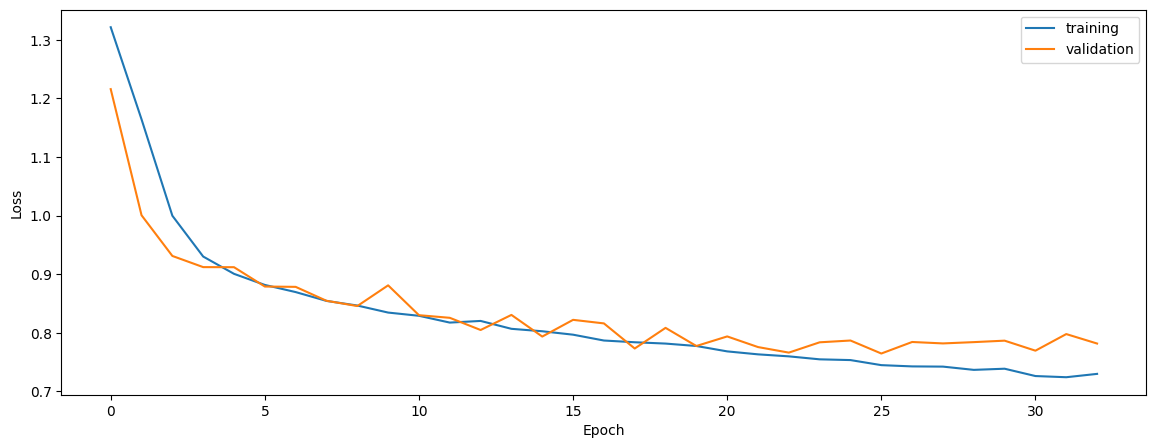

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.7019088357448395
0.6982952749683944
0.7147479977348111


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.7019088357448395
0.6982952749683944
0.7147479977348111


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.7032561877110934
0.7141096817874069
0.7102620594975809


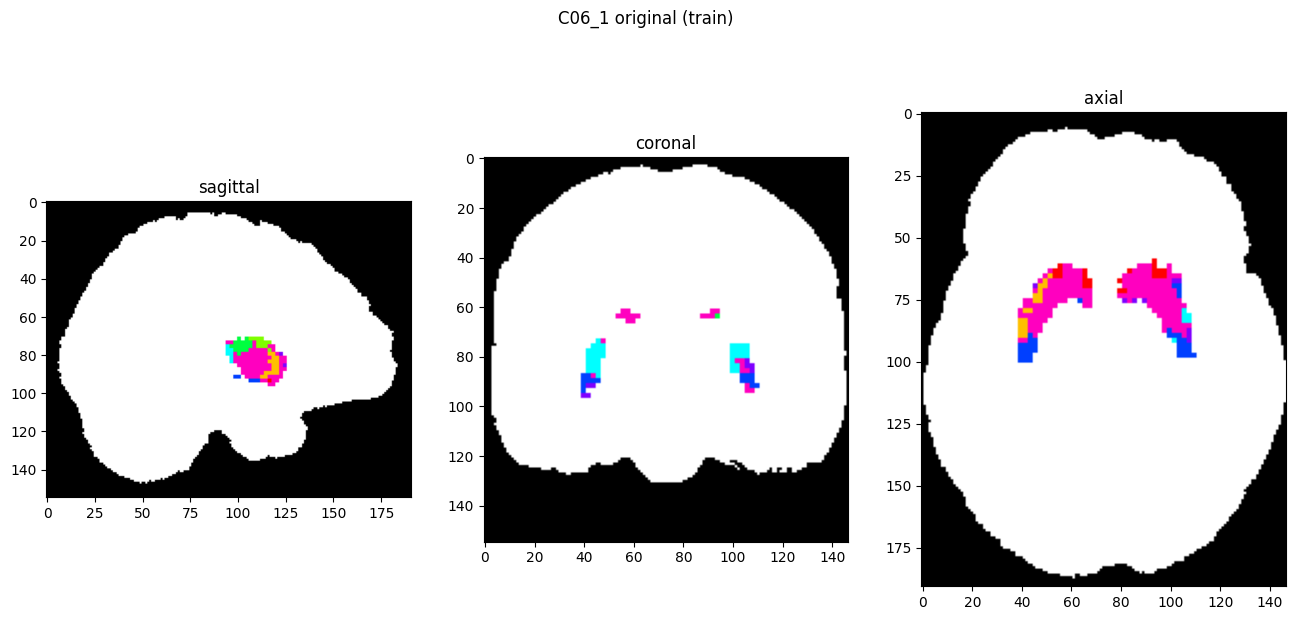

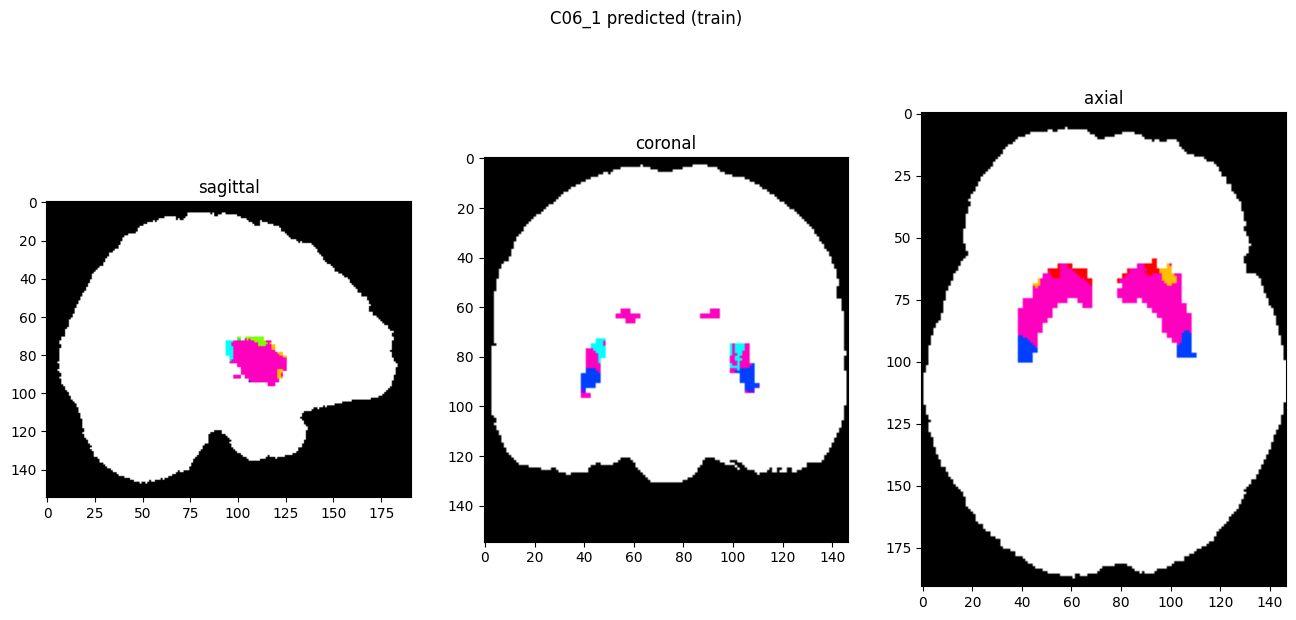

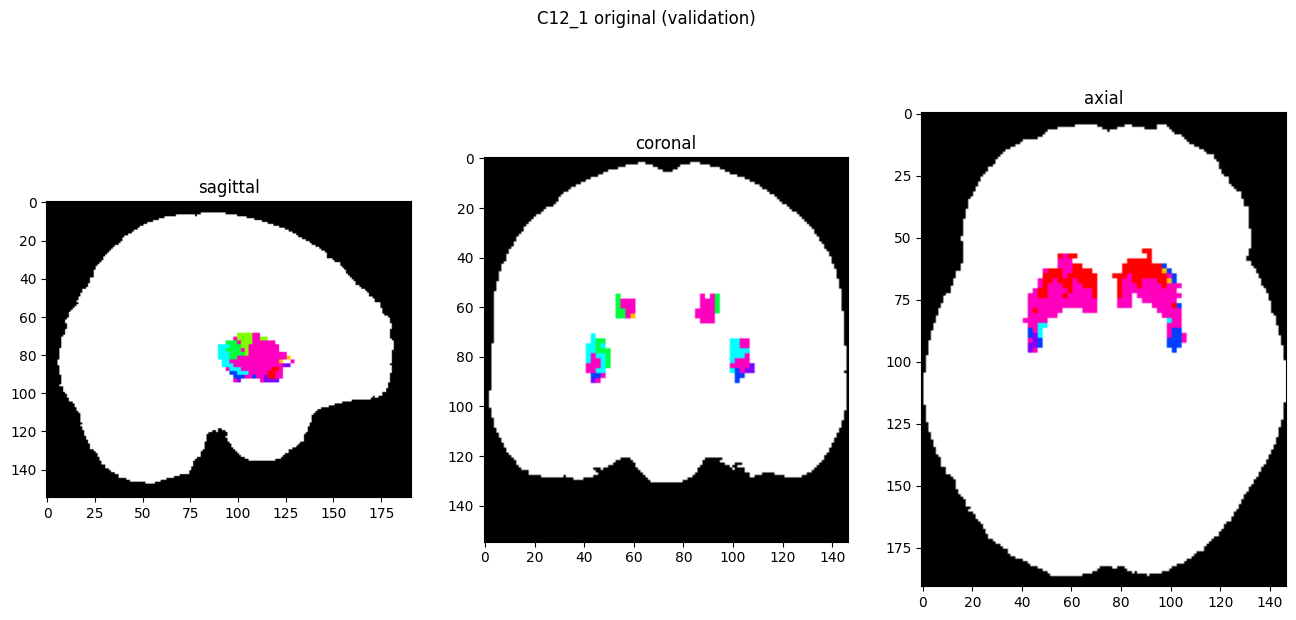

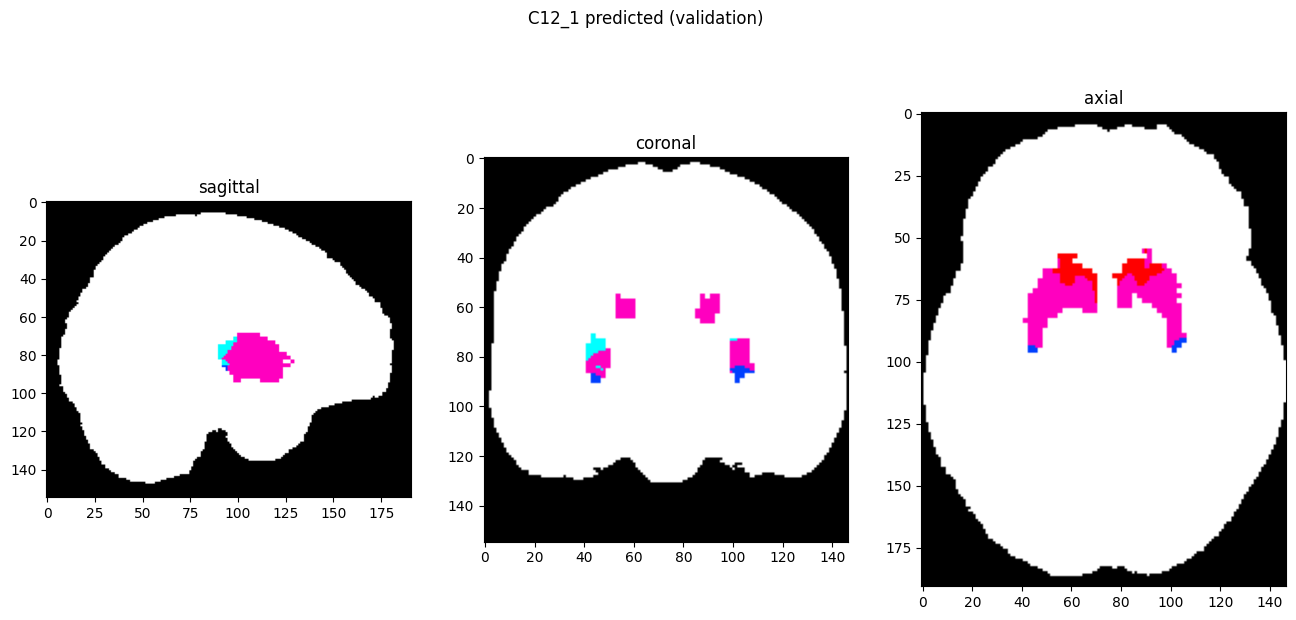

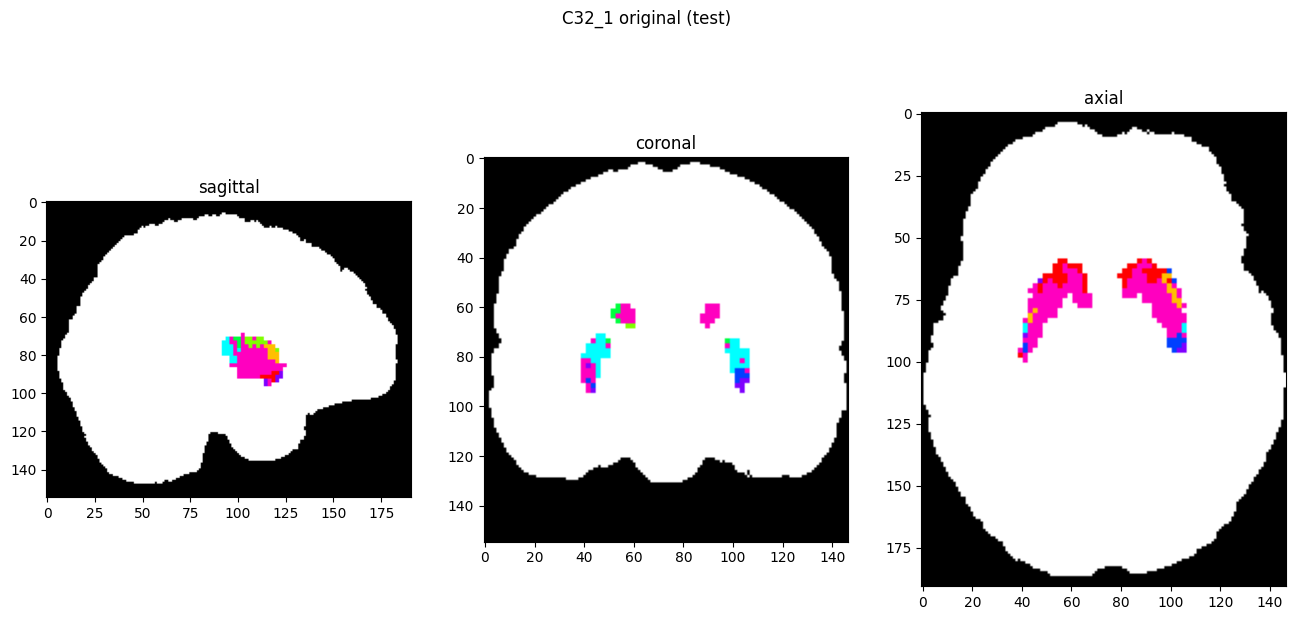

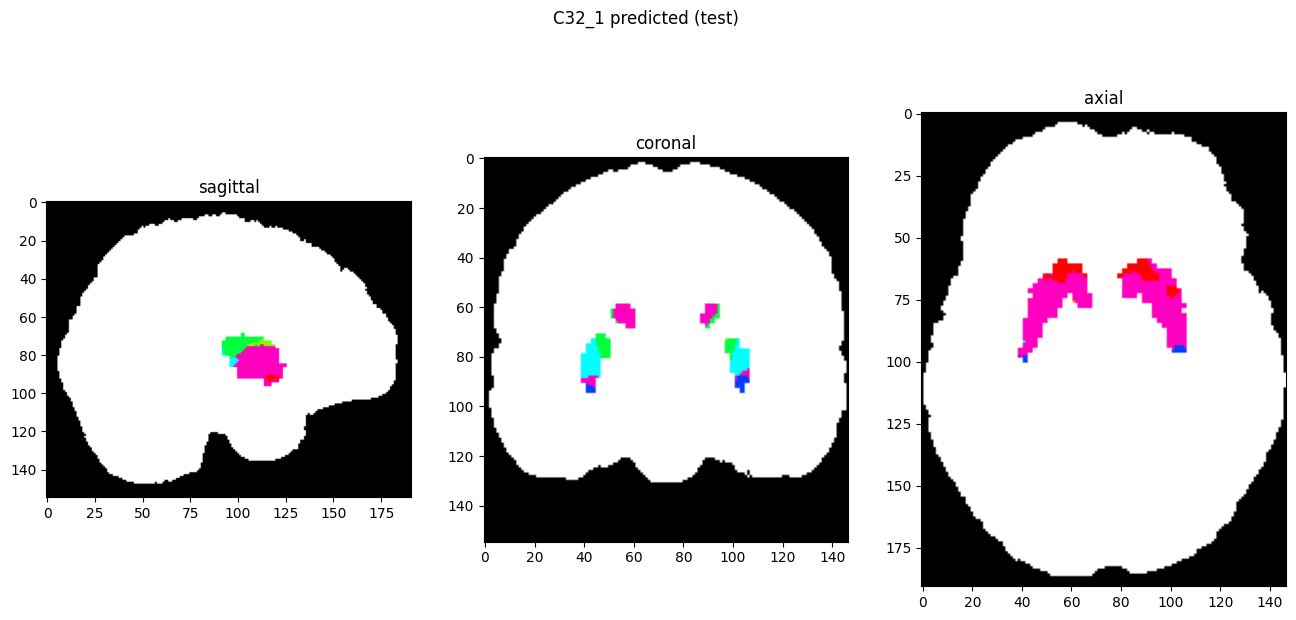

In [10]:
showResults(model, gen, threshold=0)